In [1]:
try:
  !pip uninstall -qy geometricvocab geofractal
except:
  pass

!pip install -q git+https://github.com/AbstractEyes/geofractal.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Device: cuda
Available regions: ['cardioid', 'period2', 'period3', 'seahorse', 'elephant', 'antenna', 'spiral', 'cusp', 'mini_brot', 'dendrite']
Expert slice dim: 32
Regions: ('cardioid', 'period2', 'seahorse', 'elephant', 'antenna', 'spiral')
Model output shape: torch.Size([4, 6])
Parameters: 381,830
Generating 6000 orbits from 6 regions...
Dataset shape: torch.Size([6000, 64, 4])
Label distribution: [1000 1000 1000 1000 1000 1000]
Generating 600 orbits from 6 regions...
Dataset shape: torch.Size([600, 64, 4])
Label distribution: [100 100 100 100 100 100]

Training FractalBEANS for 50 epochs...
Model: 128d, 2L, 4 experts
------------------------------------------------------------
Epoch   1 | Train: 0.5051 / 77.2% | Val: 0.2852 / 84.2% ★
Epoch   5 | Train: 0.1658 / 92.5% | Val: 0.1615 / 91.5%
Epoch  10 | Train: 0.1206 / 95.1% | Val: 0.1306 / 94.0%
Epoch  15 | Train: 0.1181 / 95.3% | Val: 0.1224 / 95.2%
Epoch  20 | Train: 0.0979 / 96.4% | Val: 0.1208 / 95.3%
Epoch  25 | Train: 0.0977 /

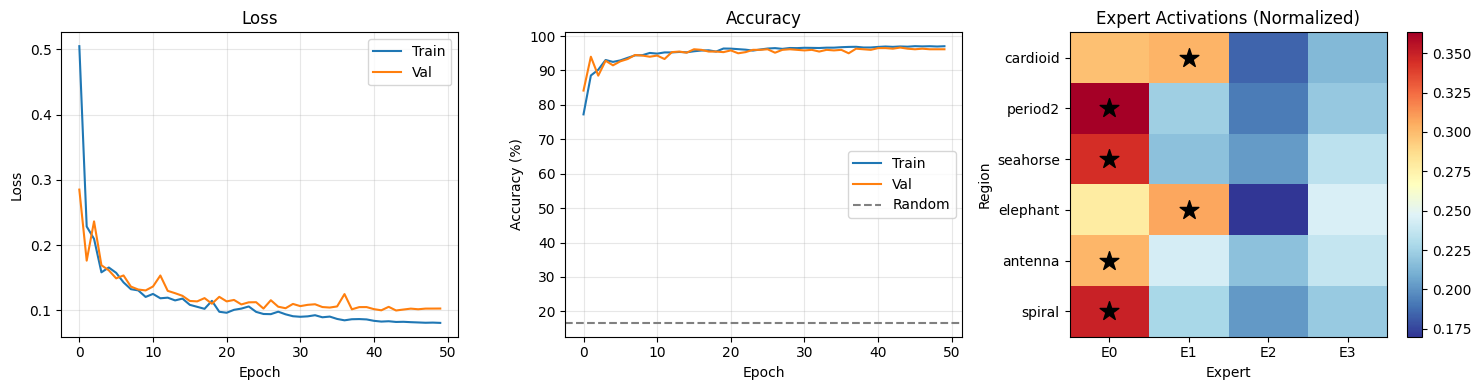


EXPERT SPECIALIZATION SUMMARY

Dominant Expert → Regions:
  Expert 0: period2, seahorse, antenna, spiral
  Expert 1: cardioid, elephant
  Expert 2: (none)
  Expert 3: (none)

Final validation accuracy: 96.7%


In [3]:
# ============================================================================
# FractalBEANS: Expert Fingerprinting Experiment
# ============================================================================
# Goal: Can transformer experts learn to specialize on different fractal behaviors?
#
# Hypothesis: Experts will naturally specialize:
#   - Expert 0: Bounded orbits (cardioid interior)
#   - Expert 1: Slow spiraling escapes
#   - Expert 2: Fast escapes (antenna)
#   - Expert 3: Chaotic dynamics (seahorse)
#   - Expert 4: Periodic cycles (period-2, period-3)
# ============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Optional, Dict, List, Tuple
from dataclasses import dataclass
from tqdm.auto import tqdm

# geovocab2 imports
from geovocab2.shapes.factory.fractal_factory import (
    FractalFactory,
    FractalMode,
    create_orbit_dataset,
    get_region_names,
    FRACTAL_REGIONS
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
print(f'Available regions: {get_region_names()}')

# ============================================================================
# Configuration
# ============================================================================

@dataclass
class FractalBeansConfig:
    """Configuration for FractalBEANS experiment."""
    # Model
    input_dim: int = 4           # [re, im, |z|, phase]
    dim: int = 128               # Hidden dimension
    num_layers: int = 2          # Shallow for fast iteration
    num_heads: int = 4           # Attention heads
    num_experts: int = 4         # Expert slices
    dropout: float = 0.1

    # Data
    sequence_length: int = 64    # Orbit length
    num_classes: int = 6         # Regions to classify
    regions: Tuple[str, ...] = ('cardioid', 'period2', 'seahorse', 'elephant', 'antenna', 'spiral')

    # Training
    train_samples: int = 6000    # 1000 per region
    val_samples: int = 600       # 100 per region
    batch_size: int = 64
    lr: float = 1e-3
    epochs: int = 1000

    def __post_init__(self):
        self.num_classes = len(self.regions)
        assert self.dim % self.num_experts == 0, f"dim must be divisible by num_experts"
        self.expert_dim = self.dim // self.num_experts

config = FractalBeansConfig()
print(f"Expert slice dim: {config.expert_dim}")
print(f"Regions: {config.regions}")

# ============================================================================
# Model: FractalBEANS
# ============================================================================

class ExpertSliceAttention(nn.Module):
    """
    Attention with expert-sliced value projections.
    Each expert operates on a slice of the hidden dimension.
    """
    def __init__(self, dim: int, num_heads: int, num_experts: int, dropout: float = 0.1):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.num_experts = num_experts
        self.head_dim = dim // num_heads
        self.expert_dim = dim // num_experts

        self.q_proj = nn.Linear(dim, dim)
        self.k_proj = nn.Linear(dim, dim)

        # Expert-sliced V projections
        self.v_projs = nn.ModuleList([
            nn.Linear(self.expert_dim, self.expert_dim)
            for _ in range(num_experts)
        ])

        self.out_proj = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)
        self.expert_norms: Optional[torch.Tensor] = None

    def forward(self, x: torch.Tensor, store_expert_info: bool = False) -> torch.Tensor:
        B, T, D = x.shape

        q = self.q_proj(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        v_slices = []
        expert_contributions = []

        for i, v_proj in enumerate(self.v_projs):
            start = i * self.expert_dim
            end = start + self.expert_dim
            x_slice = x[..., start:end]
            v_slice = v_proj(x_slice)
            v_slices.append(v_slice)

            if store_expert_info:
                expert_contributions.append(v_slice.norm(dim=-1).mean(dim=-1))

        v = torch.cat(v_slices, dim=-1)
        v = v.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        scale = self.head_dim ** -0.5
        attn = (q @ k.transpose(-2, -1)) * scale
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)

        out = (attn @ v).transpose(1, 2).reshape(B, T, D)
        out = self.out_proj(out)

        if store_expert_info:
            self.expert_norms = torch.stack(expert_contributions, dim=-1)

        return out


class FractalBeansBlock(nn.Module):
    """Transformer block with expert-sliced attention."""
    def __init__(self, dim: int, num_heads: int, num_experts: int, dropout: float = 0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = ExpertSliceAttention(dim, num_heads, num_experts, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x: torch.Tensor, store_expert_info: bool = False) -> torch.Tensor:
        x = x + self.attn(self.norm1(x), store_expert_info=store_expert_info)
        x = x + self.ffn(self.norm2(x))
        return x


class FractalBEANS(nn.Module):
    """
    Minimal transformer for fractal orbit classification.
    Designed for probing expert specialization.
    """
    def __init__(self, config: FractalBeansConfig):
        super().__init__()
        self.config = config

        self.input_proj = nn.Linear(config.input_dim, config.dim)
        self.pos_embed = nn.Parameter(
            torch.randn(1, config.sequence_length, config.dim) * 0.02
        )

        self.layers = nn.ModuleList([
            FractalBeansBlock(config.dim, config.num_heads, config.num_experts, config.dropout)
            for _ in range(config.num_layers)
        ])

        self.norm = nn.LayerNorm(config.dim)
        self.head = nn.Linear(config.dim, config.num_classes)
        self._store_expert_info = False

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, _ = x.shape
        x = self.input_proj(x)
        x = x + self.pos_embed[:, :T, :]

        for layer in self.layers:
            x = layer(x, store_expert_info=self._store_expert_info)

        x = self.norm(x)
        x = x.mean(dim=1)
        return self.head(x)

    def get_expert_activations(self) -> Dict[int, torch.Tensor]:
        activations = {}
        for i, layer in enumerate(self.layers):
            if layer.attn.expert_norms is not None:
                activations[i] = layer.attn.expert_norms
        return activations

    def enable_expert_tracking(self):
        self._store_expert_info = True

    def disable_expert_tracking(self):
        self._store_expert_info = False

# Test model
model = FractalBEANS(config).to(device)
dummy = torch.randn(4, config.sequence_length, 4).to(device)
out = model(dummy)
print(f"Model output shape: {out.shape}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

# ============================================================================
# Dataset
# ============================================================================

class FractalOrbitDataset(Dataset):
    """Dataset of fractal orbits with region labels."""

    def __init__(self, num_samples: int, sequence_length: int, regions: List[str], seed: int = 42):
        self.regions = regions
        self.region_to_idx = {r: i for i, r in enumerate(regions)}

        print(f"Generating {num_samples} orbits from {len(regions)} regions...")
        self.data, self.metadata = create_orbit_dataset(
            num_samples=num_samples,
            sequence_length=sequence_length,
            regions=regions,
            seed=seed,
            backend='numpy'
        )

        self.labels = np.array([self.region_to_idx[m['region']] for m in self.metadata])
        self.data = torch.from_numpy(self.data).float()
        self.labels = torch.from_numpy(self.labels).long()

        print(f"Dataset shape: {self.data.shape}")
        print(f"Label distribution: {np.bincount(self.labels.numpy())}")

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int, Dict]:
        return self.data[idx], self.labels[idx], self.metadata[idx]

# Create datasets
train_dataset = FractalOrbitDataset(config.train_samples, config.sequence_length, list(config.regions), seed=42)
val_dataset = FractalOrbitDataset(config.val_samples, config.sequence_length, list(config.regions), seed=123)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

# ============================================================================
# Training
# ============================================================================

def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for orbits, labels, _ in loader:
        orbits, labels = orbits.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(orbits)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * orbits.size(0)
        correct += (logits.argmax(dim=-1) == labels).sum().item()
        total += orbits.size(0)

    return total_loss / total, correct / total

@torch.no_grad()
def eval_epoch(model, loader, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    for orbits, labels, _ in loader:
        orbits, labels = orbits.to(device), labels.to(device)
        logits = model(orbits)
        loss = F.cross_entropy(logits, labels)

        total_loss += loss.item() * orbits.size(0)
        correct += (logits.argmax(dim=-1) == labels).sum().item()
        total += orbits.size(0)

    return total_loss / total, correct / total

# Initialize
model = FractalBEANS(config).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.epochs)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print(f"\nTraining FractalBEANS for {config.epochs} epochs...")
print(f"Model: {config.dim}d, {config.num_layers}L, {config.num_experts} experts")
print("-" * 60)

best_val_acc = 0
for epoch in range(config.epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc = eval_epoch(model, val_loader, device)
    scheduler.step()

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    best_marker = " ★" if val_acc > best_val_acc else ""
    if val_acc > best_val_acc:
        best_val_acc = val_acc

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d} | Train: {train_loss:.4f} / {train_acc*100:.1f}% | "
              f"Val: {val_loss:.4f} / {val_acc*100:.1f}%{best_marker}")

print("-" * 60)
print(f"Best validation accuracy: {best_val_acc*100:.1f}%")

# ============================================================================
# Expert Activation Analysis
# ============================================================================

@torch.no_grad()
def analyze_expert_activations(model, loader, device, regions):
    """Analyze which experts activate for which regions."""
    model.eval()
    model.enable_expert_tracking()

    region_activations = defaultdict(list)
    idx_to_region = {i: r for i, r in enumerate(regions)}

    for orbits, labels, _ in loader:  # Ignore metadata, use labels
        orbits = orbits.to(device)
        _ = model(orbits)

        activations = model.get_expert_activations()
        last_layer_idx = max(activations.keys())
        expert_norms = activations[last_layer_idx].cpu()

        for i, label in enumerate(labels):
            region = idx_to_region[label.item()]
            region_activations[region].append(expert_norms[i])

    model.disable_expert_tracking()

    stats = {}
    for region in regions:
        if region in region_activations:
            acts = torch.stack(region_activations[region])
            stats[region] = {
                'mean': acts.mean(dim=0).numpy(),
                'std': acts.std(dim=0).numpy(),
                'dominant_expert': acts.mean(dim=0).argmax().item()
            }

    return stats

expert_stats = analyze_expert_activations(model, val_loader, device, list(config.regions))

print("\nExpert Activation Analysis")
print("=" * 60)
for region, stats in expert_stats.items():
    dominant = stats['dominant_expert']
    mean_str = ' '.join([f"{m:.2f}" for m in stats['mean']])
    print(f"{region:12s} | Experts: [{mean_str}] | Dominant: E{dominant}")

# ============================================================================
# Visualization
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss curve
axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Val')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curve
axes[1].plot([a*100 for a in history['train_acc']], label='Train')
axes[1].plot([a*100 for a in history['val_acc']], label='Val')
axes[1].axhline(y=100/config.num_classes, color='gray', linestyle='--', label='Random')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Expert activation heatmap
matrix = np.zeros((len(config.regions), config.num_experts))
for i, region in enumerate(config.regions):
    if region in expert_stats:
        matrix[i] = expert_stats[region]['mean']

matrix_norm = matrix / (matrix.sum(axis=1, keepdims=True) + 1e-8)

im = axes[2].imshow(matrix_norm, aspect='auto', cmap='RdYlBu_r')
axes[2].set_xticks(range(config.num_experts))
axes[2].set_xticklabels([f'E{i}' for i in range(config.num_experts)])
axes[2].set_yticks(range(len(config.regions)))
axes[2].set_yticklabels(config.regions)
axes[2].set_xlabel('Expert')
axes[2].set_ylabel('Region')
axes[2].set_title('Expert Activations (Normalized)')
plt.colorbar(im, ax=axes[2])

# Mark dominant experts
for i, region in enumerate(config.regions):
    if region in expert_stats:
        dom = expert_stats[region]['dominant_expert']
        axes[2].scatter(dom, i, marker='*', s=200, c='black', zorder=10)

plt.tight_layout()
plt.show()

# ============================================================================
# Summary
# ============================================================================

print("\n" + "="*70)
print("EXPERT SPECIALIZATION SUMMARY")
print("="*70)

expert_to_regions = defaultdict(list)
for region, stats in expert_stats.items():
    expert_to_regions[stats['dominant_expert']].append(region)

print("\nDominant Expert → Regions:")
for expert_idx in range(config.num_experts):
    regions = expert_to_regions.get(expert_idx, [])
    regions_str = ', '.join(regions) if regions else '(none)'
    print(f"  Expert {expert_idx}: {regions_str}")

print("\n" + "="*70)
print(f"Final validation accuracy: {best_val_acc*100:.1f}%")
print("="*70)

Device: cuda
Available regions: ['cardioid', 'period2', 'period3', 'seahorse', 'elephant', 'antenna', 'spiral', 'cusp', 'mini_brot', 'dendrite']
Expert slice dim: 32
Regions: ('cardioid', 'period2', 'seahorse', 'elephant', 'antenna', 'spiral')
Training for 1000 epochs with checkpoints every 100
Model output shape: torch.Size([4, 6])
Parameters: 589,926
Generating 6000 orbits from 6 regions...
Dataset shape: torch.Size([6000, 64, 4])
Label distribution: [1000 1000 1000 1000 1000 1000]
Generating 600 orbits from 6 regions...
Dataset shape: torch.Size([600, 64, 4])
Label distribution: [100 100 100 100 100 100]

Training FractalBEANS for 1000 epochs...
Model: 160d, 2L, 5 experts
Checkpointing expert stats every 100 epochs
----------------------------------------------------------------------
Epoch   50 | Train: 0.0944 / 96.5% | Val: 0.1171 / 95.0%
Epoch  100 | Train: 0.0952 / 96.5% | Val: 0.1195 / 95.8% | Active Experts: 3/5
Epoch  150 | Train: 0.0823 / 96.8% | Val: 0.1035 / 96.0%
Epoch  2

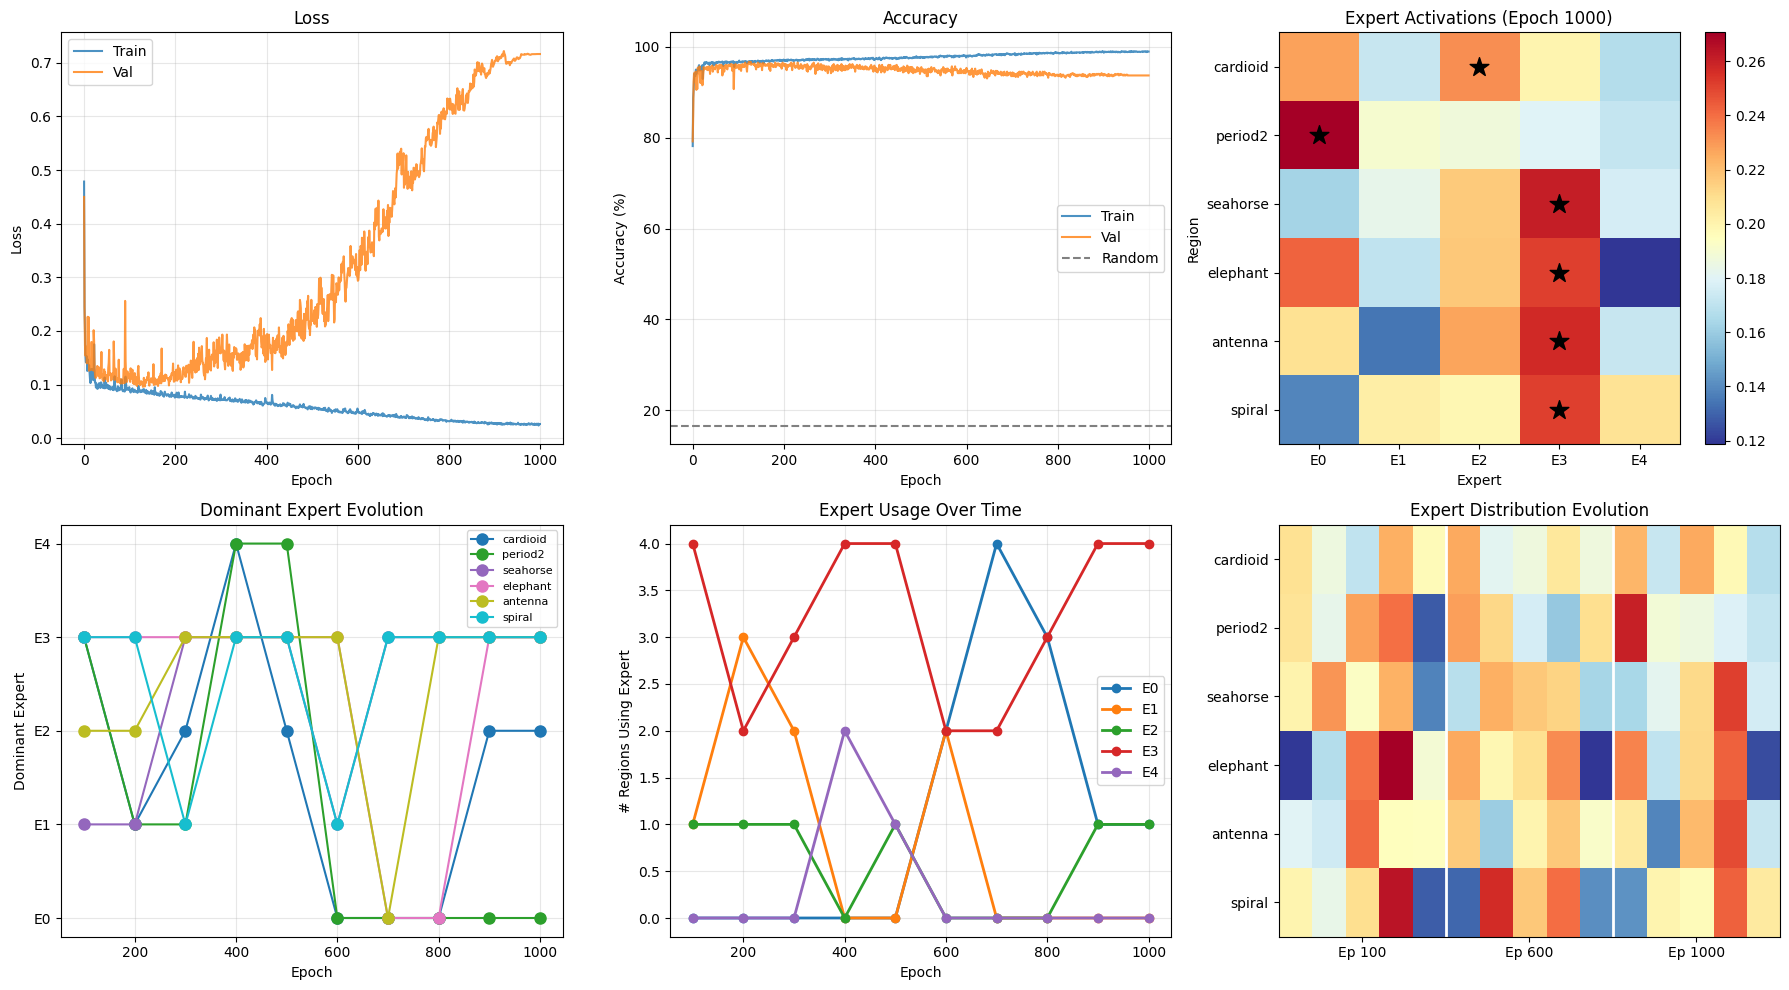


FINAL EXPERT SPECIALIZATION SUMMARY

Dominant Expert → Regions:
  Expert 0: period2
  Expert 1: (none)
  Expert 2: cardioid
  Expert 3: seahorse, elephant, antenna, spiral
  Expert 4: (none)

Active experts: 3/5

Behavior → Expert mapping:
  Bounded: {'period2', 'cardioid'} → Experts {0, 2}
  Chaotic: {'seahorse', 'spiral'} → Experts {3}
  Escaping: {'elephant', 'antenna'} → Experts {3}

Final validation accuracy: 96.7%


In [4]:
# ============================================================================
# FractalBEANS: Expert Fingerprinting Experiment (1000 Epochs)
# ============================================================================
# Goal: Can transformer experts learn to specialize on different fractal behaviors?
# Watch: Do dormant experts (E2, E3) wake up over longer training?
# ============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Optional, Dict, List, Tuple
from dataclasses import dataclass
from tqdm.auto import tqdm
import copy

# geovocab2 imports
from geovocab2.shapes.factory.fractal_factory import (
    FractalFactory,
    FractalMode,
    create_orbit_dataset,
    get_region_names,
    FRACTAL_REGIONS
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
print(f'Available regions: {get_region_names()}')

# ============================================================================
# Configuration
# ============================================================================

@dataclass
class FractalBeansConfig:
    """Configuration for FractalBEANS experiment."""
    # Model
    input_dim: int = 4           # [re, im, |z|, phase]
    dim: int = 160               # Hidden dimension (160/5=32 per expert)
    num_layers: int = 2          # Shallow for fast iteration
    num_heads: int = 4           # Attention heads
    num_experts: int = 5         # Expert slices (back to 5!)
    dropout: float = 0.1

    # Data
    sequence_length: int = 64    # Orbit length
    num_classes: int = 6         # Regions to classify
    regions: Tuple[str, ...] = ('cardioid', 'period2', 'seahorse', 'elephant', 'antenna', 'spiral')

    # Training
    train_samples: int = 6000    # 1000 per region
    val_samples: int = 600       # 100 per region
    batch_size: int = 64
    lr: float = 1e-3
    epochs: int = 1000           # Long run!
    checkpoint_every: int = 100  # Save expert stats every N epochs

    def __post_init__(self):
        self.num_classes = len(self.regions)
        assert self.dim % self.num_experts == 0, f"dim must be divisible by num_experts"
        self.expert_dim = self.dim // self.num_experts

config = FractalBeansConfig()
print(f"Expert slice dim: {config.expert_dim}")
print(f"Regions: {config.regions}")
print(f"Training for {config.epochs} epochs with checkpoints every {config.checkpoint_every}")

# ============================================================================
# Model: FractalBEANS
# ============================================================================

class ExpertSliceAttention(nn.Module):
    """
    Attention with expert-sliced value projections.
    Each expert operates on a slice of the hidden dimension.
    """
    def __init__(self, dim: int, num_heads: int, num_experts: int, dropout: float = 0.1):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.num_experts = num_experts
        self.head_dim = dim // num_heads
        self.expert_dim = dim // num_experts

        self.q_proj = nn.Linear(dim, dim)
        self.k_proj = nn.Linear(dim, dim)

        # Expert-sliced V projections
        self.v_projs = nn.ModuleList([
            nn.Linear(self.expert_dim, self.expert_dim)
            for _ in range(num_experts)
        ])

        self.out_proj = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)
        self.expert_norms: Optional[torch.Tensor] = None

    def forward(self, x: torch.Tensor, store_expert_info: bool = False) -> torch.Tensor:
        B, T, D = x.shape

        q = self.q_proj(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        v_slices = []
        expert_contributions = []

        for i, v_proj in enumerate(self.v_projs):
            start = i * self.expert_dim
            end = start + self.expert_dim
            x_slice = x[..., start:end]
            v_slice = v_proj(x_slice)
            v_slices.append(v_slice)

            if store_expert_info:
                expert_contributions.append(v_slice.norm(dim=-1).mean(dim=-1))

        v = torch.cat(v_slices, dim=-1)
        v = v.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        scale = self.head_dim ** -0.5
        attn = (q @ k.transpose(-2, -1)) * scale
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)

        out = (attn @ v).transpose(1, 2).reshape(B, T, D)
        out = self.out_proj(out)

        if store_expert_info:
            self.expert_norms = torch.stack(expert_contributions, dim=-1)

        return out


class FractalBeansBlock(nn.Module):
    """Transformer block with expert-sliced attention."""
    def __init__(self, dim: int, num_heads: int, num_experts: int, dropout: float = 0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = ExpertSliceAttention(dim, num_heads, num_experts, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x: torch.Tensor, store_expert_info: bool = False) -> torch.Tensor:
        x = x + self.attn(self.norm1(x), store_expert_info=store_expert_info)
        x = x + self.ffn(self.norm2(x))
        return x


class FractalBEANS(nn.Module):
    """
    Minimal transformer for fractal orbit classification.
    Designed for probing expert specialization.
    """
    def __init__(self, config: FractalBeansConfig):
        super().__init__()
        self.config = config

        self.input_proj = nn.Linear(config.input_dim, config.dim)
        self.pos_embed = nn.Parameter(
            torch.randn(1, config.sequence_length, config.dim) * 0.02
        )

        self.layers = nn.ModuleList([
            FractalBeansBlock(config.dim, config.num_heads, config.num_experts, config.dropout)
            for _ in range(config.num_layers)
        ])

        self.norm = nn.LayerNorm(config.dim)
        self.head = nn.Linear(config.dim, config.num_classes)
        self._store_expert_info = False

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, _ = x.shape
        x = self.input_proj(x)
        x = x + self.pos_embed[:, :T, :]

        for layer in self.layers:
            x = layer(x, store_expert_info=self._store_expert_info)

        x = self.norm(x)
        x = x.mean(dim=1)
        return self.head(x)

    def get_expert_activations(self) -> Dict[int, torch.Tensor]:
        activations = {}
        for i, layer in enumerate(self.layers):
            if layer.attn.expert_norms is not None:
                activations[i] = layer.attn.expert_norms
        return activations

    def enable_expert_tracking(self):
        self._store_expert_info = True

    def disable_expert_tracking(self):
        self._store_expert_info = False

# Test model
model = FractalBEANS(config).to(device)
dummy = torch.randn(4, config.sequence_length, 4).to(device)
out = model(dummy)
print(f"Model output shape: {out.shape}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

# ============================================================================
# Dataset
# ============================================================================

class FractalOrbitDataset(Dataset):
    """Dataset of fractal orbits with region labels."""

    def __init__(self, num_samples: int, sequence_length: int, regions: List[str], seed: int = 42):
        self.regions = regions
        self.region_to_idx = {r: i for i, r in enumerate(regions)}

        print(f"Generating {num_samples} orbits from {len(regions)} regions...")
        self.data, self.metadata = create_orbit_dataset(
            num_samples=num_samples,
            sequence_length=sequence_length,
            regions=regions,
            seed=seed,
            backend='numpy'
        )

        self.labels = np.array([self.region_to_idx[m['region']] for m in self.metadata])
        self.data = torch.from_numpy(self.data).float()
        self.labels = torch.from_numpy(self.labels).long()

        print(f"Dataset shape: {self.data.shape}")
        print(f"Label distribution: {np.bincount(self.labels.numpy())}")

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int, Dict]:
        return self.data[idx], self.labels[idx], self.metadata[idx]

# Create datasets
train_dataset = FractalOrbitDataset(config.train_samples, config.sequence_length, list(config.regions), seed=42)
val_dataset = FractalOrbitDataset(config.val_samples, config.sequence_length, list(config.regions), seed=123)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

# ============================================================================
# Expert Analysis Function (Fixed)
# ============================================================================

@torch.no_grad()
def analyze_expert_activations(model, loader, device, regions):
    """Analyze which experts activate for which regions."""
    model.eval()
    model.enable_expert_tracking()

    region_activations = defaultdict(list)
    idx_to_region = {i: r for i, r in enumerate(regions)}

    for orbits, labels, _ in loader:  # Use labels, not metadata
        orbits = orbits.to(device)
        _ = model(orbits)

        activations = model.get_expert_activations()
        last_layer_idx = max(activations.keys())
        expert_norms = activations[last_layer_idx].cpu()

        for i, label in enumerate(labels):
            region = idx_to_region[label.item()]
            region_activations[region].append(expert_norms[i])

    model.disable_expert_tracking()

    stats = {}
    for region in regions:
        if region in region_activations:
            acts = torch.stack(region_activations[region])
            stats[region] = {
                'mean': acts.mean(dim=0).numpy(),
                'std': acts.std(dim=0).numpy(),
                'dominant_expert': acts.mean(dim=0).argmax().item()
            }

    return stats

# ============================================================================
# Training with Checkpointing
# ============================================================================

def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for orbits, labels, _ in loader:
        orbits, labels = orbits.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(orbits)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * orbits.size(0)
        correct += (logits.argmax(dim=-1) == labels).sum().item()
        total += orbits.size(0)

    return total_loss / total, correct / total

@torch.no_grad()
def eval_epoch(model, loader, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    for orbits, labels, _ in loader:
        orbits, labels = orbits.to(device), labels.to(device)
        logits = model(orbits)
        loss = F.cross_entropy(logits, labels)

        total_loss += loss.item() * orbits.size(0)
        correct += (logits.argmax(dim=-1) == labels).sum().item()
        total += orbits.size(0)

    return total_loss / total, correct / total

# Initialize
model = FractalBEANS(config).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.epochs)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# Checkpoints for expert stats evolution
expert_checkpoints = {}  # epoch -> expert_stats

print(f"\nTraining FractalBEANS for {config.epochs} epochs...")
print(f"Model: {config.dim}d, {config.num_layers}L, {config.num_experts} experts")
print(f"Checkpointing expert stats every {config.checkpoint_every} epochs")
print("-" * 70)

best_val_acc = 0
for epoch in range(config.epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc = eval_epoch(model, val_loader, device)
    scheduler.step()

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    best_marker = " ★" if val_acc > best_val_acc else ""
    if val_acc > best_val_acc:
        best_val_acc = val_acc

    # Checkpoint expert stats
    if (epoch + 1) % config.checkpoint_every == 0:
        expert_stats = analyze_expert_activations(model, val_loader, device, list(config.regions))
        expert_checkpoints[epoch + 1] = copy.deepcopy(expert_stats)

        # Print checkpoint info
        dominant_counts = defaultdict(int)
        for region, stats in expert_stats.items():
            dominant_counts[stats['dominant_expert']] += 1
        active_experts = sum(1 for c in dominant_counts.values() if c > 0)

        print(f"Epoch {epoch+1:4d} | Train: {train_loss:.4f} / {train_acc*100:.1f}% | "
              f"Val: {val_loss:.4f} / {val_acc*100:.1f}%{best_marker} | "
              f"Active Experts: {active_experts}/{config.num_experts}")

    elif (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1:4d} | Train: {train_loss:.4f} / {train_acc*100:.1f}% | "
              f"Val: {val_loss:.4f} / {val_acc*100:.1f}%{best_marker}")

print("-" * 70)
print(f"Best validation accuracy: {best_val_acc*100:.1f}%")

# Final expert analysis
final_expert_stats = analyze_expert_activations(model, val_loader, device, list(config.regions))
expert_checkpoints[config.epochs] = final_expert_stats

# ============================================================================
# Expert Evolution Visualization
# ============================================================================

print("\n" + "=" * 70)
print("EXPERT EVOLUTION OVER TRAINING")
print("=" * 70)

checkpoint_epochs = sorted(expert_checkpoints.keys())

# Build evolution matrix for each region
for region in config.regions:
    print(f"\n{region}:")
    for ep in checkpoint_epochs:
        stats = expert_checkpoints[ep].get(region, {})
        if 'mean' in stats:
            mean_str = ' '.join([f"{m:.2f}" for m in stats['mean']])
            dom = stats['dominant_expert']
            print(f"  Epoch {ep:4d}: [{mean_str}] → E{dom}")

# ============================================================================
# Final Visualization
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Row 1: Training curves
axes[0, 0].plot(history['train_loss'], label='Train', alpha=0.8)
axes[0, 0].plot(history['val_loss'], label='Val', alpha=0.8)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot([a*100 for a in history['train_acc']], label='Train', alpha=0.8)
axes[0, 1].plot([a*100 for a in history['val_acc']], label='Val', alpha=0.8)
axes[0, 1].axhline(y=100/config.num_classes, color='gray', linestyle='--', label='Random')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Expert activation heatmap (final)
matrix = np.zeros((len(config.regions), config.num_experts))
for i, region in enumerate(config.regions):
    if region in final_expert_stats:
        matrix[i] = final_expert_stats[region]['mean']

matrix_norm = matrix / (matrix.sum(axis=1, keepdims=True) + 1e-8)

im = axes[0, 2].imshow(matrix_norm, aspect='auto', cmap='RdYlBu_r')
axes[0, 2].set_xticks(range(config.num_experts))
axes[0, 2].set_xticklabels([f'E{i}' for i in range(config.num_experts)])
axes[0, 2].set_yticks(range(len(config.regions)))
axes[0, 2].set_yticklabels(config.regions)
axes[0, 2].set_xlabel('Expert')
axes[0, 2].set_ylabel('Region')
axes[0, 2].set_title(f'Expert Activations (Epoch {config.epochs})')
plt.colorbar(im, ax=axes[0, 2])

for i, region in enumerate(config.regions):
    if region in final_expert_stats:
        dom = final_expert_stats[region]['dominant_expert']
        axes[0, 2].scatter(dom, i, marker='*', s=200, c='black', zorder=10)

# Row 2: Expert evolution over checkpoints
# Plot dominant expert per region over time
region_colors = plt.cm.tab10(np.linspace(0, 1, len(config.regions)))

axes[1, 0].set_title('Dominant Expert Evolution')
for idx, region in enumerate(config.regions):
    dominants = []
    epochs = []
    for ep in checkpoint_epochs:
        stats = expert_checkpoints[ep].get(region, {})
        if 'dominant_expert' in stats:
            dominants.append(stats['dominant_expert'])
            epochs.append(ep)
    if dominants:
        axes[1, 0].plot(epochs, dominants, 'o-', label=region, color=region_colors[idx], markersize=8)

axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Dominant Expert')
axes[1, 0].set_yticks(range(config.num_experts))
axes[1, 0].set_yticklabels([f'E{i}' for i in range(config.num_experts)])
axes[1, 0].legend(loc='upper right', fontsize=8)
axes[1, 0].grid(True, alpha=0.3)

# Expert usage over time (how many regions use each expert)
axes[1, 1].set_title('Expert Usage Over Time')
for expert_idx in range(config.num_experts):
    usage = []
    for ep in checkpoint_epochs:
        count = sum(1 for r in config.regions
                   if expert_checkpoints[ep].get(r, {}).get('dominant_expert') == expert_idx)
        usage.append(count)
    axes[1, 1].plot(checkpoint_epochs, usage, 'o-', label=f'E{expert_idx}', linewidth=2, markersize=6)

axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('# Regions Using Expert')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Heatmap evolution: show first, middle, last checkpoints
if len(checkpoint_epochs) >= 3:
    selected_epochs = [checkpoint_epochs[0], checkpoint_epochs[len(checkpoint_epochs)//2], checkpoint_epochs[-1]]
else:
    selected_epochs = checkpoint_epochs

evolution_matrix = np.zeros((len(selected_epochs), len(config.regions), config.num_experts))
for t, ep in enumerate(selected_epochs):
    for i, region in enumerate(config.regions):
        stats = expert_checkpoints[ep].get(region, {})
        if 'mean' in stats:
            evolution_matrix[t, i] = stats['mean']

# Flatten for display: regions x (experts * timepoints)
flat_matrix = evolution_matrix.reshape(len(selected_epochs), -1).T
flat_matrix_norm = flat_matrix / (flat_matrix.sum(axis=1, keepdims=True) + 1e-8)

# Just show the three snapshots side by side
for t, (ep, ax_idx) in enumerate(zip(selected_epochs[:3], [axes[1, 2]])):
    if t == 0:  # Only use the last subplot for a combined view
        combined = np.zeros((len(config.regions), config.num_experts * len(selected_epochs)))
        for t2, ep2 in enumerate(selected_epochs):
            for i, region in enumerate(config.regions):
                stats = expert_checkpoints[ep2].get(region, {})
                if 'mean' in stats:
                    norm_vals = stats['mean'] / (stats['mean'].sum() + 1e-8)
                    combined[i, t2*config.num_experts:(t2+1)*config.num_experts] = norm_vals

        im = ax_idx.imshow(combined, aspect='auto', cmap='RdYlBu_r')
        ax_idx.set_yticks(range(len(config.regions)))
        ax_idx.set_yticklabels(config.regions)

        # Label x-axis with epoch groups
        tick_positions = [t*config.num_experts + config.num_experts//2 for t in range(len(selected_epochs))]
        ax_idx.set_xticks(tick_positions)
        ax_idx.set_xticklabels([f'Ep {ep}' for ep in selected_epochs])
        ax_idx.set_title('Expert Distribution Evolution')

        # Add vertical lines between epochs
        for t2 in range(1, len(selected_epochs)):
            ax_idx.axvline(x=t2*config.num_experts - 0.5, color='white', linewidth=2)

plt.tight_layout()
plt.show()

# ============================================================================
# Summary
# ============================================================================

print("\n" + "=" * 70)
print("FINAL EXPERT SPECIALIZATION SUMMARY")
print("=" * 70)

expert_to_regions = defaultdict(list)
for region, stats in final_expert_stats.items():
    expert_to_regions[stats['dominant_expert']].append(region)

print("\nDominant Expert → Regions:")
for expert_idx in range(config.num_experts):
    regions = expert_to_regions.get(expert_idx, [])
    regions_str = ', '.join(regions) if regions else '(none)'
    print(f"  Expert {expert_idx}: {regions_str}")

# Check for expert diversity
active_experts = sum(1 for e in range(config.num_experts) if expert_to_regions.get(e))
print(f"\nActive experts: {active_experts}/{config.num_experts}")

# Behavior groupings
bounded = {'cardioid', 'period2'}
chaotic = {'seahorse', 'spiral'}
escaping = {'antenna', 'elephant'}

print("\nBehavior → Expert mapping:")
for behavior, region_set in [('Bounded', bounded), ('Chaotic', chaotic), ('Escaping', escaping)]:
    experts_used = set()
    for r in region_set:
        if r in final_expert_stats:
            experts_used.add(final_expert_stats[r]['dominant_expert'])
    print(f"  {behavior}: {region_set} → Experts {experts_used}")

print("\n" + "=" * 70)
print(f"Final validation accuracy: {best_val_acc*100:.1f}%")
print("=" * 70)

Device: cuda
Task: Given 48 steps, predict next 16
Regions: ('cardioid', 'period2', 'seahorse', 'elephant', 'antenna', 'spiral')
Input shape: torch.Size([4, 48, 4])
Output shape: torch.Size([4, 16, 2])
Parameters: 936,992
Generating 6000 orbits...
Dataset: 6000 samples
Context: 48, Predict: 16
Generating 600 orbits...
Dataset: 600 samples
Context: 48, Predict: 16

Training FractalPredictor for 200 epochs...
Model: 160d, 3L, 5 experts
----------------------------------------------------------------------
Epoch   1 | Train MSE: 0.020409 | Val MSE: 0.010624 ★
Epoch  20 | Train MSE: 0.006769 | Val MSE: 0.005917
Epoch  40 | Train MSE: 0.004954 | Val MSE: 0.006024
Epoch  60 | Train MSE: 0.003226 | Val MSE: 0.005168
Epoch  80 | Train MSE: 0.003473 | Val MSE: 0.005418
Epoch 100 | Train MSE: 0.001597 | Val MSE: 0.005276
Epoch 120 | Train MSE: 0.001039 | Val MSE: 0.006140
Epoch 140 | Train MSE: 0.000714 | Val MSE: 0.004680 ★
Epoch 160 | Train MSE: 0.000484 | Val MSE: 0.005220
Epoch 180 | Train M

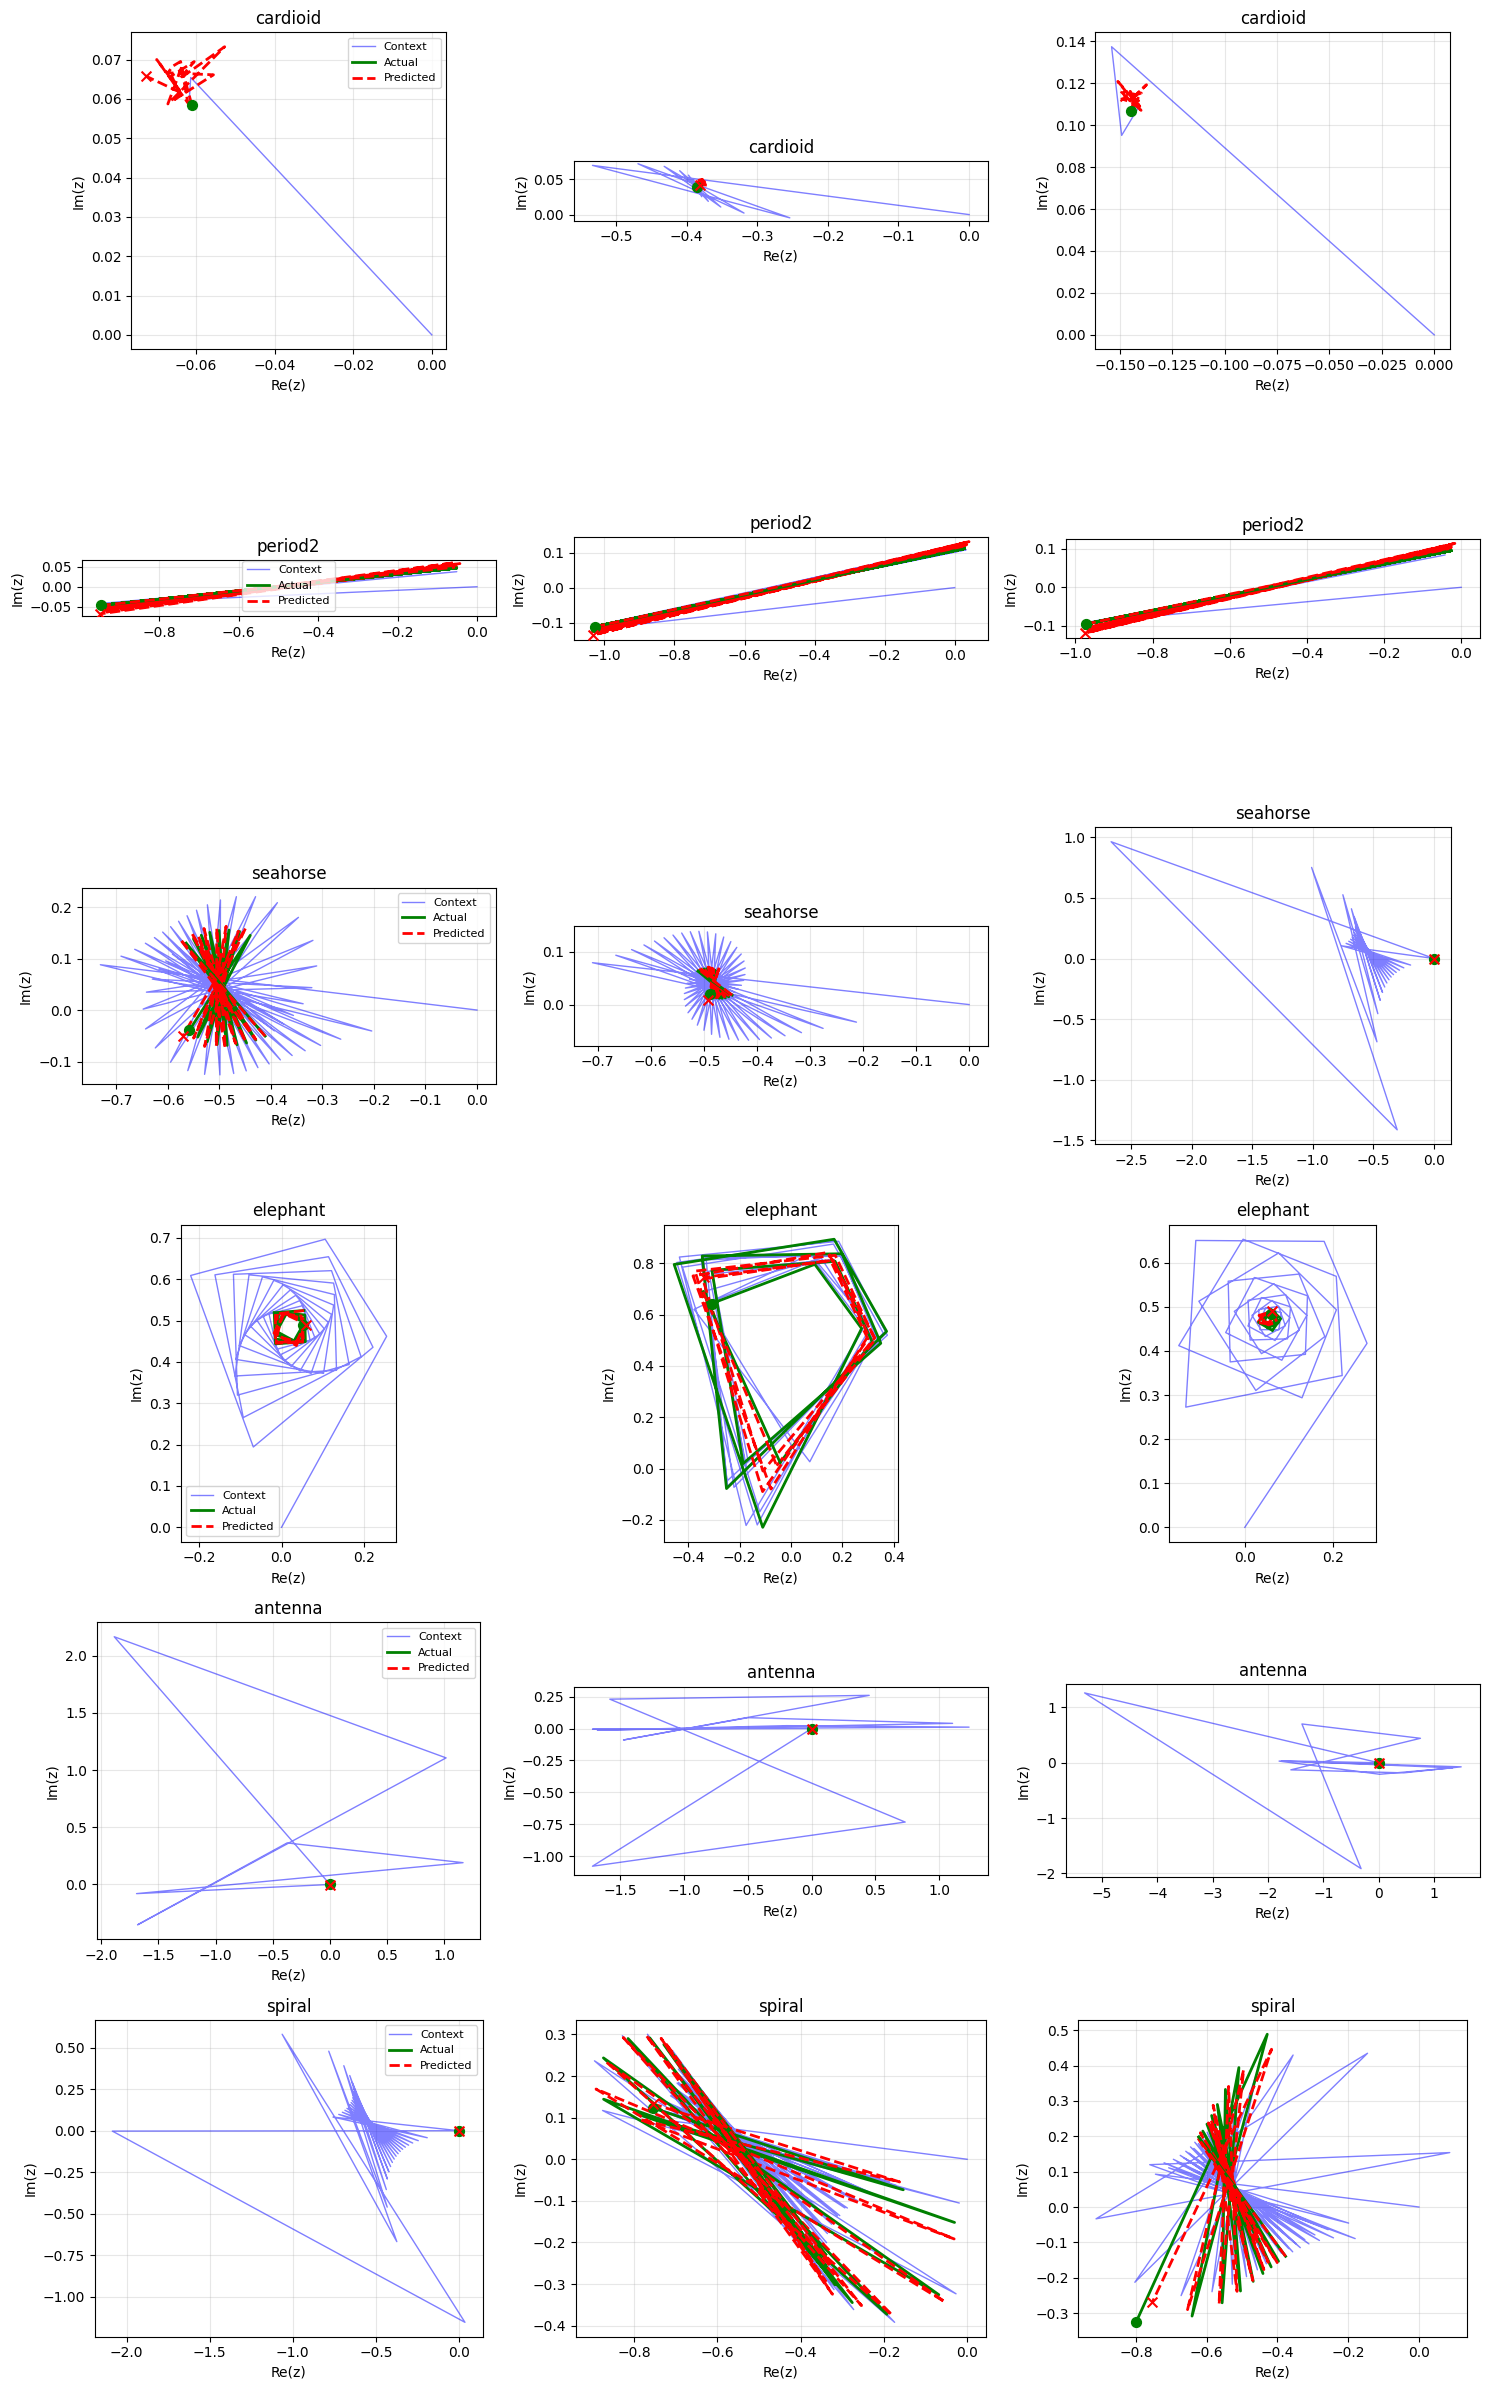

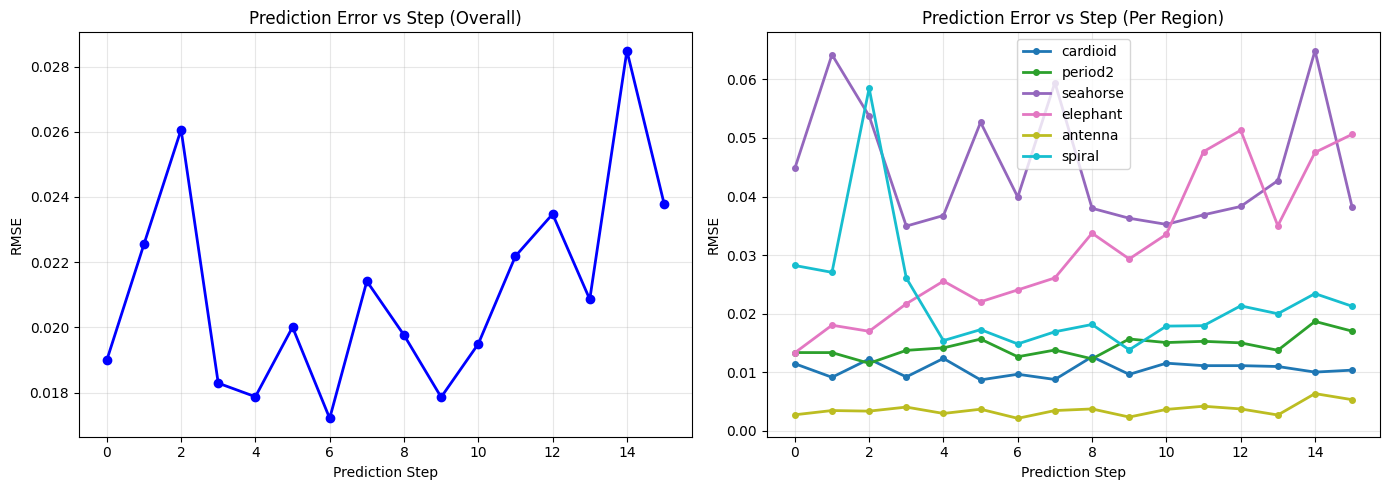

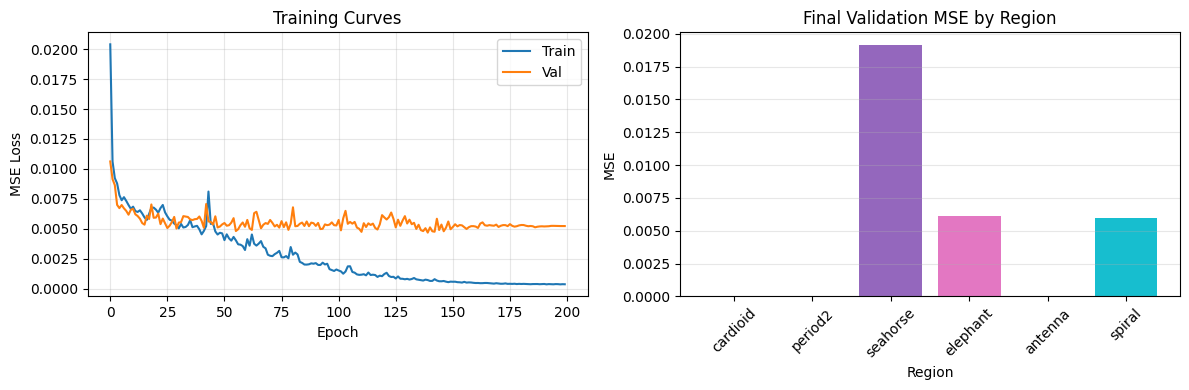


PREDICTION SUMMARY

Task: Predict 16 steps from 48 context steps
Best validation MSE: 0.004680
Best validation RMSE: 0.0684

Per-Region RMSE (lower = better prediction):
  antenna     : RMSE=0.0078 (chaotic/escaping)
  cardioid    : RMSE=0.0083 (bounded)
  period2     : RMSE=0.0109 (bounded)
  spiral      : RMSE=0.0791 (chaotic/escaping)
  elephant    : RMSE=0.0818 (chaotic/escaping)
  seahorse    : RMSE=0.1220 (chaotic/escaping)

Step-wise error growth:
  Step 1 RMSE: 0.1378
  Step 8 RMSE: 0.1463
  Step 16 RMSE: 0.1543
  Growth factor (16/1): 1.12x



In [5]:
# ============================================================================
# FractalBEANS: Orbit Prediction System
# ============================================================================
# Task: Given orbit [0:T-k], predict next k steps [T-k:T]
#
# This tests if the model learned actual dynamics, not just fingerprints.
# Can we predict where z goes next given its history?
# ============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Optional, Dict, List, Tuple
from dataclasses import dataclass
from tqdm.auto import tqdm

# geovocab2 imports
from geovocab2.shapes.factory.fractal_factory import (
    FractalFactory,
    FractalMode,
    create_orbit_dataset,
    get_region_names,
    FRACTAL_REGIONS
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

# ============================================================================
# Configuration
# ============================================================================

@dataclass
class PredictorConfig:
    """Configuration for orbit prediction."""
    # Model
    input_dim: int = 4           # [re, im, |z|, phase]
    output_dim: int = 2          # Predict [re, im] only (magnitude/phase derived)
    dim: int = 160               # Hidden dimension
    num_layers: int = 3          # Slightly deeper for prediction
    num_heads: int = 4
    num_experts: int = 5
    dropout: float = 0.1

    # Prediction task
    context_length: int = 48     # Input sequence length
    predict_steps: int = 16      # How many steps ahead to predict
    sequence_length: int = 64    # Total = context + predict

    # Data
    regions: Tuple[str, ...] = ('cardioid', 'period2', 'seahorse', 'elephant', 'antenna', 'spiral')
    train_samples: int = 6000
    val_samples: int = 600
    batch_size: int = 64

    # Training
    lr: float = 1e-3
    epochs: int = 200

    def __post_init__(self):
        assert self.context_length + self.predict_steps == self.sequence_length
        assert self.dim % self.num_experts == 0
        self.expert_dim = self.dim // self.num_experts

config = PredictorConfig()
print(f"Task: Given {config.context_length} steps, predict next {config.predict_steps}")
print(f"Regions: {config.regions}")

# ============================================================================
# Model: FractalPredictor
# ============================================================================

class ExpertSliceAttention(nn.Module):
    """Attention with expert-sliced value projections."""
    def __init__(self, dim: int, num_heads: int, num_experts: int, dropout: float = 0.1):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.num_experts = num_experts
        self.head_dim = dim // num_heads
        self.expert_dim = dim // num_experts

        self.q_proj = nn.Linear(dim, dim)
        self.k_proj = nn.Linear(dim, dim)
        self.v_projs = nn.ModuleList([
            nn.Linear(self.expert_dim, self.expert_dim)
            for _ in range(num_experts)
        ])
        self.out_proj = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)
        self.expert_norms: Optional[torch.Tensor] = None

    def forward(self, x: torch.Tensor, store_expert_info: bool = False) -> torch.Tensor:
        B, T, D = x.shape

        q = self.q_proj(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        v_slices = []
        expert_contributions = []

        for i, v_proj in enumerate(self.v_projs):
            start = i * self.expert_dim
            end = start + self.expert_dim
            x_slice = x[..., start:end]
            v_slice = v_proj(x_slice)
            v_slices.append(v_slice)

            if store_expert_info:
                expert_contributions.append(v_slice.norm(dim=-1).mean(dim=-1))

        v = torch.cat(v_slices, dim=-1)
        v = v.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        scale = self.head_dim ** -0.5
        attn = (q @ k.transpose(-2, -1)) * scale
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)

        out = (attn @ v).transpose(1, 2).reshape(B, T, D)
        out = self.out_proj(out)

        if store_expert_info:
            self.expert_norms = torch.stack(expert_contributions, dim=-1)

        return out


class PredictorBlock(nn.Module):
    """Transformer block for prediction."""
    def __init__(self, dim: int, num_heads: int, num_experts: int, dropout: float = 0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = ExpertSliceAttention(dim, num_heads, num_experts, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x: torch.Tensor, store_expert_info: bool = False) -> torch.Tensor:
        x = x + self.attn(self.norm1(x), store_expert_info=store_expert_info)
        x = x + self.ffn(self.norm2(x))
        return x


class FractalPredictor(nn.Module):
    """
    Predict future orbit positions from context.

    Input: [B, context_length, 4] - past orbit
    Output: [B, predict_steps, 2] - future (re, im) positions
    """
    def __init__(self, config: PredictorConfig):
        super().__init__()
        self.config = config

        # Input projection
        self.input_proj = nn.Linear(config.input_dim, config.dim)

        # Learnable position encoding
        self.pos_embed = nn.Parameter(
            torch.randn(1, config.context_length, config.dim) * 0.02
        )

        # Transformer layers
        self.layers = nn.ModuleList([
            PredictorBlock(config.dim, config.num_heads, config.num_experts, config.dropout)
            for _ in range(config.num_layers)
        ])

        self.norm = nn.LayerNorm(config.dim)

        # Prediction head: project to future steps
        # Use last token's representation to predict all future steps
        self.pred_head = nn.Sequential(
            nn.Linear(config.dim, config.dim * 2),
            nn.GELU(),
            nn.Linear(config.dim * 2, config.predict_steps * config.output_dim)
        )

        self._store_expert_info = False

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: [B, context_length, 4] - input orbit context
        Returns:
            [B, predict_steps, 2] - predicted (re, im) for future steps
        """
        B, T, _ = x.shape

        x = self.input_proj(x)
        x = x + self.pos_embed[:, :T, :]

        for layer in self.layers:
            x = layer(x, store_expert_info=self._store_expert_info)

        x = self.norm(x)

        # Use last token for prediction (contains full context)
        last_token = x[:, -1, :]  # [B, dim]

        # Predict future steps
        pred = self.pred_head(last_token)  # [B, predict_steps * output_dim]
        pred = pred.view(B, self.config.predict_steps, self.config.output_dim)

        return pred

    def get_expert_activations(self) -> Dict[int, torch.Tensor]:
        activations = {}
        for i, layer in enumerate(self.layers):
            if layer.attn.expert_norms is not None:
                activations[i] = layer.attn.expert_norms
        return activations

    def enable_expert_tracking(self):
        self._store_expert_info = True

    def disable_expert_tracking(self):
        self._store_expert_info = False

# Test model
model = FractalPredictor(config).to(device)
dummy = torch.randn(4, config.context_length, 4).to(device)
out = model(dummy)
print(f"Input shape: {dummy.shape}")
print(f"Output shape: {out.shape}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

# ============================================================================
# Dataset for Prediction
# ============================================================================

class OrbitPredictionDataset(Dataset):
    """Dataset that splits orbits into context/target."""

    def __init__(
        self,
        num_samples: int,
        sequence_length: int,
        context_length: int,
        regions: List[str],
        seed: int = 42
    ):
        self.context_length = context_length
        self.predict_steps = sequence_length - context_length
        self.regions = regions
        self.region_to_idx = {r: i for i, r in enumerate(regions)}

        print(f"Generating {num_samples} orbits...")
        self.data, self.metadata = create_orbit_dataset(
            num_samples=num_samples,
            sequence_length=sequence_length,
            regions=regions,
            seed=seed,
            backend='numpy'
        )

        self.data = torch.from_numpy(self.data).float()
        self.labels = torch.tensor([self.region_to_idx[m['region']] for m in self.metadata])

        print(f"Dataset: {len(self)} samples")
        print(f"Context: {context_length}, Predict: {self.predict_steps}")

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, int]:
        orbit = self.data[idx]

        # Split into context and target
        context = orbit[:self.context_length]  # [context_len, 4]
        target = orbit[self.context_length:, :2]  # [predict_steps, 2] - only (re, im)

        region_idx = self.labels[idx]

        return context, target, region_idx

# Create datasets
train_dataset = OrbitPredictionDataset(
    config.train_samples, config.sequence_length,
    config.context_length, list(config.regions), seed=42
)
val_dataset = OrbitPredictionDataset(
    config.val_samples, config.sequence_length,
    config.context_length, list(config.regions), seed=123
)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

# ============================================================================
# Training
# ============================================================================

def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    total_samples = 0

    for context, target, _ in loader:
        context, target = context.to(device), target.to(device)

        optimizer.zero_grad()
        pred = model(context)

        # MSE loss on predicted (re, im)
        loss = F.mse_loss(pred, target)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item() * context.size(0)
        total_samples += context.size(0)

    return total_loss / total_samples

@torch.no_grad()
def eval_epoch(model, loader, device):
    model.eval()
    total_loss = 0
    total_samples = 0

    # Per-region losses
    region_losses = defaultdict(list)

    for context, target, region_idx in loader:
        context, target = context.to(device), target.to(device)

        pred = model(context)

        # Per-sample loss
        sample_losses = ((pred - target) ** 2).mean(dim=(1, 2))  # [B]

        for i, (loss, reg) in enumerate(zip(sample_losses, region_idx)):
            region_losses[reg.item()].append(loss.item())

        total_loss += sample_losses.sum().item()
        total_samples += context.size(0)

    # Aggregate per-region
    region_mse = {r: np.mean(losses) for r, losses in region_losses.items()}

    return total_loss / total_samples, region_mse

# Initialize
model = FractalPredictor(config).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.epochs)

history = {'train_loss': [], 'val_loss': [], 'region_mse': []}

print(f"\nTraining FractalPredictor for {config.epochs} epochs...")
print(f"Model: {config.dim}d, {config.num_layers}L, {config.num_experts} experts")
print("-" * 70)

best_val_loss = float('inf')
for epoch in range(config.epochs):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_loss, region_mse = eval_epoch(model, val_loader, device)
    scheduler.step()

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['region_mse'].append(region_mse)

    best_marker = ""
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_marker = " ★"
        best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d} | Train MSE: {train_loss:.6f} | Val MSE: {val_loss:.6f}{best_marker}")

print("-" * 70)
print(f"Best validation MSE: {best_val_loss:.6f}")

# Load best model
model.load_state_dict(best_model_state)

# ============================================================================
# Evaluation: Per-Region Analysis
# ============================================================================

print("\n" + "=" * 70)
print("PER-REGION PREDICTION ERROR")
print("=" * 70)

val_loss, region_mse = eval_epoch(model, val_loader, device)
idx_to_region = {i: r for i, r in enumerate(config.regions)}

for reg_idx in sorted(region_mse.keys()):
    region = idx_to_region[reg_idx]
    mse = region_mse[reg_idx]
    rmse = np.sqrt(mse)
    print(f"  {region:12s}: MSE={mse:.6f}, RMSE={rmse:.4f}")

# ============================================================================
# Visualization: Prediction Samples
# ============================================================================

@torch.no_grad()
def visualize_predictions(model, dataset, device, num_samples=2):
    """Visualize predicted vs actual orbits."""
    model.eval()

    fig, axes = plt.subplots(len(config.regions), num_samples, figsize=(5*num_samples, 4*len(config.regions)))

    for reg_idx, region in enumerate(config.regions):
        # Find samples from this region
        region_indices = [i for i, m in enumerate(dataset.metadata) if m['region'] == region]

        for col in range(min(num_samples, len(region_indices))):
            idx = region_indices[col]

            context, target, _ = dataset[idx]
            context = context.unsqueeze(0).to(device)

            pred = model(context).squeeze(0).cpu().numpy()
            target = target.numpy()
            full_orbit = dataset.data[idx].numpy()

            ax = axes[reg_idx, col] if len(config.regions) > 1 else axes[col]

            # Plot full context orbit
            ax.plot(full_orbit[:config.context_length, 0],
                   full_orbit[:config.context_length, 1],
                   'b-', alpha=0.5, linewidth=1, label='Context')

            # Plot actual future
            ax.plot(target[:, 0], target[:, 1],
                   'g-', linewidth=2, label='Actual')
            ax.scatter(target[-1, 0], target[-1, 1], c='green', s=50, zorder=5)

            # Plot predicted future
            ax.plot(pred[:, 0], pred[:, 1],
                   'r--', linewidth=2, label='Predicted')
            ax.scatter(pred[-1, 0], pred[-1, 1], c='red', s=50, zorder=5, marker='x')

            # Connect context to predictions
            ax.plot([full_orbit[config.context_length-1, 0], target[0, 0]],
                   [full_orbit[config.context_length-1, 1], target[0, 1]],
                   'g-', linewidth=2)
            ax.plot([full_orbit[config.context_length-1, 0], pred[0, 0]],
                   [full_orbit[config.context_length-1, 1], pred[0, 1]],
                   'r--', linewidth=2)

            ax.set_title(f'{region}')
            ax.set_xlabel('Re(z)')
            ax.set_ylabel('Im(z)')
            ax.grid(True, alpha=0.3)
            ax.set_aspect('equal')

            if col == 0:
                ax.legend(fontsize=8)

    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_dataset, device, num_samples=3)

# ============================================================================
# Step-by-Step Error Analysis
# ============================================================================

@torch.no_grad()
def analyze_step_errors(model, loader, device, config):
    """Analyze prediction error at each future step."""
    model.eval()

    step_errors = defaultdict(list)  # step_idx -> list of errors
    region_step_errors = defaultdict(lambda: defaultdict(list))  # region -> step -> errors

    idx_to_region = {i: r for i, r in enumerate(config.regions)}

    for context, target, region_idx in loader:
        context, target = context.to(device), target.to(device)

        pred = model(context)

        # Per-step error
        for step in range(config.predict_steps):
            step_error = ((pred[:, step, :] - target[:, step, :]) ** 2).sum(dim=-1).sqrt()  # [B]

            for i, (err, reg) in enumerate(zip(step_error, region_idx)):
                step_errors[step].append(err.item())
                region_step_errors[idx_to_region[reg.item()]][step].append(err.item())

    # Aggregate
    mean_step_error = {s: np.mean(errs) for s, errs in step_errors.items()}

    return mean_step_error, region_step_errors

mean_step_error, region_step_errors = analyze_step_errors(model, val_loader, device, config)

# Plot step-by-step error
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall step error
steps = list(range(config.predict_steps))
errors = [mean_step_error[s] for s in steps]

axes[0].plot(steps, errors, 'b-o', linewidth=2, markersize=6)
axes[0].set_xlabel('Prediction Step')
axes[0].set_ylabel('RMSE')
axes[0].set_title('Prediction Error vs Step (Overall)')
axes[0].grid(True, alpha=0.3)

# Per-region step error
colors = plt.cm.tab10(np.linspace(0, 1, len(config.regions)))
for reg_idx, region in enumerate(config.regions):
    if region in region_step_errors:
        errors = [np.mean(region_step_errors[region][s]) for s in steps]
        axes[1].plot(steps, errors, '-o', label=region, color=colors[reg_idx], linewidth=2, markersize=4)

axes[1].set_xlabel('Prediction Step')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Prediction Error vs Step (Per Region)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# Training Curves
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Val')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Training Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Per-region MSE over training (last checkpoint)
final_region_mse = history['region_mse'][-1]
regions = [idx_to_region[i] for i in sorted(final_region_mse.keys())]
mses = [final_region_mse[i] for i in sorted(final_region_mse.keys())]

axes[1].bar(regions, mses, color=colors[:len(regions)])
axes[1].set_xlabel('Region')
axes[1].set_ylabel('MSE')
axes[1].set_title('Final Validation MSE by Region')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ============================================================================
# Summary
# ============================================================================

print("\n" + "=" * 70)
print("PREDICTION SUMMARY")
print("=" * 70)

print(f"\nTask: Predict {config.predict_steps} steps from {config.context_length} context steps")
print(f"Best validation MSE: {best_val_loss:.6f}")
print(f"Best validation RMSE: {np.sqrt(best_val_loss):.4f}")

print("\nPer-Region RMSE (lower = better prediction):")
sorted_regions = sorted(region_mse.items(), key=lambda x: x[1])
for reg_idx, mse in sorted_regions:
    region = idx_to_region[reg_idx]
    behavior = "bounded" if region in ['cardioid', 'period2'] else "chaotic/escaping"
    print(f"  {region:12s}: RMSE={np.sqrt(mse):.4f} ({behavior})")

print("\nStep-wise error growth:")
print(f"  Step 1 RMSE: {np.sqrt(mean_step_error[0]):.4f}")
print(f"  Step 8 RMSE: {np.sqrt(mean_step_error[7]):.4f}")
print(f"  Step 16 RMSE: {np.sqrt(mean_step_error[15]):.4f}")
print(f"  Growth factor (16/1): {np.sqrt(mean_step_error[15]) / np.sqrt(mean_step_error[0]):.2f}x")

print("\n" + "=" * 70)

# mnist

Device: cuda
Patches: 16 (4x4)
Expert slice dim: 32
Model output shape: torch.Size([4, 10])
Parameters: 568,202


100%|██████████| 9.91M/9.91M [00:00<00:00, 56.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.63MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.4MB/s]

Train samples: 60000
Test samples: 10000

Training ExpertViT for 30 epochs...
Model: 128d, 3L, 4 experts
------------------------------------------------------------


Epoch   1 | Train: 0.5698 / 81.24% | Test: 0.1785 / 94.60% ★
Epoch   5 | Train: 0.0834 / 97.30% | Test: 0.0718 / 97.95% ★
Epoch  10 | Train: 0.0451 / 98.51% | Test: 0.0685 / 97.96%
Epoch  15 | Train: 0.0219 / 99.27% | Test: 0.0535 / 98.47%
Epoch  20 | Train: 0.0095 / 99.69% | Test: 0.0494 / 98.65%
Epoch  25 | Train: 0.0032 / 99.91% | Test: 0.0443 / 98.99%
Epoch  30 | Train: 0.0017 / 99.95% | Test: 0.0419 / 99.09%
------------------------------------------------------------
Best test accuracy: 99.09%

Expert Activation Analysis (per digit)
Digit 0: [3.88 4.39 5.23 3.95] → E2
Digit 1: [4.63 4.49 4.39 4.97] → E3
Digit 2: [4.41 4.78 4.85 4.61] → E2
Digit 3: [4.19 6.64 4.61 4.33] → E1
Digit 4: [5.74 4.03 4.95 4.19] → E0
Digit 5: [4.47 5.03 4.67 4.84] → E1
Digit 6: [4.96 4.10 5.30 4.49] → E2
Digit 7: [5.06 5.18 4.35 4.46] → E1
Digit 8: [3.87 4.84 4.89 4.09] → E2
Digit 9: [4.35 4.31 4.48 4.65] → E3


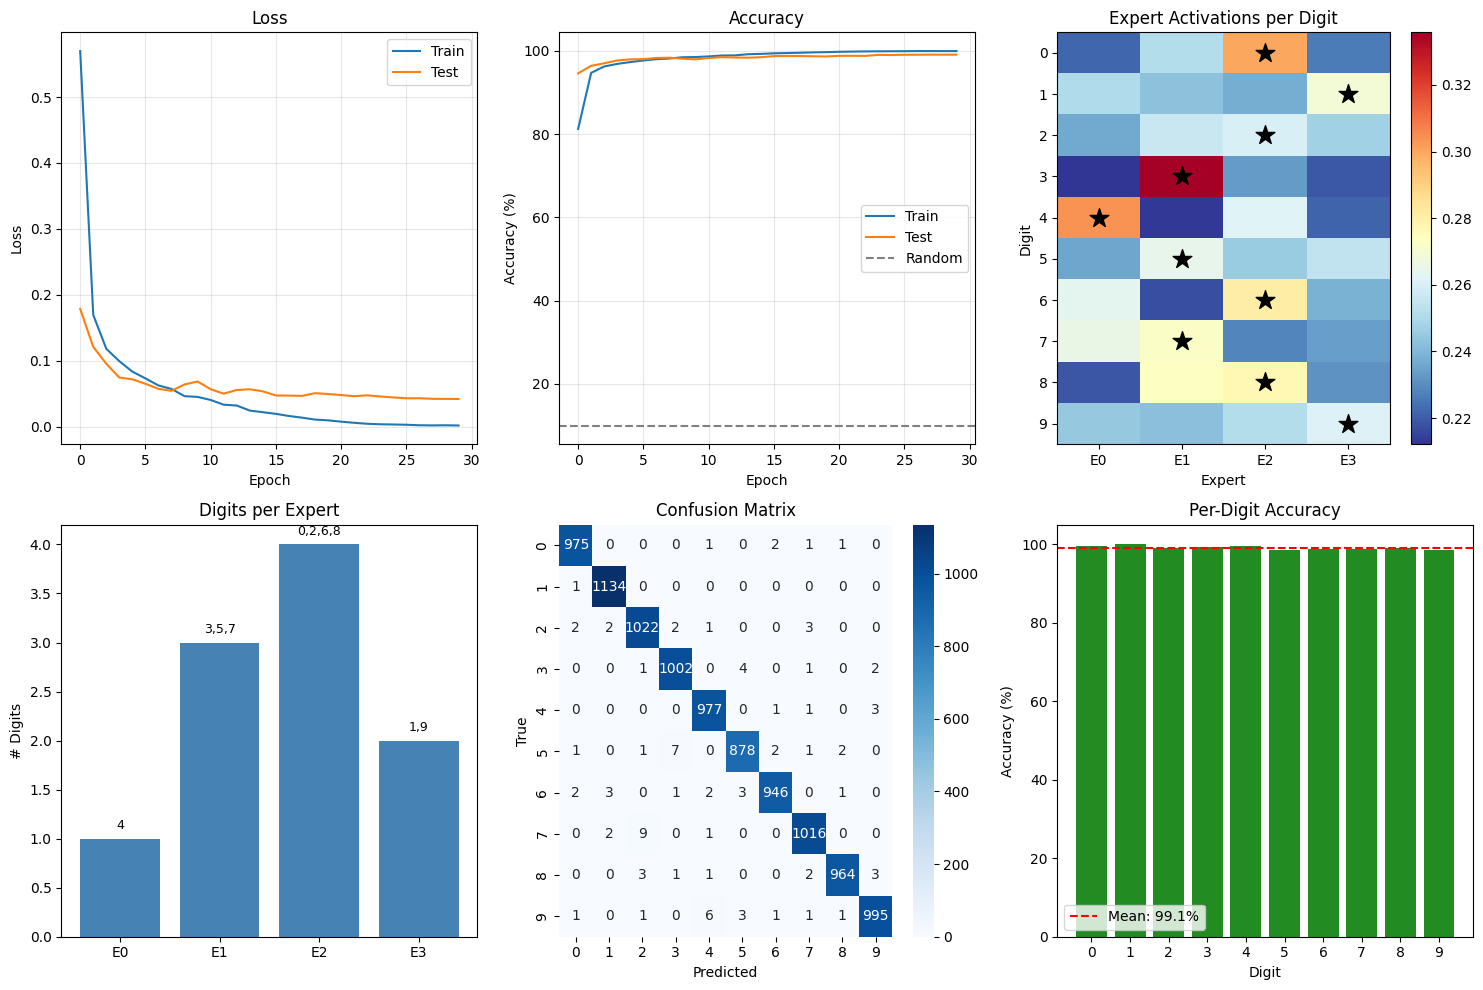


EXPERT-MNIST SUMMARY

Test Accuracy: 99.09%

Dominant Expert → Digits:
  Expert 0: 4
  Expert 1: 3, 5, 7
  Expert 2: 0, 2, 6, 8
  Expert 3: 1, 9

Active experts: 4/4

Potential Semantic Groupings:
  Round digits {0, 8, 6, 9} → Experts {2, 3}
  Straight digits {1, 4, 7} → Experts {0, 1, 3}
  Complex digits {2, 3, 5} → Experts {1, 2}


In [7]:
# ============================================================================
# ExpertMNIST: Testing Geometric Theta on Classic Benchmark
# ============================================================================
# Question: Do expert slices learn meaningful digit features?
#
# Approach: Patch MNIST images → Expert-sliced ViT → Classify digits
# Probe: Which experts activate for which digits?
# ============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Optional, Dict, List, Tuple
from dataclasses import dataclass
from tqdm.auto import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

# ============================================================================
# Configuration
# ============================================================================

@dataclass
class MNISTConfig:
    """Configuration for MNIST experiment."""
    # Image
    image_size: int = 28
    patch_size: int = 7          # 28/7 = 4x4 = 16 patches
    in_channels: int = 1
    num_classes: int = 10

    # Model
    dim: int = 128               # Hidden dimension
    num_layers: int = 3
    num_heads: int = 4
    num_experts: int = 4         # Test: does 5 or 10 work better?
    dropout: float = 0.1

    # Training
    batch_size: int = 128
    lr: float = 1e-3
    epochs: int = 30

    def __post_init__(self):
        assert self.dim % self.num_experts == 0, f"dim must be divisible by num_experts"
        self.expert_dim = self.dim // self.num_experts
        self.num_patches = (self.image_size // self.patch_size) ** 2
        self.patch_dim = self.patch_size * self.patch_size * self.in_channels

config = MNISTConfig()
print(f"Patches: {config.num_patches} ({config.image_size//config.patch_size}x{config.image_size//config.patch_size})")
print(f"Expert slice dim: {config.expert_dim}")

# ============================================================================
# Model Components
# ============================================================================

class PatchEmbed(nn.Module):
    """Convert image to patch embeddings."""

    def __init__(self, image_size: int, patch_size: int, in_channels: int, embed_dim: int):
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, C, H, W] -> [B, num_patches, embed_dim]
        x = self.proj(x)  # [B, embed_dim, H/P, W/P]
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, embed_dim]
        return x


class ExpertSliceAttention(nn.Module):
    """Attention with expert-sliced value projections."""

    def __init__(self, dim: int, num_heads: int, num_experts: int, dropout: float = 0.1):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.num_experts = num_experts
        self.head_dim = dim // num_heads
        self.expert_dim = dim // num_experts

        self.q_proj = nn.Linear(dim, dim)
        self.k_proj = nn.Linear(dim, dim)
        self.v_projs = nn.ModuleList([
            nn.Linear(self.expert_dim, self.expert_dim)
            for _ in range(num_experts)
        ])
        self.out_proj = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)
        self.expert_norms: Optional[torch.Tensor] = None

    def forward(self, x: torch.Tensor, store_expert_info: bool = False) -> torch.Tensor:
        B, T, D = x.shape

        q = self.q_proj(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        v_slices = []
        expert_contributions = []

        for i, v_proj in enumerate(self.v_projs):
            start = i * self.expert_dim
            end = start + self.expert_dim
            v_slice = v_proj(x[..., start:end])
            v_slices.append(v_slice)

            if store_expert_info:
                expert_contributions.append(v_slice.norm(dim=-1).mean(dim=-1))

        v = torch.cat(v_slices, dim=-1)
        v = v.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        scale = self.head_dim ** -0.5
        attn = (q @ k.transpose(-2, -1)) * scale
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)

        out = (attn @ v).transpose(1, 2).reshape(B, T, D)
        out = self.out_proj(out)

        if store_expert_info:
            self.expert_norms = torch.stack(expert_contributions, dim=-1)

        return out


class ExpertBlock(nn.Module):
    """Transformer block with expert-sliced attention."""

    def __init__(self, dim: int, num_heads: int, num_experts: int, dropout: float = 0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = ExpertSliceAttention(dim, num_heads, num_experts, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x: torch.Tensor, store_expert_info: bool = False) -> torch.Tensor:
        x = x + self.attn(self.norm1(x), store_expert_info=store_expert_info)
        x = x + self.ffn(self.norm2(x))
        return x


class ExpertViT(nn.Module):
    """Vision Transformer with expert-sliced attention for MNIST."""

    def __init__(self, config: MNISTConfig):
        super().__init__()
        self.config = config

        # Patch embedding
        self.patch_embed = PatchEmbed(
            config.image_size,
            config.patch_size,
            config.in_channels,
            config.dim
        )

        # CLS token
        self.cls_token = nn.Parameter(torch.randn(1, 1, config.dim) * 0.02)

        # Positional embedding
        self.pos_embed = nn.Parameter(
            torch.randn(1, config.num_patches + 1, config.dim) * 0.02
        )

        # Transformer layers
        self.layers = nn.ModuleList([
            ExpertBlock(config.dim, config.num_heads, config.num_experts, config.dropout)
            for _ in range(config.num_layers)
        ])

        self.norm = nn.LayerNorm(config.dim)
        self.head = nn.Linear(config.dim, config.num_classes)
        self._store_expert_info = False

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B = x.size(0)

        # Patch embedding
        x = self.patch_embed(x)  # [B, num_patches, dim]

        # Add CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)  # [B, num_patches+1, dim]

        # Add positional embedding
        x = x + self.pos_embed

        # Transformer layers
        for layer in self.layers:
            x = layer(x, store_expert_info=self._store_expert_info)

        # Classify from CLS token
        x = self.norm(x)
        cls_output = x[:, 0]
        return self.head(cls_output)

    def get_expert_activations(self) -> Dict[int, torch.Tensor]:
        activations = {}
        for i, layer in enumerate(self.layers):
            if layer.attn.expert_norms is not None:
                activations[i] = layer.attn.expert_norms
        return activations

    def enable_expert_tracking(self):
        self._store_expert_info = True

    def disable_expert_tracking(self):
        self._store_expert_info = False

# Test model
model = ExpertViT(config).to(device)
dummy = torch.randn(4, 1, 28, 28).to(device)
out = model(dummy)
print(f"Model output shape: {out.shape}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

# ============================================================================
# Data
# ============================================================================

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# ============================================================================
# Training
# ============================================================================

def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        correct += (logits.argmax(dim=-1) == labels).sum().item()
        total += images.size(0)

    return total_loss / total, correct / total


@torch.no_grad()
def eval_epoch(model, loader, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        logits = model(images)
        loss = F.cross_entropy(logits, labels)

        total_loss += loss.item() * images.size(0)
        correct += (logits.argmax(dim=-1) == labels).sum().item()
        total += images.size(0)

    return total_loss / total, correct / total


# Initialize
model = ExpertViT(config).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.epochs)

history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

print(f"\nTraining ExpertViT for {config.epochs} epochs...")
print(f"Model: {config.dim}d, {config.num_layers}L, {config.num_experts} experts")
print("-" * 60)

best_test_acc = 0
for epoch in range(config.epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    test_loss, test_acc = eval_epoch(model, test_loader, device)
    scheduler.step()

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)

    best_marker = " ★" if test_acc > best_test_acc else ""
    if test_acc > best_test_acc:
        best_test_acc = test_acc

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d} | Train: {train_loss:.4f} / {train_acc*100:.2f}% | "
              f"Test: {test_loss:.4f} / {test_acc*100:.2f}%{best_marker}")

print("-" * 60)
print(f"Best test accuracy: {best_test_acc*100:.2f}%")

# ============================================================================
# Expert Activation Analysis
# ============================================================================

@torch.no_grad()
def analyze_expert_activations(model, loader, device, num_classes=10):
    """Analyze which experts activate for which digits."""
    model.eval()
    model.enable_expert_tracking()

    digit_activations = defaultdict(list)

    for images, labels in loader:
        images = images.to(device)
        _ = model(images)

        activations = model.get_expert_activations()
        last_layer_idx = max(activations.keys())
        expert_norms = activations[last_layer_idx].cpu()  # [B, num_experts]

        for i, label in enumerate(labels):
            digit_activations[label.item()].append(expert_norms[i])

    model.disable_expert_tracking()

    stats = {}
    for digit in range(num_classes):
        if digit in digit_activations:
            acts = torch.stack(digit_activations[digit])
            stats[digit] = {
                'mean': acts.mean(dim=0).numpy(),
                'std': acts.std(dim=0).numpy(),
                'dominant_expert': acts.mean(dim=0).argmax().item()
            }

    return stats

expert_stats = analyze_expert_activations(model, test_loader, device)

print("\nExpert Activation Analysis (per digit)")
print("=" * 60)
for digit in range(10):
    stats = expert_stats[digit]
    dominant = stats['dominant_expert']
    mean_str = ' '.join([f"{m:.2f}" for m in stats['mean']])
    print(f"Digit {digit}: [{mean_str}] → E{dominant}")

# ============================================================================
# Visualization
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Training curves
axes[0, 0].plot(history['train_loss'], label='Train')
axes[0, 0].plot(history['test_loss'], label='Test')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot([a*100 for a in history['train_acc']], label='Train')
axes[0, 1].plot([a*100 for a in history['test_acc']], label='Test')
axes[0, 1].axhline(y=10, color='gray', linestyle='--', label='Random')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Expert heatmap
matrix = np.zeros((10, config.num_experts))
for digit in range(10):
    matrix[digit] = expert_stats[digit]['mean']

matrix_norm = matrix / (matrix.sum(axis=1, keepdims=True) + 1e-8)

im = axes[0, 2].imshow(matrix_norm, aspect='auto', cmap='RdYlBu_r')
axes[0, 2].set_xticks(range(config.num_experts))
axes[0, 2].set_xticklabels([f'E{i}' for i in range(config.num_experts)])
axes[0, 2].set_yticks(range(10))
axes[0, 2].set_yticklabels([str(d) for d in range(10)])
axes[0, 2].set_xlabel('Expert')
axes[0, 2].set_ylabel('Digit')
axes[0, 2].set_title('Expert Activations per Digit')
plt.colorbar(im, ax=axes[0, 2])

# Mark dominant experts
for digit in range(10):
    dom = expert_stats[digit]['dominant_expert']
    axes[0, 2].scatter(dom, digit, marker='*', s=200, c='black', zorder=10)

# Group digits by dominant expert
expert_to_digits = defaultdict(list)
for digit, stats in expert_stats.items():
    expert_to_digits[stats['dominant_expert']].append(digit)

axes[1, 0].set_title('Digits per Expert')
expert_counts = [len(expert_to_digits.get(e, [])) for e in range(config.num_experts)]
bars = axes[1, 0].bar(range(config.num_experts), expert_counts, color='steelblue')
axes[1, 0].set_xticks(range(config.num_experts))
axes[1, 0].set_xticklabels([f'E{i}' for i in range(config.num_experts)])
axes[1, 0].set_ylabel('# Digits')

# Annotate with digit lists
for e in range(config.num_experts):
    digits = expert_to_digits.get(e, [])
    if digits:
        axes[1, 0].annotate(
            ','.join(map(str, digits)),
            (e, len(digits) + 0.1),
            ha='center', fontsize=9
        )

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

@torch.no_grad()
def get_predictions(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    for images, labels in loader:
        images = images.to(device)
        preds = model(images).argmax(dim=-1).cpu()
        all_preds.append(preds)
        all_labels.append(labels)
    return torch.cat(all_preds).numpy(), torch.cat(all_labels).numpy()

preds, labels = get_predictions(model, test_loader, device)
cm = confusion_matrix(labels, preds)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('True')
axes[1, 1].set_title('Confusion Matrix')

# Per-digit accuracy
per_digit_acc = []
for d in range(10):
    mask = labels == d
    acc = (preds[mask] == d).mean() * 100
    per_digit_acc.append(acc)

axes[1, 2].bar(range(10), per_digit_acc, color='forestgreen')
axes[1, 2].set_xticks(range(10))
axes[1, 2].set_xlabel('Digit')
axes[1, 2].set_ylabel('Accuracy (%)')
axes[1, 2].set_title('Per-Digit Accuracy')
axes[1, 2].axhline(y=np.mean(per_digit_acc), color='red', linestyle='--', label=f'Mean: {np.mean(per_digit_acc):.1f}%')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

# ============================================================================
# Summary
# ============================================================================

print("\n" + "=" * 70)
print("EXPERT-MNIST SUMMARY")
print("=" * 70)

print(f"\nTest Accuracy: {best_test_acc*100:.2f}%")

print("\nDominant Expert → Digits:")
for expert_idx in range(config.num_experts):
    digits = expert_to_digits.get(expert_idx, [])
    digits_str = ', '.join(map(str, digits)) if digits else '(none)'
    print(f"  Expert {expert_idx}: {digits_str}")

active_experts = sum(1 for e in range(config.num_experts) if expert_to_digits.get(e))
print(f"\nActive experts: {active_experts}/{config.num_experts}")

# Look for semantic groupings
print("\nPotential Semantic Groupings:")
round_digits = {0, 6, 8, 9}  # Digits with curves
straight_digits = {1, 4, 7}  # Digits with straight lines
complex_digits = {2, 3, 5}   # Mixed features

for name, digit_set in [('Round', round_digits), ('Straight', straight_digits), ('Complex', complex_digits)]:
    experts_used = set()
    for d in digit_set:
        experts_used.add(expert_stats[d]['dominant_expert'])
    print(f"  {name} digits {digit_set} → Experts {experts_used}")

print("=" * 70)

# soft fractal routing

Device: cuda
Soft routing with 5 learnable routes
Model output shape: torch.Size([4, 48, 2])
Parameters: 410,210
Generating 6000 orbits...
Dataset: 6000 samples
Generating 600 orbits...
Dataset: 600 samples

Training SoftRoutedPredictor for 100 epochs...
Cantor init: True
----------------------------------------------------------------------
Epoch   1 | Train: 0.138393 | Val: 0.026027 (ctx: 0.031578, pred: 0.014923) ★
Epoch  20 | Train: 0.010132 | Val: 0.008228 (ctx: 0.011369, pred: 0.001945)
Epoch  40 | Train: 0.007920 | Val: 0.008280 (ctx: 0.011706, pred: 0.001429)
Epoch  60 | Train: 0.006357 | Val: 0.005358 (ctx: 0.007767, pred: 0.000540) ★
Epoch  80 | Train: 0.005506 | Val: 0.005122 (ctx: 0.007617, pred: 0.000133) ★
Epoch 100 | Train: 0.005304 | Val: 0.005030 (ctx: 0.007472, pred: 0.000146)
----------------------------------------------------------------------
Best validation loss: 0.005003


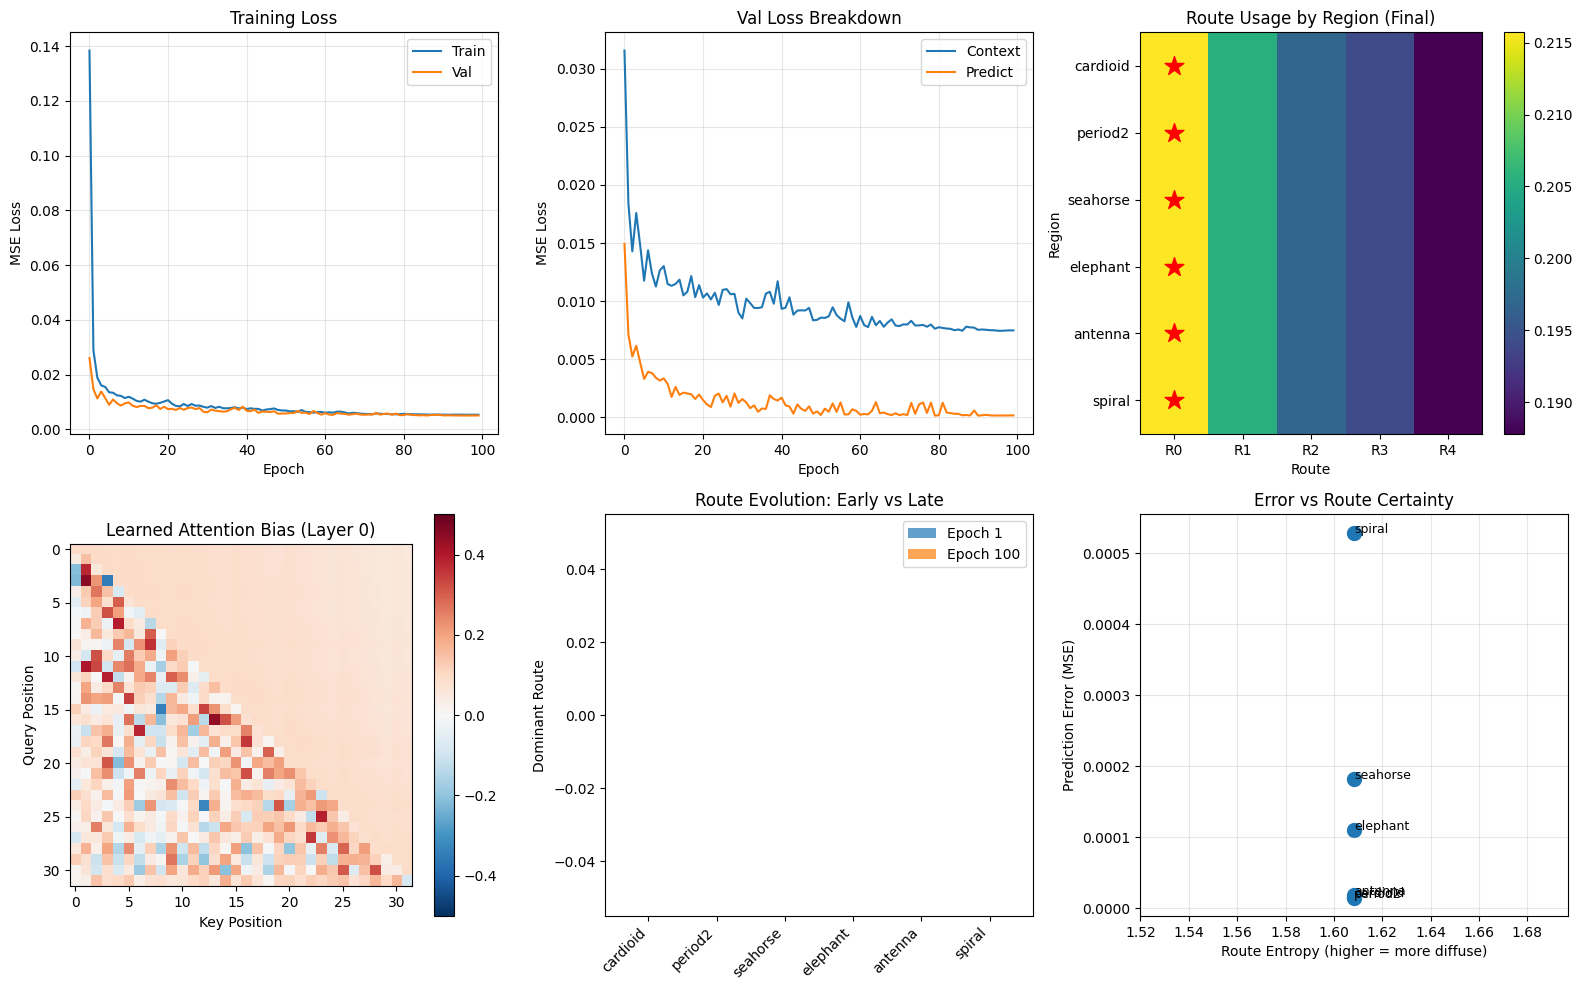


SOFT ROUTING SUMMARY

Best validation loss: 0.005003

Route Usage by Region (Final):
--------------------------------------------------
cardioid     | Routes: [0.22 0.21 0.20 0.19 0.19] | Dom: R0 | Err: 0.000017
period2      | Routes: [0.22 0.21 0.20 0.19 0.19] | Dom: R0 | Err: 0.000015
seahorse     | Routes: [0.22 0.21 0.20 0.19 0.19] | Dom: R0 | Err: 0.000182
elephant     | Routes: [0.22 0.21 0.20 0.19 0.19] | Dom: R0 | Err: 0.000111
antenna      | Routes: [0.22 0.21 0.20 0.19 0.19] | Dom: R0 | Err: 0.000019
spiral       | Routes: [0.22 0.21 0.20 0.19 0.19] | Dom: R0 | Err: 0.000529

Dominant Route → Regions:
  Route 0: cardioid, period2, seahorse, elephant, antenna, spiral
  Route 1: (none)
  Route 2: (none)
  Route 3: (none)
  Route 4: (none)

Easy regions {'period2', 'cardioid', 'antenna'} → Routes {np.int64(0)}
Hard regions {'seahorse', 'spiral', 'elephant'} → Routes {np.int64(0)}
○ Routes shared between easy/hard (expected with soft routing)


In [8]:
# ============================================================================
# Soft Fractal Routing: Loss-Guided Attention Alignment
# ============================================================================
# Hypothesis: Prediction difficulty creates natural routing pressure.
#
# Instead of hard-coding Cantor routes, we:
#   1. Initialize attention with soft fractal bias (learnable)
#   2. Let prediction loss strengthen "easy" routes
#   3. Track whether attention converges to Cantor-like patterns
#
# The fractal difficulty hierarchy should emerge naturally:
#   Easy (antenna, cardioid) → strong, stable routes
#   Hard (seahorse, spiral) → diffuse, uncertain routes
# ============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Optional, Dict, List, Tuple
from dataclasses import dataclass
import math

# geovocab2 imports
from geovocab2.shapes.factory.fractal_factory import (
    FractalFactory,
    FractalMode,
    create_orbit_dataset,
    get_region_names,
    FRACTAL_REGIONS
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

# ============================================================================
# Configuration
# ============================================================================

@dataclass
class SoftRoutingConfig:
    """Configuration for soft fractal routing experiment."""
    # Model
    input_dim: int = 4
    dim: int = 128
    num_layers: int = 2
    num_heads: int = 4
    dropout: float = 0.1

    # Soft routing
    num_routes: int = 5          # Learnable route embeddings
    route_temp: float = 1.0      # Softmax temperature for route selection
    use_cantor_init: bool = True # Initialize with Cantor structure

    # Task
    context_length: int = 32
    predict_length: int = 16
    sequence_length: int = 48

    # Data
    regions: Tuple[str, ...] = ('cardioid', 'period2', 'seahorse', 'elephant', 'antenna', 'spiral')
    train_samples: int = 6000
    val_samples: int = 600
    batch_size: int = 64

    # Training
    lr: float = 1e-3
    epochs: int = 100

    def __post_init__(self):
        self.sequence_length = self.context_length + self.predict_length

config = SoftRoutingConfig()
print(f"Soft routing with {config.num_routes} learnable routes")

# ============================================================================
# Cantor-based initialization (soft prior)
# ============================================================================

def cantor_pair(x: int, y: int) -> int:
    """Classic Cantor pairing function."""
    s = x + y
    return (s * (s + 1)) // 2 + y

def create_cantor_bias(seq_len: int, num_routes: int) -> torch.Tensor:
    """
    Create soft Cantor-based attention bias.

    Returns: [seq_len, seq_len] matrix with Cantor structure
    """
    # Generate Cantor fingerprints for each position
    fingerprints = np.array([cantor_pair(i, i % num_routes) for i in range(seq_len)])

    # Normalize to [0, 1]
    fingerprints = (fingerprints - fingerprints.min()) / (fingerprints.max() - fingerprints.min() + 1e-8)

    # Create distance-based bias (closer Cantor values = stronger connection)
    bias = np.abs(fingerprints[:, None] - fingerprints[None, :])
    bias = 1.0 - bias  # Invert so similar = high

    return torch.from_numpy(bias).float()

def create_route_embeddings(seq_len: int, num_routes: int, dim: int) -> torch.Tensor:
    """
    Create initial route embeddings based on Cantor structure.

    Each position gets a soft mixture over routes based on its Cantor fingerprint.
    """
    # Position-to-route affinity based on Cantor
    affinities = torch.zeros(seq_len, num_routes)

    for i in range(seq_len):
        # Cantor fingerprint determines primary route
        fp = cantor_pair(i, 0) % num_routes

        # Soft assignment with neighbors
        for r in range(num_routes):
            dist = abs(r - fp)
            affinities[i, r] = math.exp(-dist / 2.0)

    # Normalize
    affinities = affinities / affinities.sum(dim=-1, keepdim=True)

    return affinities

# ============================================================================
# Soft-Routed Attention
# ============================================================================

class SoftRoutedAttention(nn.Module):
    """
    Attention with learnable soft routing.

    Instead of hard expert slices, we learn:
    - Route embeddings that positions can attend to
    - Position-route affinities that modulate attention

    The routing is fully differentiable and learned from loss.
    """

    def __init__(
        self,
        dim: int,
        num_heads: int,
        num_routes: int,
        max_seq_len: int,
        dropout: float = 0.1,
        use_cantor_init: bool = True,
        route_temp: float = 1.0
    ):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.num_routes = num_routes
        self.head_dim = dim // num_heads
        self.route_temp = route_temp

        # Standard QKV
        self.q_proj = nn.Linear(dim, dim)
        self.k_proj = nn.Linear(dim, dim)
        self.v_proj = nn.Linear(dim, dim)
        self.out_proj = nn.Linear(dim, dim)

        # Learnable route embeddings [num_routes, dim]
        self.route_embeds = nn.Parameter(torch.randn(num_routes, dim) * 0.02)

        # Position-to-route affinity (learnable, initialized with Cantor)
        if use_cantor_init:
            init_affinity = create_route_embeddings(max_seq_len, num_routes, dim)
        else:
            init_affinity = torch.ones(max_seq_len, num_routes) / num_routes

        self.position_route_affinity = nn.Parameter(init_affinity)

        # Learnable attention bias (initialized with Cantor structure)
        if use_cantor_init:
            init_bias = create_cantor_bias(max_seq_len, num_routes) * 0.1
        else:
            init_bias = torch.zeros(max_seq_len, max_seq_len)

        self.attn_bias = nn.Parameter(init_bias)

        self.dropout = nn.Dropout(dropout)

        # For analysis
        self.route_weights: Optional[torch.Tensor] = None
        self.attn_weights: Optional[torch.Tensor] = None

    def forward(self, x: torch.Tensor, store_routing: bool = False) -> torch.Tensor:
        B, T, D = x.shape

        # Compute route weights for each position (soft selection)
        route_logits = self.position_route_affinity[:T]  # [T, num_routes]
        route_weights = F.softmax(route_logits / self.route_temp, dim=-1)  # [T, num_routes]

        if store_routing:
            self.route_weights = route_weights.detach()

        # Modulate input by routes
        # Each position's representation is a weighted sum over route-transformed features
        route_modulation = torch.einsum('tr,rd->td', route_weights, self.route_embeds)  # [T, D]
        x_routed = x + route_modulation.unsqueeze(0)  # [B, T, D] - broadcast add

        # Standard attention with learned bias
        q = self.q_proj(x_routed).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(x_routed).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(x_routed).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        # Attention with learnable bias
        scale = self.head_dim ** -0.5
        attn = (q @ k.transpose(-2, -1)) * scale

        # Add learnable bias (Cantor-initialized)
        attn = attn + self.attn_bias[:T, :T].unsqueeze(0).unsqueeze(0)

        # Causal mask
        causal_mask = torch.triu(torch.ones(T, T, device=x.device), diagonal=1).bool()
        attn = attn.masked_fill(causal_mask.unsqueeze(0).unsqueeze(0), float('-inf'))

        attn = F.softmax(attn, dim=-1)

        if store_routing:
            self.attn_weights = attn.detach().mean(dim=1)  # Average over heads

        attn = self.dropout(attn)

        out = (attn @ v).transpose(1, 2).reshape(B, T, D)
        return self.out_proj(out)


class SoftRoutedBlock(nn.Module):
    """Transformer block with soft routing."""

    def __init__(
        self,
        dim: int,
        num_heads: int,
        num_routes: int,
        max_seq_len: int,
        dropout: float = 0.1,
        use_cantor_init: bool = True
    ):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = SoftRoutedAttention(
            dim, num_heads, num_routes, max_seq_len, dropout, use_cantor_init
        )
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x: torch.Tensor, store_routing: bool = False) -> torch.Tensor:
        x = x + self.attn(self.norm1(x), store_routing=store_routing)
        x = x + self.ffn(self.norm2(x))
        return x


class SoftRoutedPredictor(nn.Module):
    """
    Fractal orbit predictor with soft learnable routing.

    Routes are initialized with Cantor structure but learned from loss.
    """

    def __init__(self, config: SoftRoutingConfig):
        super().__init__()
        self.config = config

        self.input_proj = nn.Linear(config.input_dim, config.dim)
        self.pos_embed = nn.Parameter(
            torch.randn(1, config.sequence_length, config.dim) * 0.02
        )

        self.layers = nn.ModuleList([
            SoftRoutedBlock(
                config.dim,
                config.num_heads,
                config.num_routes,
                config.sequence_length,
                config.dropout,
                config.use_cantor_init
            )
            for _ in range(config.num_layers)
        ])

        self.norm = nn.LayerNorm(config.dim)
        self.pred_head = nn.Linear(config.dim, 2)  # Predict [re, im]

        self._store_routing = False

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, _ = x.shape

        x = self.input_proj(x)
        x = x + self.pos_embed[:, :T, :]

        for layer in self.layers:
            x = layer(x, store_routing=self._store_routing)

        x = self.norm(x)
        return self.pred_head(x)

    def enable_routing_tracking(self):
        self._store_routing = True

    def disable_routing_tracking(self):
        self._store_routing = False

    def get_route_weights(self) -> Dict[int, torch.Tensor]:
        """Get route weights from each layer."""
        weights = {}
        for i, layer in enumerate(self.layers):
            if layer.attn.route_weights is not None:
                weights[i] = layer.attn.route_weights
        return weights

    def get_attn_bias(self) -> Dict[int, torch.Tensor]:
        """Get learned attention biases."""
        biases = {}
        for i, layer in enumerate(self.layers):
            biases[i] = layer.attn.attn_bias.detach()
        return biases

# Test model
model = SoftRoutedPredictor(config).to(device)
dummy = torch.randn(4, config.sequence_length, 4).to(device)
out = model(dummy)
print(f"Model output shape: {out.shape}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

# ============================================================================
# Dataset (same as before)
# ============================================================================

class OrbitPredictionDataset(Dataset):
    def __init__(self, num_samples: int, sequence_length: int, regions: List[str], seed: int = 42):
        self.regions = regions
        self.region_to_idx = {r: i for i, r in enumerate(regions)}

        print(f"Generating {num_samples} orbits...")
        self.data, self.metadata = create_orbit_dataset(
            num_samples=num_samples,
            sequence_length=sequence_length,
            regions=regions,
            seed=seed,
            backend='numpy'
        )

        self.labels = np.array([self.region_to_idx[m['region']] for m in self.metadata])
        self.data = torch.from_numpy(self.data).float()
        self.labels = torch.from_numpy(self.labels).long()

        print(f"Dataset: {len(self)} samples")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        seq = self.data[idx]
        target = F.pad(seq[1:, :2], (0, 0, 0, 1), value=0)
        return seq, target, self.labels[idx]

train_dataset = OrbitPredictionDataset(config.train_samples, config.sequence_length, list(config.regions), seed=42)
val_dataset = OrbitPredictionDataset(config.val_samples, config.sequence_length, list(config.regions), seed=123)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

# ============================================================================
# Training with route tracking
# ============================================================================

def train_epoch(model, loader, optimizer, device, context_len):
    model.train()
    total_loss = 0
    total_samples = 0

    for input_seq, target_seq, _ in loader:
        input_seq = input_seq.to(device)
        target_seq = target_seq.to(device)

        optimizer.zero_grad()
        pred = model(input_seq)

        # Weighted loss (prediction region matters more)
        T = pred.size(1)
        weights = torch.ones(T, device=device)
        weights[context_len:] = 2.0

        loss_per_pos = F.mse_loss(pred, target_seq, reduction='none').mean(dim=-1)
        loss = (loss_per_pos * weights).mean()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item() * input_seq.size(0)
        total_samples += input_seq.size(0)

    return total_loss / total_samples

@torch.no_grad()
def eval_epoch(model, loader, device, context_len):
    model.eval()
    total_loss = 0
    context_loss = 0
    predict_loss = 0
    total_samples = 0

    for input_seq, target_seq, _ in loader:
        input_seq = input_seq.to(device)
        target_seq = target_seq.to(device)

        pred = model(input_seq)

        loss = F.mse_loss(pred, target_seq)
        ctx_loss = F.mse_loss(pred[:, :context_len], target_seq[:, :context_len])
        prd_loss = F.mse_loss(pred[:, context_len:], target_seq[:, context_len:])

        total_loss += loss.item() * input_seq.size(0)
        context_loss += ctx_loss.item() * input_seq.size(0)
        predict_loss += prd_loss.item() * input_seq.size(0)
        total_samples += input_seq.size(0)

    return total_loss / total_samples, context_loss / total_samples, predict_loss / total_samples

@torch.no_grad()
def analyze_routing_by_region(model, loader, device, regions):
    """Analyze how routes are used per region."""
    model.eval()
    model.enable_routing_tracking()

    region_routes = defaultdict(list)
    idx_to_region = {i: r for i, r in enumerate(regions)}

    for input_seq, _, labels in loader:
        input_seq = input_seq.to(device)
        _ = model(input_seq)

        # Get route weights from last layer
        route_weights = model.get_route_weights()
        if route_weights:
            last_layer_weights = route_weights[max(route_weights.keys())]  # [T, num_routes]

            for i, label in enumerate(labels):
                region = idx_to_region[label.item()]
                region_routes[region].append(last_layer_weights.cpu())

    model.disable_routing_tracking()

    # Aggregate
    stats = {}
    for region in regions:
        if region in region_routes:
            # Average route weights across all samples
            all_weights = torch.stack(region_routes[region])  # [N, T, num_routes]
            mean_weights = all_weights.mean(dim=(0, 1)).numpy()  # [num_routes]
            stats[region] = {
                'mean_route_weights': mean_weights,
                'dominant_route': mean_weights.argmax()
            }

    return stats

# Initialize
model = SoftRoutedPredictor(config).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.epochs)

history = {'train_loss': [], 'val_loss': [], 'val_ctx': [], 'val_pred': []}
route_evolution = {}  # Track route patterns over training

print(f"\nTraining SoftRoutedPredictor for {config.epochs} epochs...")
print(f"Cantor init: {config.use_cantor_init}")
print("-" * 70)

best_val_loss = float('inf')
for epoch in range(config.epochs):
    train_loss = train_epoch(model, train_loader, optimizer, device, config.context_length)
    val_loss, val_ctx, val_pred = eval_epoch(model, val_loader, device, config.context_length)
    scheduler.step()

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_ctx'].append(val_ctx)
    history['val_pred'].append(val_pred)

    best_marker = " ★" if val_loss < best_val_loss else ""
    if val_loss < best_val_loss:
        best_val_loss = val_loss

    # Track route evolution
    if (epoch + 1) % 20 == 0 or epoch == 0:
        route_stats = analyze_routing_by_region(model, val_loader, device, list(config.regions))
        route_evolution[epoch + 1] = route_stats

        print(f"Epoch {epoch+1:3d} | Train: {train_loss:.6f} | Val: {val_loss:.6f} "
              f"(ctx: {val_ctx:.6f}, pred: {val_pred:.6f}){best_marker}")

print("-" * 70)
print(f"Best validation loss: {best_val_loss:.6f}")

# Final route analysis
final_route_stats = analyze_routing_by_region(model, val_loader, device, list(config.regions))

# ============================================================================
# Visualization
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Training curves
axes[0, 0].plot(history['train_loss'], label='Train')
axes[0, 0].plot(history['val_loss'], label='Val')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('MSE Loss')
axes[0, 0].set_title('Training Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history['val_ctx'], label='Context')
axes[0, 1].plot(history['val_pred'], label='Predict')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MSE Loss')
axes[0, 1].set_title('Val Loss Breakdown')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Route usage heatmap (final)
route_matrix = np.zeros((len(config.regions), config.num_routes))
for i, region in enumerate(config.regions):
    if region in final_route_stats:
        route_matrix[i] = final_route_stats[region]['mean_route_weights']

im = axes[0, 2].imshow(route_matrix, aspect='auto', cmap='viridis')
axes[0, 2].set_xticks(range(config.num_routes))
axes[0, 2].set_xticklabels([f'R{i}' for i in range(config.num_routes)])
axes[0, 2].set_yticks(range(len(config.regions)))
axes[0, 2].set_yticklabels(config.regions)
axes[0, 2].set_xlabel('Route')
axes[0, 2].set_ylabel('Region')
axes[0, 2].set_title('Route Usage by Region (Final)')
plt.colorbar(im, ax=axes[0, 2])

# Mark dominant routes
for i, region in enumerate(config.regions):
    if region in final_route_stats:
        dom = final_route_stats[region]['dominant_route']
        axes[0, 2].scatter(dom, i, marker='*', s=200, c='red', zorder=10)

# Learned attention bias (layer 0)
attn_biases = model.get_attn_bias()
if 0 in attn_biases:
    bias = attn_biases[0].cpu().numpy()
    im2 = axes[1, 0].imshow(bias[:32, :32], cmap='RdBu_r', vmin=-0.5, vmax=0.5)
    axes[1, 0].set_xlabel('Key Position')
    axes[1, 0].set_ylabel('Query Position')
    axes[1, 0].set_title('Learned Attention Bias (Layer 0)')
    plt.colorbar(im2, ax=axes[1, 0])

# Route evolution over training
evolution_epochs = sorted(route_evolution.keys())
if len(evolution_epochs) >= 2:
    # Compare early vs late routing for each region
    early_epoch = evolution_epochs[0]
    late_epoch = evolution_epochs[-1]

    regions_list = list(config.regions)
    x = np.arange(len(regions_list))
    width = 0.35

    early_dominant = [route_evolution[early_epoch].get(r, {}).get('dominant_route', 0) for r in regions_list]
    late_dominant = [route_evolution[late_epoch].get(r, {}).get('dominant_route', 0) for r in regions_list]

    axes[1, 1].bar(x - width/2, early_dominant, width, label=f'Epoch {early_epoch}', alpha=0.7)
    axes[1, 1].bar(x + width/2, late_dominant, width, label=f'Epoch {late_epoch}', alpha=0.7)
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(regions_list, rotation=45, ha='right')
    axes[1, 1].set_ylabel('Dominant Route')
    axes[1, 1].set_title('Route Evolution: Early vs Late')
    axes[1, 1].legend()

# Per-region prediction error vs route entropy
@torch.no_grad()
def compute_region_errors(model, loader, device, regions, context_len):
    model.eval()
    region_errors = defaultdict(list)
    idx_to_region = {i: r for i, r in enumerate(regions)}

    for input_seq, target_seq, labels in loader:
        input_seq = input_seq.to(device)
        target_seq = target_seq.to(device)
        pred = model(input_seq)

        errors = F.mse_loss(pred[:, context_len:], target_seq[:, context_len:], reduction='none').mean(dim=(1,2))

        for i, label in enumerate(labels):
            region_errors[idx_to_region[label.item()]].append(errors[i].item())

    return {r: np.mean(errs) for r, errs in region_errors.items()}

region_errors = compute_region_errors(model, val_loader, device, list(config.regions), config.context_length)

# Plot error vs route entropy
entropies = []
errors = []
for region in config.regions:
    weights = final_route_stats.get(region, {}).get('mean_route_weights', np.ones(config.num_routes)/config.num_routes)
    entropy = -np.sum(weights * np.log(weights + 1e-8))
    entropies.append(entropy)
    errors.append(region_errors.get(region, 0))

axes[1, 2].scatter(entropies, errors, s=100)
for i, region in enumerate(config.regions):
    axes[1, 2].annotate(region, (entropies[i], errors[i]), fontsize=9)
axes[1, 2].set_xlabel('Route Entropy (higher = more diffuse)')
axes[1, 2].set_ylabel('Prediction Error (MSE)')
axes[1, 2].set_title('Error vs Route Certainty')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# Summary
# ============================================================================

print("\n" + "=" * 70)
print("SOFT ROUTING SUMMARY")
print("=" * 70)

print(f"\nBest validation loss: {best_val_loss:.6f}")

print("\nRoute Usage by Region (Final):")
print("-" * 50)
for region in config.regions:
    stats = final_route_stats.get(region, {})
    weights = stats.get('mean_route_weights', np.zeros(config.num_routes))
    dominant = stats.get('dominant_route', -1)
    weights_str = ' '.join([f'{w:.2f}' for w in weights])
    error = region_errors.get(region, 0)
    print(f"{region:12s} | Routes: [{weights_str}] | Dom: R{dominant} | Err: {error:.6f}")

# Group by dominant route
route_to_regions = defaultdict(list)
for region, stats in final_route_stats.items():
    route_to_regions[stats['dominant_route']].append(region)

print("\nDominant Route → Regions:")
for route in range(config.num_routes):
    regions = route_to_regions.get(route, [])
    regions_str = ', '.join(regions) if regions else '(none)'
    print(f"  Route {route}: {regions_str}")

# Check if easy/hard grouping emerged
easy_regions = {'antenna', 'cardioid', 'period2'}
hard_regions = {'seahorse', 'spiral', 'elephant'}

easy_routes = set(final_route_stats.get(r, {}).get('dominant_route', -1) for r in easy_regions if r in final_route_stats)
hard_routes = set(final_route_stats.get(r, {}).get('dominant_route', -1) for r in hard_regions if r in final_route_stats)

print(f"\nEasy regions {easy_regions} → Routes {easy_routes}")
print(f"Hard regions {hard_regions} → Routes {hard_routes}")

if easy_routes.isdisjoint(hard_routes):
    print("✓ Easy/Hard separation emerged!")
else:
    print("○ Routes shared between easy/hard (expected with soft routing)")

print("=" * 70)

# soft routing for mediation

Device: cuda
Soft routing with 5 routes, diversity_weight=0.3
Model output shape: torch.Size([4, 48, 2])
Route weights shape: torch.Size([4, 48, 5])
Parameters: 6,608,908
Generating 6000 orbits...
Dataset: 6000 samples
Generating 600 orbits...
Dataset: 600 samples

Training with diversity_weight=0.3
Content-aware routing: True
----------------------------------------------------------------------
Epoch   1 | Pred: 0.876449 | Div: 0.1238 | Val: 0.078260 ★ | Routes: [0.00 0.00 0.00 0.46 0.54]
Epoch  20 | Pred: 0.017262 | Div: -0.0725 | Val: 0.010441 | Routes: [0.00 0.00 0.37 0.44 0.19]
Epoch  40 | Pred: 0.009446 | Div: -0.1367 | Val: 0.008126 | Routes: [0.00 0.00 0.27 0.35 0.38]
Epoch  60 | Pred: 0.006942 | Div: -0.1507 | Val: 0.006707 | Routes: [0.00 0.00 0.31 0.34 0.35]
Epoch  80 | Pred: 0.005742 | Div: -0.1525 | Val: 0.007232 | Routes: [0.00 0.00 0.32 0.34 0.35]
Epoch 100 | Pred: 0.005336 | Div: -0.1511 | Val: 0.005154 | Routes: [0.00 0.00 0.31 0.33 0.35]
-----------------------------

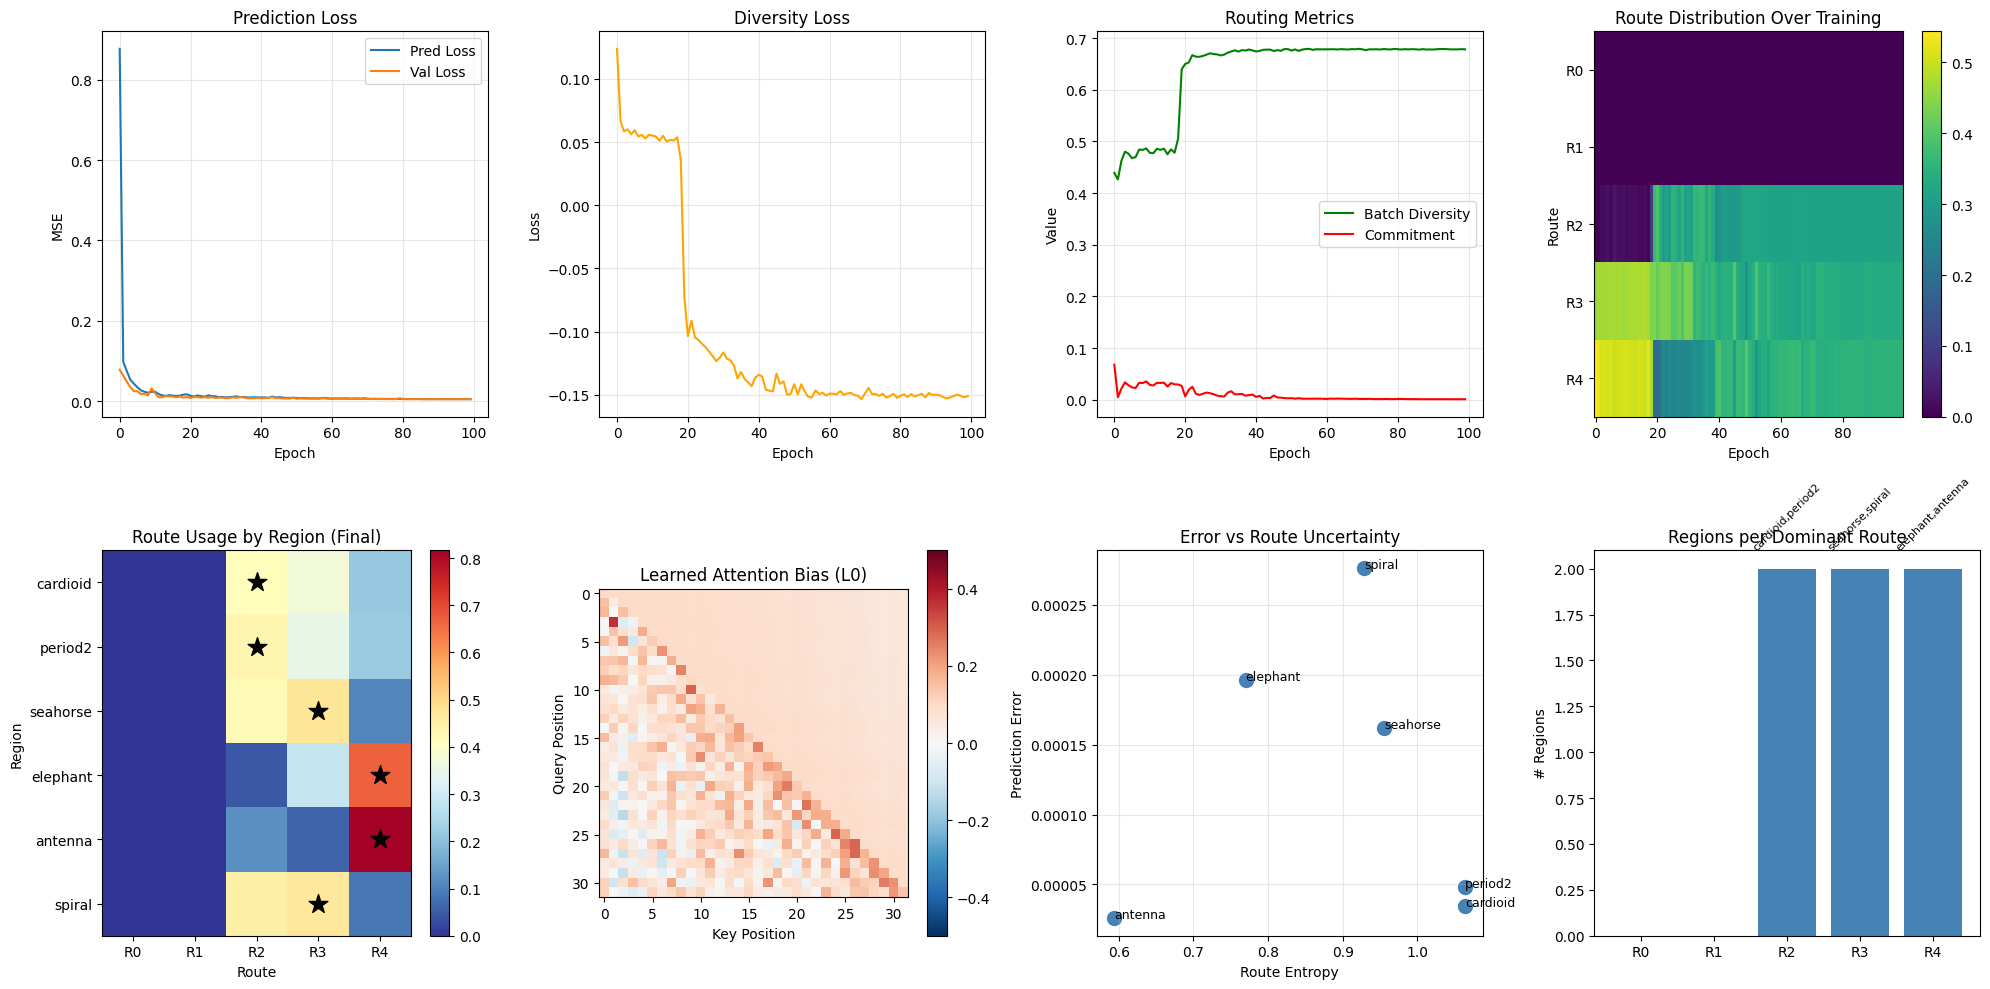


DIVERSITY ROUTING SUMMARY

Best validation loss: 0.004992
Diversity weight: 0.3

Route Usage by Region:
------------------------------------------------------------
cardioid     | [0.00 0.00 0.41 0.37 0.22] | R2 | H=1.06 | Err=0.000035
period2      | [0.00 0.00 0.43 0.35 0.22] | R2 | H=1.06 | Err=0.000048
seahorse     | [0.00 0.00 0.42 0.47 0.11] | R3 | H=0.96 | Err=0.000162
elephant     | [0.00 0.00 0.05 0.29 0.67] | R4 | H=0.77 | Err=0.000197
antenna      | [0.00 0.00 0.12 0.06 0.82] | R4 | H=0.59 | Err=0.000026
spiral       | [0.00 0.00 0.45 0.47 0.09] | R3 | H=0.93 | Err=0.000277

Dominant Route → Regions:
  Route 0: (none)
  Route 1: (none)
  Route 2: cardioid, period2
  Route 3: seahorse, spiral
  Route 4: elephant, antenna

Active routes: 3/5

Easy regions {'period2', 'cardioid', 'antenna'} → Routes {np.int64(2), np.int64(4)}
Hard regions {'seahorse', 'spiral', 'elephant'} → Routes {np.int64(3), np.int64(4)}
◐ Partial separation (multiple routes active)


In [12]:
# ============================================================================
# Soft Fractal Routing v2: With Route Diversity Loss
# ============================================================================
# Previous run: Routes collapsed to R0, all structure in attention bias
# This run: Add diversity pressure to force route differentiation
#
# New loss = prediction_loss + λ * diversity_loss
# ============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Optional, Dict, List, Tuple
from dataclasses import dataclass
import math

# geovocab2 imports
from geovocab2.shapes.factory.fractal_factory import (
    FractalFactory,
    FractalMode,
    create_orbit_dataset,
    get_region_names,
    FRACTAL_REGIONS
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

# ============================================================================
# Configuration
# ============================================================================

@dataclass
class SoftRoutingConfig:
    """Configuration for soft fractal routing experiment."""
    # Model
    input_dim: int = 4
    dim: int = 512
    num_layers: int = 2
    num_heads: int = 4
    dropout: float = 0.1

    # Soft routing
    num_routes: int = 5
    route_temp: float = 0.5      # Lower temp = sharper routing
    use_cantor_init: bool = True

    # Diversity loss
    diversity_weight: float = 0.3    # λ for diversity loss
    use_input_routing: bool = True   # Route based on input content, not just position

    # Task
    context_length: int = 32
    predict_length: int = 16
    sequence_length: int = 48

    # Data
    regions: Tuple[str, ...] = ('cardioid', 'period2', 'seahorse', 'elephant', 'antenna', 'spiral')
    train_samples: int = 6000
    val_samples: int = 600
    batch_size: int = 64

    # Training
    lr: float = 1e-3
    epochs: int = 100

    def __post_init__(self):
        self.sequence_length = self.context_length + self.predict_length

config = SoftRoutingConfig()
print(f"Soft routing with {config.num_routes} routes, diversity_weight={config.diversity_weight}")

# ============================================================================
# Cantor initialization helpers
# ============================================================================

def cantor_pair(x: int, y: int) -> int:
    s = x + y
    return (s * (s + 1)) // 2 + y

def create_cantor_bias(seq_len: int, num_routes: int) -> torch.Tensor:
    fingerprints = np.array([cantor_pair(i, i % num_routes) for i in range(seq_len)])
    fingerprints = (fingerprints - fingerprints.min()) / (fingerprints.max() - fingerprints.min() + 1e-8)
    bias = 1.0 - np.abs(fingerprints[:, None] - fingerprints[None, :])
    return torch.from_numpy(bias).float()

def create_route_embeddings(seq_len: int, num_routes: int, dim: int) -> torch.Tensor:
    affinities = torch.zeros(seq_len, num_routes)
    for i in range(seq_len):
        fp = cantor_pair(i, 0) % num_routes
        for r in range(num_routes):
            dist = abs(r - fp)
            affinities[i, r] = math.exp(-dist / 2.0)
    affinities = affinities / affinities.sum(dim=-1, keepdim=True)
    return affinities

# ============================================================================
# Content-Aware Soft Routing
# ============================================================================

class ContentAwareRouting(nn.Module):
    """
    Route based on input content, not just position.
    This allows different orbit dynamics to take different routes.
    """

    def __init__(self, dim: int, num_routes: int, temp: float = 0.5):
        super().__init__()
        self.num_routes = num_routes
        self.temp = temp

        # Project input to route logits
        self.route_proj = nn.Sequential(
            nn.Linear(dim, dim // 2),
            nn.GELU(),
            nn.Linear(dim // 2, num_routes)
        )

        # Learnable route embeddings
        self.route_embeds = nn.Parameter(torch.randn(num_routes, dim) * 0.02)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            x: [B, T, D]
        Returns:
            routed_x: [B, T, D] - input modulated by routes
            route_weights: [B, T, num_routes] - soft route assignments
        """
        # Compute route logits from content
        route_logits = self.route_proj(x)  # [B, T, num_routes]
        route_weights = F.softmax(route_logits / self.temp, dim=-1)  # [B, T, num_routes]

        # Modulate with route embeddings
        route_contribution = torch.einsum('btr,rd->btd', route_weights, self.route_embeds)
        routed_x = x + route_contribution

        return routed_x, route_weights


class DiversityRoutedAttention(nn.Module):
    """
    Attention with content-aware routing and diversity tracking.
    """

    def __init__(
        self,
        dim: int,
        num_heads: int,
        num_routes: int,
        max_seq_len: int,
        dropout: float = 0.1,
        use_cantor_init: bool = True,
        route_temp: float = 0.5,
        use_input_routing: bool = True
    ):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.num_routes = num_routes
        self.head_dim = dim // num_heads
        self.use_input_routing = use_input_routing

        # Content-aware routing (new!)
        if use_input_routing:
            self.router = ContentAwareRouting(dim, num_routes, route_temp)
        else:
            # Fall back to position-based
            self.router = None
            self.route_embeds = nn.Parameter(torch.randn(num_routes, dim) * 0.02)
            init_affinity = create_route_embeddings(max_seq_len, num_routes, dim) if use_cantor_init else torch.ones(max_seq_len, num_routes) / num_routes
            self.position_route_affinity = nn.Parameter(init_affinity)

        # QKV
        self.q_proj = nn.Linear(dim, dim)
        self.k_proj = nn.Linear(dim, dim)
        self.v_proj = nn.Linear(dim, dim)
        self.out_proj = nn.Linear(dim, dim)

        # Learnable attention bias
        if use_cantor_init:
            init_bias = create_cantor_bias(max_seq_len, num_routes) * 0.1
        else:
            init_bias = torch.zeros(max_seq_len, max_seq_len)
        self.attn_bias = nn.Parameter(init_bias)

        self.dropout = nn.Dropout(dropout)

        # For tracking
        self.route_weights: Optional[torch.Tensor] = None

    def forward(self, x: torch.Tensor, store_routing: bool = False) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        B, T, D = x.shape

        # Apply routing
        if self.use_input_routing:
            x_routed, route_weights = self.router(x)
        else:
            route_logits = self.position_route_affinity[:T]
            route_weights = F.softmax(route_logits / 0.5, dim=-1).unsqueeze(0).expand(B, -1, -1)
            route_mod = torch.einsum('btr,rd->btd', route_weights, self.route_embeds)
            x_routed = x + route_mod

        if store_routing:
            self.route_weights = route_weights.detach()

        # Attention
        q = self.q_proj(x_routed).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(x_routed).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(x_routed).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        scale = self.head_dim ** -0.5
        attn = (q @ k.transpose(-2, -1)) * scale
        attn = attn + self.attn_bias[:T, :T].unsqueeze(0).unsqueeze(0)

        # Causal mask
        causal_mask = torch.triu(torch.ones(T, T, device=x.device), diagonal=1).bool()
        attn = attn.masked_fill(causal_mask.unsqueeze(0).unsqueeze(0), float('-inf'))

        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)

        out = (attn @ v).transpose(1, 2).reshape(B, T, D)
        return self.out_proj(out), route_weights


class DiversityRoutedBlock(nn.Module):
    def __init__(self, dim, num_heads, num_routes, max_seq_len, dropout=0.1, use_cantor_init=True, use_input_routing=True):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = DiversityRoutedAttention(
            dim, num_heads, num_routes, max_seq_len, dropout, use_cantor_init, 0.5, use_input_routing
        )
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x: torch.Tensor, store_routing: bool = False) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        attn_out, route_weights = self.attn(self.norm1(x), store_routing=store_routing)
        x = x + attn_out
        x = x + self.ffn(self.norm2(x))
        return x, route_weights


class DiversityRoutedPredictor(nn.Module):
    """
    Predictor with content-aware routing and diversity loss support.
    """

    def __init__(self, config: SoftRoutingConfig):
        super().__init__()
        self.config = config

        self.input_proj = nn.Linear(config.input_dim, config.dim)
        self.pos_embed = nn.Parameter(
            torch.randn(1, config.sequence_length, config.dim) * 0.02
        )

        self.layers = nn.ModuleList([
            DiversityRoutedBlock(
                config.dim, config.num_heads, config.num_routes,
                config.sequence_length, config.dropout,
                config.use_cantor_init, config.use_input_routing
            )
            for _ in range(config.num_layers)
        ])

        self.norm = nn.LayerNorm(config.dim)
        self.pred_head = nn.Linear(config.dim, 2)

        self._store_routing = False
        self._last_route_weights = None

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        B, T, _ = x.shape

        x = self.input_proj(x)
        x = x + self.pos_embed[:, :T, :]

        all_route_weights = []
        for layer in self.layers:
            x, route_weights = layer(x, store_routing=self._store_routing)
            if route_weights is not None:
                all_route_weights.append(route_weights)

        # Aggregate route weights from all layers
        if all_route_weights:
            self._last_route_weights = torch.stack(all_route_weights, dim=0).mean(dim=0)  # [B, T, num_routes]

        x = self.norm(x)
        pred = self.pred_head(x)

        return pred, self._last_route_weights

    def enable_routing_tracking(self):
        self._store_routing = True

    def disable_routing_tracking(self):
        self._store_routing = False

    def get_attn_bias(self) -> Dict[int, torch.Tensor]:
        biases = {}
        for i, layer in enumerate(self.layers):
            biases[i] = layer.attn.attn_bias.detach()
        return biases

# Test model
model = DiversityRoutedPredictor(config).to(device)
dummy = torch.randn(4, config.sequence_length, 4).to(device)
out, routes = model(dummy)
print(f"Model output shape: {out.shape}")
print(f"Route weights shape: {routes.shape if routes is not None else 'None'}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

# ============================================================================
# Dataset
# ============================================================================

class OrbitPredictionDataset(Dataset):
    def __init__(self, num_samples: int, sequence_length: int, regions: List[str], seed: int = 42):
        self.regions = regions
        self.region_to_idx = {r: i for i, r in enumerate(regions)}

        print(f"Generating {num_samples} orbits...")
        self.data, self.metadata = create_orbit_dataset(
            num_samples=num_samples,
            sequence_length=sequence_length,
            regions=regions,
            seed=seed,
            backend='numpy'
        )

        self.labels = np.array([self.region_to_idx[m['region']] for m in self.metadata])
        self.data = torch.from_numpy(self.data).float()
        self.labels = torch.from_numpy(self.labels).long()

        print(f"Dataset: {len(self)} samples")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        seq = self.data[idx]
        target = F.pad(seq[1:, :2], (0, 0, 0, 1), value=0)
        return seq, target, self.labels[idx]

train_dataset = OrbitPredictionDataset(config.train_samples, config.sequence_length, list(config.regions), seed=42)
val_dataset = OrbitPredictionDataset(config.val_samples, config.sequence_length, list(config.regions), seed=123)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

# ============================================================================
# Diversity Loss
# ============================================================================

def compute_diversity_loss(route_weights: torch.Tensor) -> Tuple[torch.Tensor, Dict[str, float]]:
    """
    Compute diversity loss to encourage route differentiation.

    Args:
        route_weights: [B, T, num_routes]

    Returns:
        loss: scalar tensor
        metrics: dict with diagnostic values
    """
    B, T, R = route_weights.shape

    # 1. Entropy loss: encourage each position to commit to a route (low entropy per position)
    #    But also encourage different positions to use different routes
    per_position_entropy = -(route_weights * torch.log(route_weights + 1e-8)).sum(dim=-1)  # [B, T]

    # 2. Batch-level diversity: average route usage should be balanced
    mean_routes = route_weights.mean(dim=(0, 1))  # [num_routes]
    batch_entropy = -(mean_routes * torch.log(mean_routes + 1e-8)).sum()
    max_entropy = math.log(R)

    # 3. We want: low per-position entropy (commitment) + high batch entropy (diversity)
    commitment_loss = per_position_entropy.mean()  # Minimize this
    diversity_bonus = batch_entropy / max_entropy   # Maximize this (0 to 1)

    # Combined: encourage commitment but penalize if batch isn't diverse
    # loss = commitment - λ * diversity  (we want high diversity, so subtract)
    diversity_loss = commitment_loss - 0.5 * diversity_bonus

    # 4. Load balancing: penalize if one route dominates
    route_usage = route_weights.sum(dim=(0, 1)) / (B * T)  # [num_routes] - proportion
    load_balance_loss = (route_usage.max() - route_usage.min())  # Penalize imbalance

    total_loss = diversity_loss + 0.5 * load_balance_loss

    metrics = {
        'commitment': commitment_loss.item(),
        'diversity': diversity_bonus.item(),
        'load_balance': load_balance_loss.item(),
        'dominant_route': route_usage.argmax().item(),
        'route_usage': route_usage.detach().cpu().numpy()
    }

    return total_loss, metrics

# ============================================================================
# Training with Diversity Loss
# ============================================================================

def train_epoch(model, loader, optimizer, device, context_len, diversity_weight):
    model.train()
    total_pred_loss = 0
    total_div_loss = 0
    total_samples = 0
    route_metrics_accum = defaultdict(list)

    for input_seq, target_seq, _ in loader:
        input_seq = input_seq.to(device)
        target_seq = target_seq.to(device)

        optimizer.zero_grad()
        pred, route_weights = model(input_seq)

        # Prediction loss (weighted)
        T = pred.size(1)
        weights = torch.ones(T, device=device)
        weights[context_len:] = 2.0
        loss_per_pos = F.mse_loss(pred, target_seq, reduction='none').mean(dim=-1)
        pred_loss = (loss_per_pos * weights).mean()

        # Diversity loss
        if route_weights is not None and diversity_weight > 0:
            div_loss, metrics = compute_diversity_loss(route_weights)
            total_loss = pred_loss + diversity_weight * div_loss

            for k, v in metrics.items():
                if k != 'route_usage':
                    route_metrics_accum[k].append(v)
        else:
            div_loss = torch.tensor(0.0)
            total_loss = pred_loss

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_pred_loss += pred_loss.item() * input_seq.size(0)
        total_div_loss += div_loss.item() * input_seq.size(0) if isinstance(div_loss, torch.Tensor) else 0
        total_samples += input_seq.size(0)

    avg_metrics = {k: np.mean(v) for k, v in route_metrics_accum.items()}
    return total_pred_loss / total_samples, total_div_loss / total_samples, avg_metrics


@torch.no_grad()
def eval_epoch(model, loader, device, context_len):
    model.eval()
    total_loss = 0
    context_loss = 0
    predict_loss = 0
    total_samples = 0
    all_route_weights = []

    for input_seq, target_seq, _ in loader:
        input_seq = input_seq.to(device)
        target_seq = target_seq.to(device)

        pred, route_weights = model(input_seq)

        loss = F.mse_loss(pred, target_seq)
        ctx_loss = F.mse_loss(pred[:, :context_len], target_seq[:, :context_len])
        prd_loss = F.mse_loss(pred[:, context_len:], target_seq[:, context_len:])

        total_loss += loss.item() * input_seq.size(0)
        context_loss += ctx_loss.item() * input_seq.size(0)
        predict_loss += prd_loss.item() * input_seq.size(0)
        total_samples += input_seq.size(0)

        if route_weights is not None:
            all_route_weights.append(route_weights.cpu())

    # Compute overall route distribution
    if all_route_weights:
        all_routes = torch.cat(all_route_weights, dim=0)
        route_dist = all_routes.mean(dim=(0, 1)).numpy()
    else:
        route_dist = None

    return (
        total_loss / total_samples,
        context_loss / total_samples,
        predict_loss / total_samples,
        route_dist
    )


@torch.no_grad()
def analyze_routing_by_region(model, loader, device, regions):
    """Analyze route usage per region."""
    model.eval()
    model.enable_routing_tracking()

    region_routes = defaultdict(list)
    idx_to_region = {i: r for i, r in enumerate(regions)}

    for input_seq, _, labels in loader:
        input_seq = input_seq.to(device)
        _, route_weights = model(input_seq)

        if route_weights is not None:
            route_weights = route_weights.cpu()
            for i, label in enumerate(labels):
                region = idx_to_region[label.item()]
                # Average over time dimension
                region_routes[region].append(route_weights[i].mean(dim=0))

    model.disable_routing_tracking()

    stats = {}
    for region in regions:
        if region in region_routes:
            all_weights = torch.stack(region_routes[region])
            mean_weights = all_weights.mean(dim=0).numpy()
            stats[region] = {
                'mean_route_weights': mean_weights,
                'dominant_route': mean_weights.argmax(),
                'entropy': -(mean_weights * np.log(mean_weights + 1e-8)).sum()
            }

    return stats

# ============================================================================
# Main Training Loop
# ============================================================================

model = DiversityRoutedPredictor(config).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.epochs)

history = {
    'train_pred': [], 'train_div': [],
    'val_loss': [], 'val_ctx': [], 'val_pred': [],
    'route_dist': [], 'diversity': [], 'commitment': []
}
route_evolution = {}

print(f"\nTraining with diversity_weight={config.diversity_weight}")
print(f"Content-aware routing: {config.use_input_routing}")
print("-" * 70)

best_val_loss = float('inf')
for epoch in range(config.epochs):
    train_pred, train_div, train_metrics = train_epoch(
        model, train_loader, optimizer, device,
        config.context_length, config.diversity_weight
    )
    val_loss, val_ctx, val_pred, route_dist = eval_epoch(
        model, val_loader, device, config.context_length
    )
    scheduler.step()

    history['train_pred'].append(train_pred)
    history['train_div'].append(train_div)
    history['val_loss'].append(val_loss)
    history['val_ctx'].append(val_ctx)
    history['val_pred'].append(val_pred)
    history['diversity'].append(train_metrics.get('diversity', 0))
    history['commitment'].append(train_metrics.get('commitment', 0))
    if route_dist is not None:
        history['route_dist'].append(route_dist)

    best_marker = " ★" if val_loss < best_val_loss else ""
    if val_loss < best_val_loss:
        best_val_loss = val_loss

    if (epoch + 1) % 20 == 0 or epoch == 0:
        route_stats = analyze_routing_by_region(model, val_loader, device, list(config.regions))
        route_evolution[epoch + 1] = route_stats

        route_str = ' '.join([f'{r:.2f}' for r in route_dist]) if route_dist is not None else 'N/A'
        print(f"Epoch {epoch+1:3d} | Pred: {train_pred:.6f} | Div: {train_div:.4f} | "
              f"Val: {val_loss:.6f}{best_marker} | Routes: [{route_str}]")

print("-" * 70)
print(f"Best validation loss: {best_val_loss:.6f}")

# Final analysis
final_route_stats = analyze_routing_by_region(model, val_loader, device, list(config.regions))

# ============================================================================
# Visualization
# ============================================================================

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Training curves
axes[0, 0].plot(history['train_pred'], label='Pred Loss')
axes[0, 0].plot(history['val_loss'], label='Val Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].set_title('Prediction Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history['train_div'], label='Diversity Loss', color='orange')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Diversity Loss')
axes[0, 1].grid(True, alpha=0.3)

# Diversity metrics
axes[0, 2].plot(history['diversity'], label='Batch Diversity', color='green')
axes[0, 2].plot(history['commitment'], label='Commitment', color='red')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Value')
axes[0, 2].set_title('Routing Metrics')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Route distribution evolution
if history['route_dist']:
    route_evolution_matrix = np.array(history['route_dist'])
    im = axes[0, 3].imshow(route_evolution_matrix.T, aspect='auto', cmap='viridis')
    axes[0, 3].set_xlabel('Epoch')
    axes[0, 3].set_ylabel('Route')
    axes[0, 3].set_yticks(range(config.num_routes))
    axes[0, 3].set_yticklabels([f'R{i}' for i in range(config.num_routes)])
    axes[0, 3].set_title('Route Distribution Over Training')
    plt.colorbar(im, ax=axes[0, 3])

# Final route usage by region
route_matrix = np.zeros((len(config.regions), config.num_routes))
for i, region in enumerate(config.regions):
    if region in final_route_stats:
        route_matrix[i] = final_route_stats[region]['mean_route_weights']

im2 = axes[1, 0].imshow(route_matrix, aspect='auto', cmap='RdYlBu_r')
axes[1, 0].set_xticks(range(config.num_routes))
axes[1, 0].set_xticklabels([f'R{i}' for i in range(config.num_routes)])
axes[1, 0].set_yticks(range(len(config.regions)))
axes[1, 0].set_yticklabels(config.regions)
axes[1, 0].set_xlabel('Route')
axes[1, 0].set_ylabel('Region')
axes[1, 0].set_title('Route Usage by Region (Final)')
plt.colorbar(im2, ax=axes[1, 0])

for i, region in enumerate(config.regions):
    if region in final_route_stats:
        dom = final_route_stats[region]['dominant_route']
        axes[1, 0].scatter(dom, i, marker='*', s=200, c='black', zorder=10)

# Attention bias
attn_biases = model.get_attn_bias()
if 0 in attn_biases:
    bias = attn_biases[0].cpu().numpy()
    im3 = axes[1, 1].imshow(bias[:32, :32], cmap='RdBu_r', vmin=-0.5, vmax=0.5)
    axes[1, 1].set_xlabel('Key Position')
    axes[1, 1].set_ylabel('Query Position')
    axes[1, 1].set_title('Learned Attention Bias (L0)')
    plt.colorbar(im3, ax=axes[1, 1])

# Per-region error vs entropy
@torch.no_grad()
def compute_region_errors(model, loader, device, regions, context_len):
    model.eval()
    region_errors = defaultdict(list)
    idx_to_region = {i: r for i, r in enumerate(regions)}

    for input_seq, target_seq, labels in loader:
        input_seq = input_seq.to(device)
        target_seq = target_seq.to(device)
        pred, _ = model(input_seq)

        errors = F.mse_loss(pred[:, context_len:], target_seq[:, context_len:], reduction='none').mean(dim=(1,2))

        for i, label in enumerate(labels):
            region_errors[idx_to_region[label.item()]].append(errors[i].item())

    return {r: np.mean(errs) for r, errs in region_errors.items()}

region_errors = compute_region_errors(model, val_loader, device, list(config.regions), config.context_length)

entropies = []
errors = []
for region in config.regions:
    stats = final_route_stats.get(region, {})
    entropy = stats.get('entropy', 0)
    entropies.append(entropy)
    errors.append(region_errors.get(region, 0))

axes[1, 2].scatter(entropies, errors, s=100, c='steelblue')
for i, region in enumerate(config.regions):
    axes[1, 2].annotate(region, (entropies[i], errors[i]), fontsize=9)
axes[1, 2].set_xlabel('Route Entropy')
axes[1, 2].set_ylabel('Prediction Error')
axes[1, 2].set_title('Error vs Route Uncertainty')
axes[1, 2].grid(True, alpha=0.3)

# Dominant route per region
route_to_regions = defaultdict(list)
for region, stats in final_route_stats.items():
    route_to_regions[stats['dominant_route']].append(region)

route_counts = [len(route_to_regions.get(r, [])) for r in range(config.num_routes)]
bars = axes[1, 3].bar(range(config.num_routes), route_counts, color='steelblue')
axes[1, 3].set_xticks(range(config.num_routes))
axes[1, 3].set_xticklabels([f'R{i}' for i in range(config.num_routes)])
axes[1, 3].set_ylabel('# Regions')
axes[1, 3].set_title('Regions per Dominant Route')

for r in range(config.num_routes):
    regions = route_to_regions.get(r, [])
    if regions:
        axes[1, 3].annotate(','.join(regions), (r, len(regions) + 0.1), ha='center', fontsize=8, rotation=45)

plt.tight_layout()
plt.show()

# ============================================================================
# Summary
# ============================================================================

print("\n" + "=" * 70)
print("DIVERSITY ROUTING SUMMARY")
print("=" * 70)

print(f"\nBest validation loss: {best_val_loss:.6f}")
print(f"Diversity weight: {config.diversity_weight}")

print("\nRoute Usage by Region:")
print("-" * 60)
for region in config.regions:
    stats = final_route_stats.get(region, {})
    weights = stats.get('mean_route_weights', np.zeros(config.num_routes))
    dominant = stats.get('dominant_route', -1)
    entropy = stats.get('entropy', 0)
    error = region_errors.get(region, 0)
    weights_str = ' '.join([f'{w:.2f}' for w in weights])
    print(f"{region:12s} | [{weights_str}] | R{dominant} | H={entropy:.2f} | Err={error:.6f}")

print("\nDominant Route → Regions:")
for route in range(config.num_routes):
    regions = route_to_regions.get(route, [])
    regions_str = ', '.join(regions) if regions else '(none)'
    print(f"  Route {route}: {regions_str}")

active_routes = sum(1 for r in range(config.num_routes) if route_to_regions.get(r))
print(f"\nActive routes: {active_routes}/{config.num_routes}")

# Check easy/hard separation
easy_regions = {'antenna', 'cardioid', 'period2'}
hard_regions = {'seahorse', 'spiral', 'elephant'}

easy_routes = set(final_route_stats.get(r, {}).get('dominant_route', -1) for r in easy_regions if r in final_route_stats)
hard_routes = set(final_route_stats.get(r, {}).get('dominant_route', -1) for r in hard_regions if r in final_route_stats)

print(f"\nEasy regions {easy_regions} → Routes {easy_routes}")
print(f"Hard regions {hard_regions} → Routes {hard_routes}")

if easy_routes.isdisjoint(hard_routes):
    print("✓ Easy/Hard route separation achieved!")
elif len(easy_routes.union(hard_routes)) > 1:
    print("◐ Partial separation (multiple routes active)")
else:
    print("○ No separation (all same route)")

print("=" * 70)

In [13]:
"""
Tessellation Expert with Cantor Wormhole Routes
================================================

Accidental emergence → intentional architecture:
- Feature-dim slicing creates "tessellation patches" on the embedding
- Wormhole routes allow tiles to borrow capacity from learned neighbors
- Cantor fingerprints guide which tiles can connect

Hypothesis: Tiles that share Cantor-adjacent fingerprints will learn
complementary representations, and wormholes enable cross-tile flow.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
from typing import Tuple, List, Optional, Dict
import matplotlib.pyplot as plt
import numpy as np

# ============================================================================
# CONFIGURATION
# ============================================================================

@dataclass
class TessellationConfig:
    """Config for tessellation expert experiments."""
    dim: int = 256
    num_tiles: int = 16          # Feature-dim tessellation count
    num_wormholes: int = 4       # Neighbors each tile can reach
    num_layers: int = 2
    num_heads: int = 4
    mlp_ratio: float = 2.0
    dropout: float = 0.1

    # Wormhole routing
    wormhole_mode: str = "cantor"  # "cantor", "learned", "hybrid"
    cantor_weight: float = 0.3
    temperature: float = 0.5

    # Training
    num_classes: int = 100

    @property
    def tile_dim(self) -> int:
        return self.dim // self.num_tiles


# ============================================================================
# CANTOR WORMHOLE ROUTER
# ============================================================================

class CantorWormholeRouter(nn.Module):
    """
    Routes between tessellation tiles using Cantor pairing.

    Each tile gets a Cantor fingerprint based on its position.
    Wormholes connect tiles with related fingerprints.
    """

    def __init__(
        self,
        num_tiles: int,
        num_wormholes: int,
        cantor_weight: float = 0.3,
        mode: str = "hybrid"
    ):
        super().__init__()
        self.num_tiles = num_tiles
        self.num_wormholes = num_wormholes
        self.cantor_weight = cantor_weight
        self.mode = mode

        # Compute Cantor fingerprints for tiles
        fingerprints = self._compute_cantor_fingerprints()
        self.register_buffer('fingerprints', fingerprints)

        # Base routes from Cantor distance
        base_routes = self._compute_cantor_routes()
        self.register_buffer('base_routes', base_routes)

        if mode in ["learned", "hybrid"]:
            # Learnable route adjustments
            self.route_logits = nn.Parameter(
                torch.zeros(num_tiles, num_tiles)
            )
            # Initialize with Cantor prior
            with torch.no_grad():
                cantor_dist = self._cantor_distance_matrix()
                self.route_logits.copy_(-cantor_dist * 2)  # Closer = higher logit

    def _compute_cantor_fingerprints(self) -> torch.Tensor:
        """Cantor pairing on tile indices."""
        T = self.num_tiles
        # Treat tile index as (x, y) in a virtual grid
        grid_size = int(math.ceil(math.sqrt(T)))

        x = torch.arange(T) % grid_size
        y = torch.arange(T) // grid_size

        # Cantor pairing: z = (x+y)(x+y+1)/2 + y
        sums = x + y
        z = (sums * (sums + 1)) // 2 + y

        # Normalize to [0, 1]
        fingerprints = z.float() / z.max().clamp(min=1)
        return fingerprints

    def _cantor_distance_matrix(self) -> torch.Tensor:
        """Pairwise Cantor distance between tiles."""
        fp = self.fingerprints
        return (fp.unsqueeze(0) - fp.unsqueeze(1)).abs()

    def _compute_cantor_routes(self) -> torch.Tensor:
        """K-nearest tiles by Cantor distance."""
        dist = self._cantor_distance_matrix()
        # Add small noise to break ties, exclude self
        dist = dist + torch.eye(self.num_tiles) * 1e6
        _, routes = torch.topk(dist, self.num_wormholes, dim=1, largest=False)
        return routes

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Compute wormhole routes and weights.

        Args:
            x: [B, S, num_tiles, tile_dim] - tiled features

        Returns:
            routes: [num_tiles, num_wormholes] - which tiles to connect
            weights: [B, S, num_tiles, num_wormholes] - soft routing weights
        """
        B, S, T, D = x.shape

        if self.mode == "cantor":
            # Pure Cantor routing (fixed)
            routes = self.base_routes
            weights = torch.ones(B, S, T, self.num_wormholes, device=x.device)
            weights = weights / self.num_wormholes

        elif self.mode == "learned":
            # Fully learned routing
            logits = self.route_logits  # [T, T]
            weights, routes = torch.topk(
                F.softmax(logits, dim=-1),
                self.num_wormholes,
                dim=-1
            )
            weights = weights.unsqueeze(0).unsqueeze(0).expand(B, S, -1, -1)

        else:  # hybrid
            # Content-aware modulation of Cantor prior
            # Use tile mean as routing query
            tile_summary = x.mean(dim=-1)  # [B, S, T]

            # Cantor prior + learned adjustment
            base_logits = self.route_logits  # [T, T]

            # Gather logits for Cantor neighbors only (sparse)
            routes = self.base_routes  # [T, K]
            neighbor_logits = base_logits.gather(1, routes)  # [T, K]

            # Soft weights over wormhole neighbors
            weights = F.softmax(neighbor_logits / 0.5, dim=-1)  # [T, K]
            weights = weights.unsqueeze(0).unsqueeze(0).expand(B, S, -1, -1)

        return routes, weights


# ============================================================================
# TESSELLATION EXPERT WITH WORMHOLES
# ============================================================================

class WormholeTessellationExpert(nn.Module):
    """
    Feature-dimension tessellation with wormhole cross-connections.

    Instead of isolated tile processing:
    1. Split features into tiles
    2. Each tile gathers from wormhole neighbors
    3. Process with expanded context
    4. Project back to tile dimension
    """

    def __init__(self, config: TessellationConfig):
        super().__init__()
        self.config = config
        self.num_tiles = config.num_tiles
        self.tile_dim = config.tile_dim
        self.num_wormholes = config.num_wormholes

        # Wormhole router
        self.router = CantorWormholeRouter(
            num_tiles=config.num_tiles,
            num_wormholes=config.num_wormholes,
            cantor_weight=config.cantor_weight,
            mode=config.wormhole_mode
        )

        # Input: tile_dim + (num_wormholes * tile_dim) from neighbors
        wormhole_input_dim = config.tile_dim * (1 + config.num_wormholes)
        hidden_dim = int(config.tile_dim * config.mlp_ratio)

        # Tile processor with wormhole context
        self.tile_processor = nn.Sequential(
            nn.Linear(wormhole_input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(config.dropout),
            nn.Linear(hidden_dim, config.tile_dim)
        )

        # Wormhole attention (optional - weight neighbor contributions)
        self.wormhole_attn = nn.MultiheadAttention(
            embed_dim=config.tile_dim,
            num_heads=2,
            dropout=config.dropout,
            batch_first=True
        )

        self.norm = nn.LayerNorm(config.dim)
        self.tile_norm = nn.LayerNorm(config.tile_dim)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, Dict]:
        """
        Args:
            x: [B, S, D] input features

        Returns:
            out: [B, S, D] processed features
            info: routing statistics
        """
        B, S, D = x.shape
        x_norm = self.norm(x)

        # Tessellate: [B, S, D] -> [B, S, num_tiles, tile_dim]
        x_tiles = x_norm.view(B, S, self.num_tiles, self.tile_dim)

        # Get wormhole routes and weights
        routes, weights = self.router(x_tiles)  # [T, K], [B, S, T, K]

        # Gather neighbor tiles through wormholes
        # routes: [T, K] - for each tile, which K tiles to gather
        x_flat = x_tiles.reshape(B * S, self.num_tiles, self.tile_dim)

        # Expand routes for batch: [T, K] -> [B*S, T, K]
        routes_exp = routes.unsqueeze(0).expand(B * S, -1, -1)

        # Gather neighbors: [B*S, T, K, tile_dim]
        batch_idx = torch.arange(B * S, device=x.device).view(-1, 1, 1)
        neighbors = x_flat[batch_idx, routes_exp, :]  # [B*S, T, K, tile_dim]
        neighbors = neighbors.view(B, S, self.num_tiles, self.num_wormholes, self.tile_dim)

        # Weight neighbors by routing weights
        weights_exp = weights.unsqueeze(-1)  # [B, S, T, K, 1]
        weighted_neighbors = neighbors * weights_exp  # [B, S, T, K, tile_dim]

        # Option A: Concatenate tile + weighted neighbors
        neighbor_context = weighted_neighbors.sum(dim=3)  # [B, S, T, tile_dim]

        # Option B: Use attention to mix neighbors (richer but slower)
        # Reshape for attention: [B*S*T, K, tile_dim]
        # query = x_tiles (self), keys/values = neighbors
        x_tiles_flat = x_tiles.reshape(B * S * self.num_tiles, 1, self.tile_dim)
        neighbors_flat = neighbors.reshape(B * S * self.num_tiles, self.num_wormholes, self.tile_dim)

        attn_out, attn_weights = self.wormhole_attn(
            self.tile_norm(x_tiles_flat),
            self.tile_norm(neighbors_flat),
            neighbors_flat
        )
        attn_context = attn_out.view(B, S, self.num_tiles, self.tile_dim)

        # Combine: original tile + concat context + attention context
        combined = torch.cat([
            x_tiles,           # Self
            neighbor_context,  # Weighted sum of wormhole neighbors
            attn_context,      # Attention-mixed neighbors
            weighted_neighbors.view(B, S, self.num_tiles, -1)[..., :self.tile_dim]  # First neighbor raw
        ], dim=-1)  # [B, S, T, tile_dim * 4]

        # Adjust processor input if needed
        # For now, use simpler version: tile + neighbor_context
        simple_combined = torch.cat([x_tiles, neighbor_context], dim=-1)

        # Process each tile with wormhole context
        simple_combined_flat = simple_combined.view(B * S * self.num_tiles, -1)

        # Pad/truncate to match expected input dim
        expected_dim = self.tile_dim * (1 + self.num_wormholes)
        if simple_combined_flat.shape[-1] < expected_dim:
            simple_combined_flat = F.pad(
                simple_combined_flat,
                (0, expected_dim - simple_combined_flat.shape[-1])
            )
        else:
            simple_combined_flat = simple_combined_flat[..., :expected_dim]

        out_tiles = self.tile_processor(simple_combined_flat)
        out_tiles = out_tiles.view(B, S, self.num_tiles, self.tile_dim)

        # Reconstruct: [B, S, num_tiles, tile_dim] -> [B, S, D]
        out = out_tiles.reshape(B, S, D)

        # Residual
        out = x + out

        # Collect routing info
        info = {
            'routes': routes,
            'weights': weights.mean(dim=(0, 1)),  # [T, K] average weights
            'attn_weights': attn_weights.view(B, S, self.num_tiles, self.num_wormholes).mean(dim=(0, 1))
        }

        return out, info


# ============================================================================
# FULL MODEL FOR TESTING
# ============================================================================

class TessellationTransformer(nn.Module):
    """
    Transformer with tessellation experts + wormhole routing.
    """

    def __init__(self, config: TessellationConfig):
        super().__init__()
        self.config = config

        # Patch embedding (for images)
        self.patch_size = 4
        self.num_patches = (32 // self.patch_size) ** 2  # 64 for CIFAR

        self.patch_embed = nn.Conv2d(3, config.dim, kernel_size=4, stride=4)
        self.cls_token = nn.Parameter(torch.randn(1, 1, config.dim) * 0.02)
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + self.num_patches, config.dim) * 0.02)

        # Layers: Attention -> TessellationExpert
        self.layers = nn.ModuleList()
        for _ in range(config.num_layers):
            self.layers.append(nn.ModuleDict({
                'attn': nn.MultiheadAttention(
                    config.dim, config.num_heads,
                    dropout=config.dropout, batch_first=True
                ),
                'attn_norm': nn.LayerNorm(config.dim),
                'expert': WormholeTessellationExpert(config),
            }))

        self.norm = nn.LayerNorm(config.dim)
        self.head = nn.Linear(config.dim, config.num_classes)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, Dict]:
        B = x.shape[0]

        # Patch embed
        x = self.patch_embed(x).flatten(2).transpose(1, 2)  # [B, P, D]

        # Add CLS + pos
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)
        x = x + self.pos_embed

        # Process layers
        all_routing_info = []
        for layer in self.layers:
            # Self-attention
            x_norm = layer['attn_norm'](x)
            attn_out, _ = layer['attn'](x_norm, x_norm, x_norm)
            x = x + attn_out

            # Tessellation expert with wormholes
            x, routing_info = layer['expert'](x)
            all_routing_info.append(routing_info)

        # Pool and classify
        x = self.norm(x)
        cls_out = x[:, 0]
        logits = self.head(cls_out)

        return logits, all_routing_info


# ============================================================================
# TRAINING LOOP
# ============================================================================

def train_tessellation_experiment(
    epochs: int = 50,
    batch_size: int = 128,
    lr: float = 3e-4,
    wormhole_mode: str = "hybrid",
    num_tiles: int = 16,
    num_wormholes: int = 4,
):
    """Train and analyze tessellation expert with wormholes."""

    import torchvision
    import torchvision.transforms as T
    from torch.utils.data import DataLoader

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

    # Data
    transform_train = T.Compose([
        T.RandomCrop(32, padding=4),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])
    transform_test = T.Compose([
        T.ToTensor(),
        T.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])

    train_data = torchvision.datasets.CIFAR100(
        './data', train=True, download=True, transform=transform_train
    )
    test_data = torchvision.datasets.CIFAR100(
        './data', train=False, transform=transform_test
    )

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=2)

    # Model
    config = TessellationConfig(
        dim=256,
        num_tiles=num_tiles,
        num_wormholes=num_wormholes,
        num_layers=3,
        num_heads=4,
        wormhole_mode=wormhole_mode,
        num_classes=100
    )

    model = TessellationTransformer(config).to(device)

    params = sum(p.numel() for p in model.parameters())
    print(f"\nTessellation Transformer")
    print(f"  Tiles: {num_tiles} × {config.tile_dim}d each")
    print(f"  Wormholes: {num_wormholes} per tile")
    print(f"  Mode: {wormhole_mode}")
    print(f"  Parameters: {params:,}")

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.05)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

    # Tracking
    history = {
        'train_loss': [], 'train_acc': [],
        'test_loss': [], 'test_acc': [],
        'wormhole_entropy': [], 'route_usage': []
    }

    best_acc = 0

    for epoch in range(epochs):
        # Train
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        epoch_routing = []

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            logits, routing_info = model(imgs)
            loss = F.cross_entropy(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * imgs.size(0)
            train_correct += (logits.argmax(1) == labels).sum().item()
            train_total += imgs.size(0)

            # Track routing
            epoch_routing.append({
                'weights': routing_info[-1]['weights'].detach().cpu()
            })

        scheduler.step()

        # Eval
        model.eval()
        test_loss, test_correct, test_total = 0, 0, 0

        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                logits, _ = model(imgs)
                loss = F.cross_entropy(logits, labels)

                test_loss += loss.item() * imgs.size(0)
                test_correct += (logits.argmax(1) == labels).sum().item()
                test_total += imgs.size(0)

        train_acc = train_correct / train_total
        test_acc = test_correct / test_total

        # Compute routing stats
        avg_weights = torch.stack([r['weights'] for r in epoch_routing]).mean(0)
        wormhole_entropy = -(avg_weights * (avg_weights + 1e-8).log()).sum(-1).mean().item()
        route_usage = (avg_weights.max(-1).values > 0.5).float().mean().item()

        history['train_loss'].append(train_loss / train_total)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss / test_total)
        history['test_acc'].append(test_acc)
        history['wormhole_entropy'].append(wormhole_entropy)
        history['route_usage'].append(route_usage)

        if test_acc > best_acc:
            best_acc = test_acc
            marker = " ★"
        else:
            marker = ""

        print(f"Epoch {epoch+1:3d} | "
              f"Train: {train_acc*100:.1f}% | "
              f"Test: {test_acc*100:.1f}%{marker} | "
              f"H(worm): {wormhole_entropy:.2f} | "
              f"Usage: {route_usage*100:.0f}%")

    print(f"\nBest test accuracy: {best_acc*100:.2f}%")

    return model, history, config


# ============================================================================
# VISUALIZATION
# ============================================================================

def visualize_tessellation_results(model, history, config):
    """Visualize training and wormhole routing patterns."""

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # 1. Training curves
    ax = axes[0, 0]
    ax.plot(history['train_acc'], label='Train', alpha=0.7)
    ax.plot(history['test_acc'], label='Test', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Training Progress')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 2. Loss curves
    ax = axes[0, 1]
    ax.plot(history['train_loss'], label='Train', alpha=0.7)
    ax.plot(history['test_loss'], label='Test', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Loss Curves')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 3. Wormhole entropy over training
    ax = axes[0, 2]
    ax.plot(history['wormhole_entropy'], color='purple', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Entropy')
    ax.set_title('Wormhole Routing Entropy')
    ax.grid(True, alpha=0.3)

    # 4. Route usage
    ax = axes[1, 0]
    ax.plot(history['route_usage'], color='green', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Committed Routes (%)')
    ax.set_title('Wormhole Commitment (>50%)')
    ax.grid(True, alpha=0.3)

    # 5. Cantor fingerprint visualization
    ax = axes[1, 1]
    router = model.layers[0]['expert'].router
    fingerprints = router.fingerprints.cpu().numpy()
    routes = router.base_routes.cpu().numpy()

    # Plot tiles and their wormhole connections
    T = config.num_tiles
    grid = int(np.ceil(np.sqrt(T)))

    for i in range(T):
        x_i, y_i = i % grid, i // grid
        ax.scatter(x_i, y_i, c=[fingerprints[i]], cmap='viridis',
                   s=200, vmin=0, vmax=1, zorder=2)
        ax.text(x_i, y_i, str(i), ha='center', va='center', fontsize=8, color='white')

        # Draw wormhole connections
        for j in routes[i]:
            x_j, y_j = j % grid, j // grid
            ax.plot([x_i, x_j], [y_i, y_j], 'r-', alpha=0.2, linewidth=0.5)

    ax.set_title(f'Cantor Fingerprints & Wormholes\n({config.num_tiles} tiles, {config.num_wormholes} wormholes each)')
    ax.set_aspect('equal')
    ax.axis('off')

    # 6. Final routing weights heatmap
    ax = axes[1, 2]
    # Get final routing weights from last layer
    with torch.no_grad():
        dummy = torch.randn(1, 65, config.dim).to(next(model.parameters()).device)
        for layer in model.layers:
            dummy_norm = layer['attn_norm'](dummy)
            dummy, _ = layer['attn'](dummy_norm, dummy_norm, dummy_norm)
            dummy = dummy + dummy_norm
        _, routing_info = model.layers[-1]['expert'](dummy)

    weights = routing_info['weights'].cpu().numpy()
    im = ax.imshow(weights, aspect='auto', cmap='hot')
    ax.set_xlabel('Wormhole Index')
    ax.set_ylabel('Tile Index')
    ax.set_title('Final Wormhole Weights (Layer -1)')
    plt.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.savefig('tessellation_wormhole_results.png', dpi=150, bbox_inches='tight')
    plt.show()

    return fig


# ============================================================================
# RUN EXPERIMENT
# ============================================================================

if __name__ == "__main__":
    print("=" * 70)
    print("TESSELLATION EXPERT WITH CANTOR WORMHOLE ROUTING")
    print("=" * 70)

    model, history, config = train_tessellation_experiment(
        epochs=50,
        batch_size=128,
        lr=3e-4,
        wormhole_mode="hybrid",  # "cantor", "learned", or "hybrid"
        num_tiles=16,
        num_wormholes=4
    )

    fig = visualize_tessellation_results(model, history, config)

TESSELLATION EXPERT WITH CANTOR WORMHOLE ROUTING
Device: cuda


100%|██████████| 169M/169M [00:02<00:00, 80.3MB/s]



Tessellation Transformer
  Tiles: 16 × 16d each
  Wormholes: 4 per tile
  Mode: hybrid
  Parameters: 861,716
Epoch   1 | Train: 10.7% | Test: 15.2% ★ | H(worm): 1.37 | Usage: 0%
Epoch   2 | Train: 18.9% | Test: 21.6% ★ | H(worm): 1.37 | Usage: 0%
Epoch   3 | Train: 22.9% | Test: 25.5% ★ | H(worm): 1.37 | Usage: 0%
Epoch   4 | Train: 25.6% | Test: 27.8% ★ | H(worm): 1.37 | Usage: 0%
Epoch   5 | Train: 27.9% | Test: 29.8% ★ | H(worm): 1.37 | Usage: 0%
Epoch   6 | Train: 29.2% | Test: 30.8% ★ | H(worm): 1.37 | Usage: 0%
Epoch   7 | Train: 30.7% | Test: 32.4% ★ | H(worm): 1.37 | Usage: 0%
Epoch   8 | Train: 32.0% | Test: 33.2% ★ | H(worm): 1.37 | Usage: 0%
Epoch   9 | Train: 32.9% | Test: 34.5% ★ | H(worm): 1.37 | Usage: 0%
Epoch  10 | Train: 33.6% | Test: 35.1% ★ | H(worm): 1.37 | Usage: 0%
Epoch  11 | Train: 34.6% | Test: 35.6% ★ | H(worm): 1.37 | Usage: 0%
Epoch  12 | Train: 35.3% | Test: 35.7% ★ | H(worm): 1.37 | Usage: 0%
Epoch  13 | Train: 36.0% | Test: 37.1% ★ | H(worm): 1.37 | Usa

KeyboardInterrupt: 

# wormhole alignment
Hypothesis: Wormhole alignment requires multi-point access and encouragement towards the goal.

WORMHOLE ALIGNMENT EXPERIMENT - MNIST

Wormhole MNIST Experiment
  Dim: 64, Tiles: 8 × 8d
  Wormholes: 3 per tile
  Alignment weights: rubber=0.1, exit=0.1, commit=0.05
  Parameters: 7,114

Epoch  1 | Train: 10.5% | Test: 11.3% ★ | H(route): 1.25 | Align: 0.464 | RB: -0.517
Epoch  2 | Train: 10.5% | Test: 11.3% | H(route): 0.98 | Align: 0.717 | RB: -0.835
Epoch  3 | Train: 10.5% | Test: 11.3% | H(route): 0.71 | Align: 0.683 | RB: -0.893
Epoch  4 | Train: 10.7% | Test: 11.3% | H(route): 0.52 | Align: 0.602 | RB: -0.919
Epoch  5 | Train: 10.7% | Test: 11.3% | H(route): 0.38 | Align: 0.503 | RB: -0.936
Epoch  6 | Train: 10.5% | Test: 11.3% | H(route): 0.29 | Align: 0.423 | RB: -0.950
Epoch  7 | Train: 10.7% | Test: 11.3% | H(route): 0.22 | Align: 0.394 | RB: -0.961
Epoch  8 | Train: 11.0% | Test: 11.3% | H(route): 0.18 | Align: 0.378 | RB: -0.969
Epoch  9 | Train: 11.1% | Test: 10.3% | H(route): 0.14 | Align: 0.368 | RB: -0.975
Epoch 10 | Train: 10.9% | Test: 9.6% | H(route): 0.12 | Align

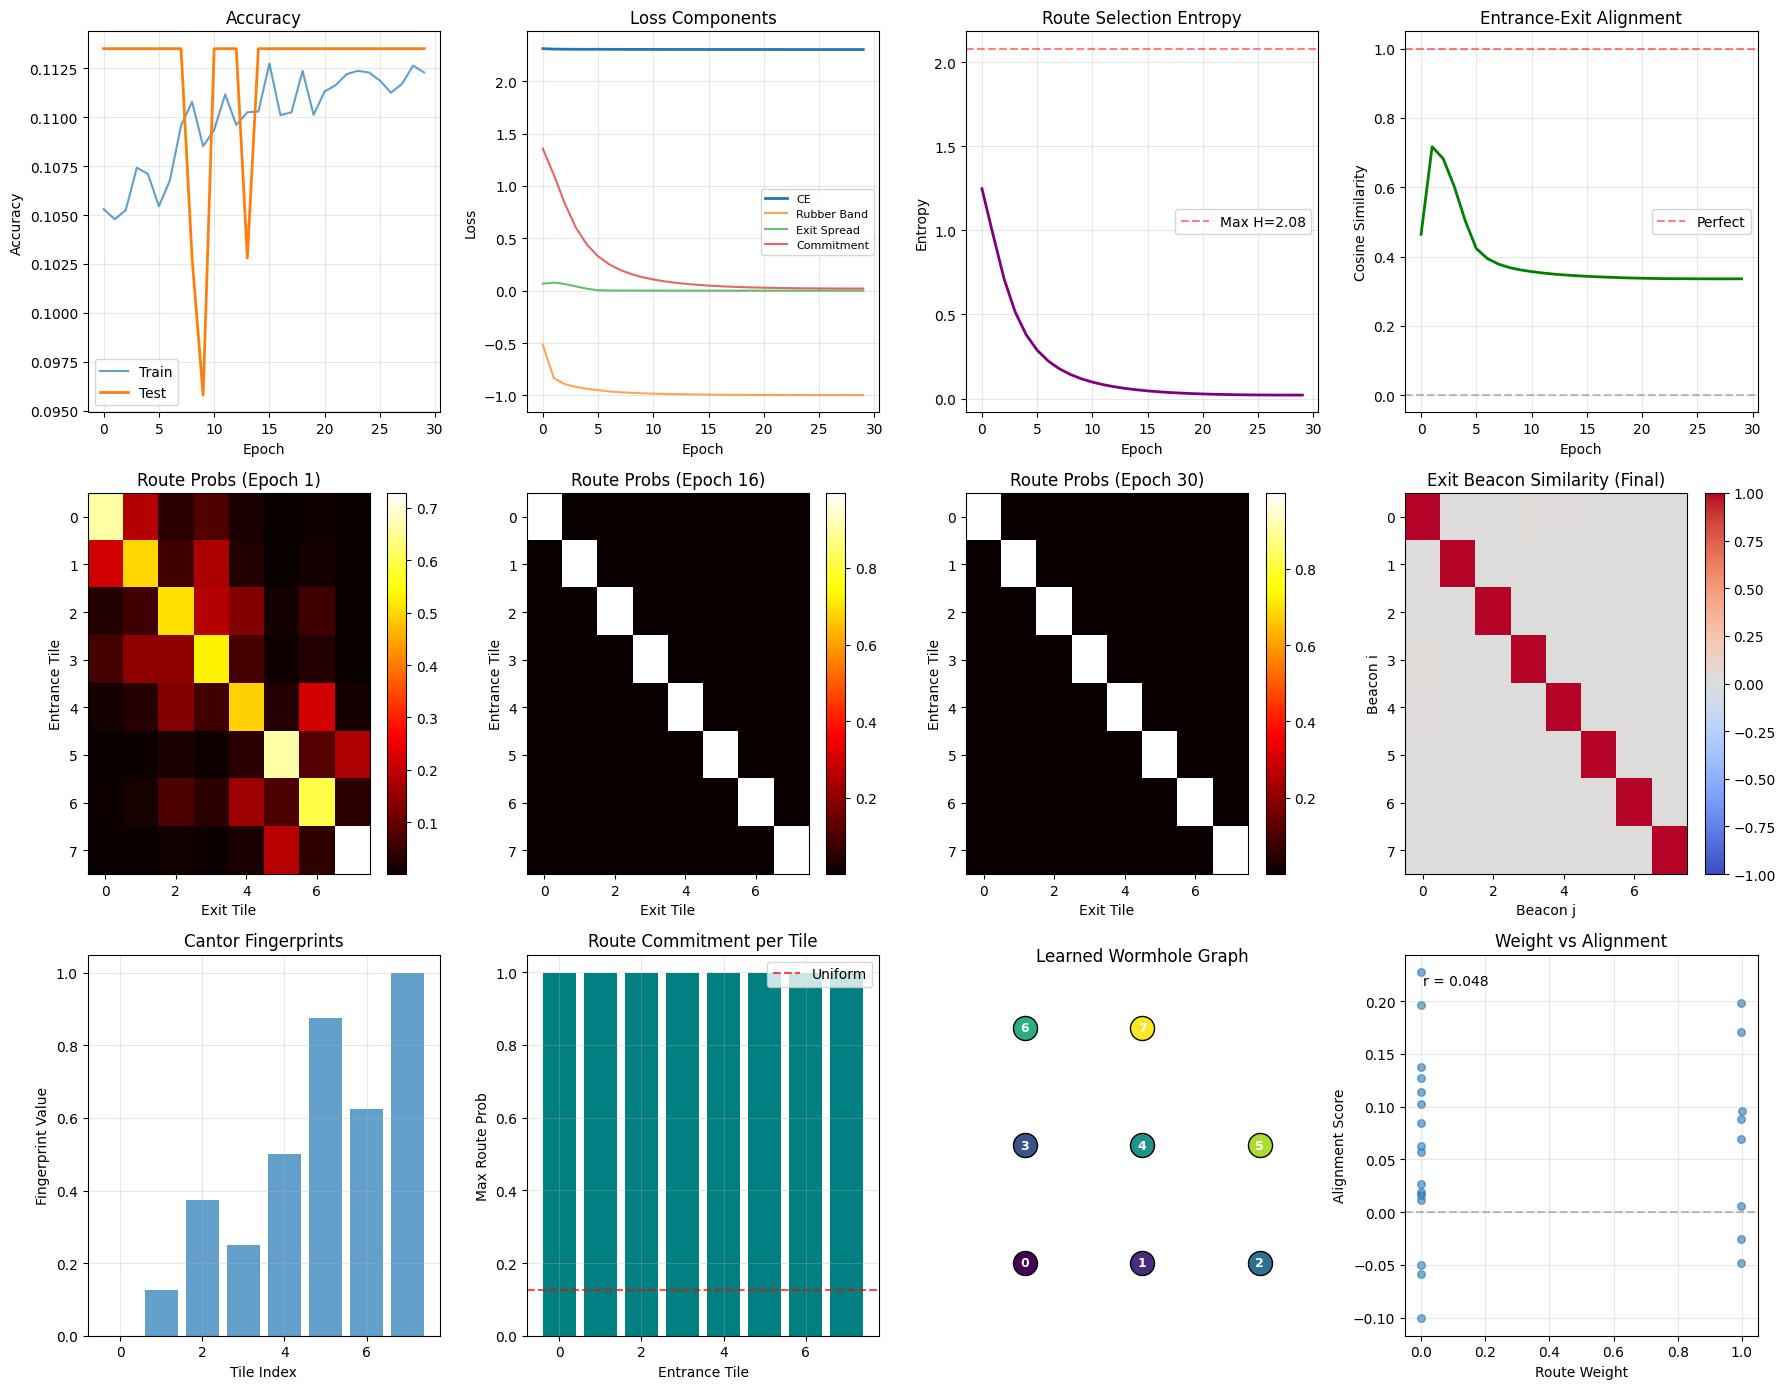

In [16]:
"""
Wormhole Alignment Experiment
=============================

Core hypothesis: Wormholes need bidirectional alignment pressure.
- Entrance must "find" a meaningful exit
- Exit must provide a target signal back
- Rubber band loss creates elastic tension

MNIST as sandbox - simple enough to deeply analyze.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
from typing import Tuple, Dict, List
import math

# ============================================================================
# CONFIGURATION
# ============================================================================

@dataclass
class WormholeConfig:
    dim: int = 64
    num_tiles: int = 8
    num_wormholes: int = 3
    num_layers: int = 2

    # Alignment losses
    rubber_band_weight: float = 0.1      # Pull connected tiles together
    exit_target_weight: float = 0.1      # Target signal at exits
    commitment_weight: float = 0.05      # Encourage sharp routing

    temperature: float = 0.5
    dropout: float = 0.1

    @property
    def tile_dim(self) -> int:
        return self.dim // self.num_tiles


# ============================================================================
# WORMHOLE WITH ALIGNMENT TARGETS
# ============================================================================

class AlignedWormholeRouter(nn.Module):
    """
    Wormholes with bidirectional alignment:
    - Entrance learns which exit to target
    - Exit has learnable target embedding (the "beacon")
    - Rubber band loss pulls entrance-exit pairs into alignment
    """

    def __init__(self, config: WormholeConfig):
        super().__init__()
        self.config = config
        self.num_tiles = config.num_tiles
        self.num_wormholes = config.num_wormholes
        self.tile_dim = config.tile_dim

        # Cantor fingerprints (fixed geometric prior)
        fingerprints = self._compute_cantor_fingerprints()
        self.register_buffer('fingerprints', fingerprints)

        # Learnable route logits: which tiles can connect
        # Initialize with Cantor distance prior
        cantor_dist = self._cantor_distance_matrix(fingerprints)
        self.route_logits = nn.Parameter(-cantor_dist * 3.0)  # Closer = higher

        # EXIT TARGETS: Each tile has a learnable "beacon" embedding
        # Wormholes are attracted to beacons at their exit points
        self.exit_beacons = nn.Parameter(
            torch.randn(config.num_tiles, config.tile_dim) * 0.1
        )

        # ENTRANCE QUERY: Projects tile content to query space for alignment
        self.entrance_proj = nn.Linear(config.tile_dim, config.tile_dim)

        # Temperature for sharpening (can anneal)
        self.register_buffer('temperature', torch.tensor(config.temperature))

    def _compute_cantor_fingerprints(self) -> torch.Tensor:
        T = self.num_tiles
        grid = int(math.ceil(math.sqrt(T)))
        x = torch.arange(T) % grid
        y = torch.arange(T) // grid
        sums = x + y
        z = (sums * (sums + 1)) // 2 + y
        return z.float() / z.max().clamp(min=1)

    def _cantor_distance_matrix(self, fp: torch.Tensor) -> torch.Tensor:
        return (fp.unsqueeze(0) - fp.unsqueeze(1)).abs()

    def forward(
        self,
        x_tiles: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, Dict]:
        """
        Args:
            x_tiles: [B, S, num_tiles, tile_dim]

        Returns:
            routes: [num_tiles, num_wormholes] - exit indices
            weights: [B, S, num_tiles, num_wormholes] - soft routing
            alignment_info: dict with losses and diagnostics
        """
        B, S, T, D = x_tiles.shape
        device = x_tiles.device

        # === ROUTE SELECTION ===
        # Softmax over route logits (which exits each entrance prefers)
        route_probs = F.softmax(self.route_logits / self.temperature, dim=-1)  # [T, T]

        # Top-k exits per entrance
        topk_weights, routes = torch.topk(
            route_probs, self.num_wormholes, dim=-1
        )  # [T, K], [T, K]

        # Renormalize weights over selected routes
        weights = topk_weights / topk_weights.sum(dim=-1, keepdim=True)
        weights = weights.unsqueeze(0).unsqueeze(0).expand(B, S, -1, -1)

        # === ALIGNMENT LOSSES ===

        # 1. RUBBER BAND: Pull entrance representation toward exit beacon
        # Query: project tile content
        entrance_queries = self.entrance_proj(x_tiles)  # [B, S, T, D]

        # For each entrance, compute alignment to its selected exit beacons
        # routes: [T, K] - which beacons each tile connects to
        selected_beacons = self.exit_beacons[routes]  # [T, K, D]

        # Entrance-to-beacon similarity (cosine)
        entrance_norm = F.normalize(entrance_queries, dim=-1)  # [B, S, T, D]
        beacon_norm = F.normalize(selected_beacons, dim=-1)    # [T, K, D]

        # For each entrance tile, compute similarity to its wormhole exits
        # entrance_norm: [B, S, T, D] -> [B, S, T, 1, D]
        # beacon_norm: [T, K, D] -> [1, 1, T, K, D]
        alignment = torch.einsum(
            'bstd,tkd->bstk',
            entrance_norm,
            beacon_norm
        )  # [B, S, T, K]

        # Rubber band loss: maximize alignment (minimize negative)
        # Weight by routing weights (focus on actually-used routes)
        rubber_band_loss = -(alignment * weights).sum(dim=-1).mean()

        # 2. EXIT TARGET: Beacons should be distinctive (spread apart)
        beacon_sim = torch.mm(
            F.normalize(self.exit_beacons, dim=-1),
            F.normalize(self.exit_beacons, dim=-1).T
        )  # [T, T]
        # Off-diagonal similarity should be low
        eye = torch.eye(T, device=device)
        exit_spread_loss = (beacon_sim * (1 - eye)).pow(2).mean()

        # 3. COMMITMENT: Entropy of route selection should be low
        route_entropy = -(route_probs * (route_probs + 1e-8).log()).sum(-1)
        commitment_loss = route_entropy.mean()

        # 4. DIVERSITY: Different tiles should use different routes
        # Aggregate route usage across tiles
        route_usage = route_probs.sum(dim=0)  # [T] - how much each exit is used
        route_usage = route_usage / route_usage.sum()
        usage_entropy = -(route_usage * (route_usage + 1e-8).log()).sum()
        diversity_loss = -usage_entropy  # Maximize entropy

        alignment_info = {
            'rubber_band': rubber_band_loss,
            'exit_spread': exit_spread_loss,
            'commitment': commitment_loss,
            'diversity': diversity_loss,
            'route_probs': route_probs.detach(),
            'alignment_scores': alignment.mean(dim=(0, 1)).detach(),  # [T, K]
            'beacon_similarity': beacon_sim.detach(),
            'weights': weights.mean(dim=(0, 1)).detach(),
        }

        return routes, weights, alignment_info


# ============================================================================
# TESSELLATION EXPERT WITH ALIGNED WORMHOLES
# ============================================================================

class AlignedTessellationExpert(nn.Module):
    """Tile processor that uses aligned wormhole connections."""

    def __init__(self, config: WormholeConfig):
        super().__init__()
        self.config = config
        self.router = AlignedWormholeRouter(config)

        # Process: self tile + gathered wormhole context
        input_dim = config.tile_dim * (1 + config.num_wormholes)
        hidden_dim = config.tile_dim * 2

        self.processor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(config.dropout),
            nn.Linear(hidden_dim, config.tile_dim)
        )

        self.norm = nn.LayerNorm(config.dim)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, Dict]:
        B, S, D = x.shape
        x_norm = self.norm(x)

        # Tessellate
        x_tiles = x_norm.view(B, S, self.config.num_tiles, self.config.tile_dim)

        # Get aligned wormhole routes
        routes, weights, alignment_info = self.router(x_tiles)

        # Gather from wormhole exits
        x_flat = x_tiles.reshape(B * S, self.config.num_tiles, self.config.tile_dim)
        routes_exp = routes.unsqueeze(0).expand(B * S, -1, -1)

        batch_idx = torch.arange(B * S, device=x.device).view(-1, 1, 1)
        neighbors = x_flat[batch_idx, routes_exp, :]
        neighbors = neighbors.view(B, S, self.config.num_tiles, self.config.num_wormholes, self.config.tile_dim)

        # Weight and sum neighbors
        weights_exp = weights.unsqueeze(-1)
        wormhole_context = (neighbors * weights_exp).sum(dim=3)  # [B, S, T, D]

        # Concatenate self + wormhole context
        combined = torch.cat([x_tiles, neighbors.view(B, S, self.config.num_tiles, -1)], dim=-1)

        # Truncate/pad to expected input size
        expected = self.config.tile_dim * (1 + self.config.num_wormholes)
        if combined.shape[-1] > expected:
            combined = combined[..., :expected]
        elif combined.shape[-1] < expected:
            combined = F.pad(combined, (0, expected - combined.shape[-1]))

        # Process
        combined_flat = combined.reshape(B * S * self.config.num_tiles, -1)
        out_tiles = self.processor(combined_flat)
        out_tiles = out_tiles.view(B, S, self.config.num_tiles, self.config.tile_dim)

        # Reconstruct
        out = out_tiles.reshape(B, S, D)
        out = x + out  # Residual

        return out, alignment_info


# ============================================================================
# SIMPLE MODEL FOR MNIST
# ============================================================================

class WormholeMNIST(nn.Module):
    """Minimal model for analyzing wormhole behavior on MNIST."""

    def __init__(self, config: WormholeConfig):
        super().__init__()
        self.config = config

        # Simple patch embedding: 28x28 -> 7x7 patches -> 49 tokens
        self.patch_size = 4
        self.num_patches = 49  # 7x7

        self.patch_embed = nn.Conv2d(1, config.dim, kernel_size=4, stride=4)
        self.cls_token = nn.Parameter(torch.randn(1, 1, config.dim) * 0.02)
        self.pos_embed = nn.Parameter(torch.randn(1, 50, config.dim) * 0.02)

        # Layers
        self.layers = nn.ModuleList([
            AlignedTessellationExpert(config)
            for _ in range(config.num_layers)
        ])

        self.norm = nn.LayerNorm(config.dim)
        self.head = nn.Linear(config.dim, 10)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, List[Dict]]:
        B = x.shape[0]

        # Embed
        x = self.patch_embed(x).flatten(2).transpose(1, 2)
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)
        x = x + self.pos_embed

        # Process
        all_info = []
        for layer in self.layers:
            x, info = layer(x)
            all_info.append(info)

        # Classify
        x = self.norm(x)
        logits = self.head(x[:, 0])

        return logits, all_info


# ============================================================================
# TRAINING WITH ALIGNMENT ANALYSIS
# ============================================================================

def train_wormhole_mnist(
    epochs: int = 30,
    batch_size: int = 128,
    lr: float = 3e-4,
    config: WormholeConfig = None
):
    """Train with detailed wormhole analysis."""

    import torchvision
    import torchvision.transforms as T
    from torch.utils.data import DataLoader

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if config is None:
        config = WormholeConfig()

    # Data
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize((0.1307,), (0.3081,))
    ])

    train_data = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_data = torchvision.datasets.MNIST('./data', train=False, transform=transform)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=2)

    # Model
    model = WormholeMNIST(config).to(device)
    params = sum(p.numel() for p in model.parameters())

    print(f"Wormhole MNIST Experiment")
    print(f"  Dim: {config.dim}, Tiles: {config.num_tiles} × {config.tile_dim}d")
    print(f"  Wormholes: {config.num_wormholes} per tile")
    print(f"  Alignment weights: rubber={config.rubber_band_weight}, "
          f"exit={config.exit_target_weight}, commit={config.commitment_weight}")
    print(f"  Parameters: {params:,}")
    print()

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

    # Detailed tracking
    history = {
        'train_acc': [], 'test_acc': [],
        'ce_loss': [], 'rubber_band': [], 'exit_spread': [],
        'commitment': [], 'diversity': [],
        'route_entropy': [], 'alignment_mean': [],
        'route_probs_history': [],  # Full route probability matrices
        'beacon_sim_history': [],   # Beacon similarity over time
    }

    best_acc = 0

    for epoch in range(epochs):
        # === TRAIN ===
        model.train()
        train_correct, train_total = 0, 0
        epoch_losses = {'ce': 0, 'rb': 0, 'ex': 0, 'cm': 0, 'dv': 0}
        epoch_alignment = []

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            logits, layer_info = model(imgs)

            # CE loss
            ce_loss = F.cross_entropy(logits, labels)

            # Aggregate alignment losses from all layers
            total_rb, total_ex, total_cm, total_dv = 0, 0, 0, 0
            for info in layer_info:
                total_rb += info['rubber_band']
                total_ex += info['exit_spread']
                total_cm += info['commitment']
                total_dv += info['diversity']

            total_rb /= len(layer_info)
            total_ex /= len(layer_info)
            total_cm /= len(layer_info)
            total_dv /= len(layer_info)

            # Total loss
            loss = (
                ce_loss +
                config.rubber_band_weight * total_rb +
                config.exit_target_weight * total_ex +
                config.commitment_weight * total_cm +
                config.commitment_weight * total_dv
            )

            loss.backward()
            optimizer.step()

            # Track
            train_correct += (logits.argmax(1) == labels).sum().item()
            train_total += imgs.size(0)

            epoch_losses['ce'] += ce_loss.item()
            epoch_losses['rb'] += total_rb.item()
            epoch_losses['ex'] += total_ex.item()
            epoch_losses['cm'] += total_cm.item()
            epoch_losses['dv'] += total_dv.item()

            epoch_alignment.append(layer_info[-1]['alignment_scores'].cpu())

        scheduler.step()

        n_batches = len(train_loader)
        train_acc = train_correct / train_total

        # === EVAL ===
        model.eval()
        test_correct, test_total = 0, 0

        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                logits, _ = model(imgs)
                test_correct += (logits.argmax(1) == labels).sum().item()
                test_total += imgs.size(0)

        test_acc = test_correct / test_total

        # Get final routing state
        with torch.no_grad():
            dummy = torch.randn(1, 50, config.dim, device=device)
            _, layer_info = model.layers[-1](dummy)
            route_probs = layer_info['route_probs'].cpu()
            beacon_sim = layer_info['beacon_similarity'].cpu()

        # Compute route entropy
        route_entropy = -(route_probs * (route_probs + 1e-8).log()).sum(-1).mean().item()

        # Average alignment score
        align_mean = torch.stack(epoch_alignment).mean().item()

        # Store history
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['ce_loss'].append(epoch_losses['ce'] / n_batches)
        history['rubber_band'].append(epoch_losses['rb'] / n_batches)
        history['exit_spread'].append(epoch_losses['ex'] / n_batches)
        history['commitment'].append(epoch_losses['cm'] / n_batches)
        history['diversity'].append(epoch_losses['dv'] / n_batches)
        history['route_entropy'].append(route_entropy)
        history['alignment_mean'].append(align_mean)
        history['route_probs_history'].append(route_probs.numpy())
        history['beacon_sim_history'].append(beacon_sim.numpy())

        if test_acc > best_acc:
            best_acc = test_acc
            marker = " ★"
        else:
            marker = ""

        print(f"Epoch {epoch+1:2d} | "
              f"Train: {train_acc*100:.1f}% | Test: {test_acc*100:.1f}%{marker} | "
              f"H(route): {route_entropy:.2f} | "
              f"Align: {align_mean:.3f} | "
              f"RB: {epoch_losses['rb']/n_batches:.3f}")

    print(f"\nBest: {best_acc*100:.2f}%")

    return model, history, config


# ============================================================================
# COMPREHENSIVE VISUALIZATION
# ============================================================================

def analyze_wormholes(model, history, config):
    """Deep analysis of wormhole behavior."""

    fig = plt.figure(figsize=(18, 14))

    # 1. Training curves
    ax1 = fig.add_subplot(3, 4, 1)
    ax1.plot(history['train_acc'], label='Train', alpha=0.7)
    ax1.plot(history['test_acc'], label='Test', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. All losses
    ax2 = fig.add_subplot(3, 4, 2)
    ax2.plot(history['ce_loss'], label='CE', linewidth=2)
    ax2.plot(history['rubber_band'], label='Rubber Band', alpha=0.7)
    ax2.plot(history['exit_spread'], label='Exit Spread', alpha=0.7)
    ax2.plot(history['commitment'], label='Commitment', alpha=0.7)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Loss Components')
    ax2.legend(fontsize=8)
    ax2.grid(True, alpha=0.3)

    # 3. Route entropy over time
    ax3 = fig.add_subplot(3, 4, 3)
    ax3.plot(history['route_entropy'], color='purple', linewidth=2)
    max_entropy = np.log(config.num_tiles)
    ax3.axhline(max_entropy, color='red', linestyle='--', alpha=0.5, label=f'Max H={max_entropy:.2f}')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Entropy')
    ax3.set_title('Route Selection Entropy')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Alignment score over time
    ax4 = fig.add_subplot(3, 4, 4)
    ax4.plot(history['alignment_mean'], color='green', linewidth=2)
    ax4.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax4.axhline(1, color='red', linestyle='--', alpha=0.5, label='Perfect')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Cosine Similarity')
    ax4.set_title('Entrance-Exit Alignment')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # 5. Route probability matrix evolution (start)
    ax5 = fig.add_subplot(3, 4, 5)
    im5 = ax5.imshow(history['route_probs_history'][0], cmap='hot', aspect='auto')
    ax5.set_xlabel('Exit Tile')
    ax5.set_ylabel('Entrance Tile')
    ax5.set_title('Route Probs (Epoch 1)')
    plt.colorbar(im5, ax=ax5)

    # 6. Route probability matrix (middle)
    mid = len(history['route_probs_history']) // 2
    ax6 = fig.add_subplot(3, 4, 6)
    im6 = ax6.imshow(history['route_probs_history'][mid], cmap='hot', aspect='auto')
    ax6.set_xlabel('Exit Tile')
    ax6.set_ylabel('Entrance Tile')
    ax6.set_title(f'Route Probs (Epoch {mid+1})')
    plt.colorbar(im6, ax=ax6)

    # 7. Route probability matrix (end)
    ax7 = fig.add_subplot(3, 4, 7)
    im7 = ax7.imshow(history['route_probs_history'][-1], cmap='hot', aspect='auto')
    ax7.set_xlabel('Exit Tile')
    ax7.set_ylabel('Entrance Tile')
    ax7.set_title(f'Route Probs (Epoch {len(history["route_probs_history"])})')
    plt.colorbar(im7, ax=ax7)

    # 8. Beacon similarity matrix (final)
    ax8 = fig.add_subplot(3, 4, 8)
    im8 = ax8.imshow(history['beacon_sim_history'][-1], cmap='coolwarm',
                     vmin=-1, vmax=1, aspect='auto')
    ax8.set_xlabel('Beacon j')
    ax8.set_ylabel('Beacon i')
    ax8.set_title('Exit Beacon Similarity (Final)')
    plt.colorbar(im8, ax=ax8)

    # 9. Cantor fingerprint vs learned routes
    ax9 = fig.add_subplot(3, 4, 9)
    router = model.layers[-1].router
    fingerprints = router.fingerprints.cpu().numpy()

    # Plot fingerprints
    T = config.num_tiles
    x_pos = np.arange(T)
    ax9.bar(x_pos, fingerprints, alpha=0.7, label='Cantor FP')
    ax9.set_xlabel('Tile Index')
    ax9.set_ylabel('Fingerprint Value')
    ax9.set_title('Cantor Fingerprints')
    ax9.grid(True, alpha=0.3)

    # 10. Route concentration per tile
    ax10 = fig.add_subplot(3, 4, 10)
    final_probs = history['route_probs_history'][-1]
    max_probs = final_probs.max(axis=1)
    ax10.bar(np.arange(T), max_probs, color='teal')
    ax10.axhline(1/T, color='red', linestyle='--', label='Uniform', alpha=0.7)
    ax10.set_xlabel('Entrance Tile')
    ax10.set_ylabel('Max Route Prob')
    ax10.set_title('Route Commitment per Tile')
    ax10.legend()
    ax10.grid(True, alpha=0.3)

    # 11. Wormhole graph visualization
    ax11 = fig.add_subplot(3, 4, 11)
    grid = int(np.ceil(np.sqrt(T)))

    # Draw tiles
    for i in range(T):
        x_i, y_i = i % grid, i // grid
        color = plt.cm.viridis(fingerprints[i])
        ax11.scatter(x_i, y_i, c=[color], s=300, zorder=3, edgecolors='black')
        ax11.text(x_i, y_i, str(i), ha='center', va='center', fontsize=9, color='white', fontweight='bold')

    # Draw wormhole connections (top-k per tile)
    final_probs = history['route_probs_history'][-1]
    for i in range(T):
        x_i, y_i = i % grid, i // grid
        top_k = np.argsort(final_probs[i])[-config.num_wormholes:]
        for j in top_k:
            if i != j:
                x_j, y_j = j % grid, j // grid
                weight = final_probs[i, j]
                ax11.annotate('', xy=(x_j, y_j), xytext=(x_i, y_i),
                             arrowprops=dict(arrowstyle='->', color='red',
                                           alpha=min(1.0, weight * 3), lw=weight * 4))

    ax11.set_title('Learned Wormhole Graph')
    ax11.set_xlim(-0.5, grid - 0.5)
    ax11.set_ylim(-0.5, grid - 0.5)
    ax11.set_aspect('equal')
    ax11.axis('off')

    # 12. Alignment vs Route weight scatter
    ax12 = fig.add_subplot(3, 4, 12)

    # Get final alignment and weights
    with torch.no_grad():
        device = next(model.parameters()).device
        dummy = torch.randn(1, 50, config.dim, device=device)
        _, layer_info = model.layers[-1](dummy)
        final_weights = layer_info['weights'].cpu().numpy()  # [T, K]
        final_align = layer_info['alignment_scores'].cpu().numpy()  # [T, K]

    ax12.scatter(final_weights.flatten(), final_align.flatten(), alpha=0.6, s=30)
    ax12.set_xlabel('Route Weight')
    ax12.set_ylabel('Alignment Score')
    ax12.set_title('Weight vs Alignment')
    ax12.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax12.grid(True, alpha=0.3)

    # Correlation
    corr = np.corrcoef(final_weights.flatten(), final_align.flatten())[0, 1]
    ax12.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax12.transAxes,
              fontsize=10, verticalalignment='top')

    plt.tight_layout()
    plt.savefig('wormhole_alignment_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

    return fig


# ============================================================================
# RUN
# ============================================================================

if __name__ == "__main__":
    print("=" * 70)
    print("WORMHOLE ALIGNMENT EXPERIMENT - MNIST")
    print("=" * 70)
    print()

    config = WormholeConfig(
        dim=64,
        num_tiles=8,
        num_wormholes=3,
        num_layers=2,
        rubber_band_weight=0.1,
        exit_target_weight=0.1,
        commitment_weight=0.05,
        temperature=0.5,
    )

    model, history, config = train_wormhole_mnist(
        epochs=30,
        batch_size=128,
        lr=3e-4,
        config=config
    )

    fig = analyze_wormholes(model, history, config)


EXPERIMENT 1: TILE ADDITION
TASK: TILE ADDITION
Required routing: Tile 0↔2, Tile 1↔3
If model learns correct routing, MSE → 0

Epoch  10 | Loss: 52.3221 | Edge Acc: 100% | Edges: {'0→2': 0.3333333432674408, '1→3': 0.3333333432674408, '2→0': 0.3333333432674408, '3→1': 0.3333333432674408}
Epoch  20 | Loss: 11.0674 | Edge Acc: 100% | Edges: {'0→2': 0.3333333432674408, '1→3': 0.3333333432674408, '2→0': 0.3333333432674408, '3→1': 0.3333333432674408}
Epoch  30 | Loss: 7.1861 | Edge Acc: 100% | Edges: {'0→2': 0.3333333432674408, '1→3': 0.3333333432674408, '2→0': 0.3333333432674408, '3→1': 0.3333333432674408}
Epoch  40 | Loss: 6.8182 | Edge Acc: 100% | Edges: {'0→2': 0.3333333432674408, '1→3': 0.3333333432674408, '2→0': 0.3333333432674408, '3→1': 0.3333333432674408}
Epoch  50 | Loss: 4.1667 | Edge Acc: 100% | Edges: {'0→2': 0.3333333432674408, '1→3': 0.3333333432674408, '2→0': 0.3333333432674408, '3→1': 0.3333333432674408}
Epoch  60 | Loss: 2.4864 | Edge Acc: 100% | Edges: {'0→2': 0.333333343

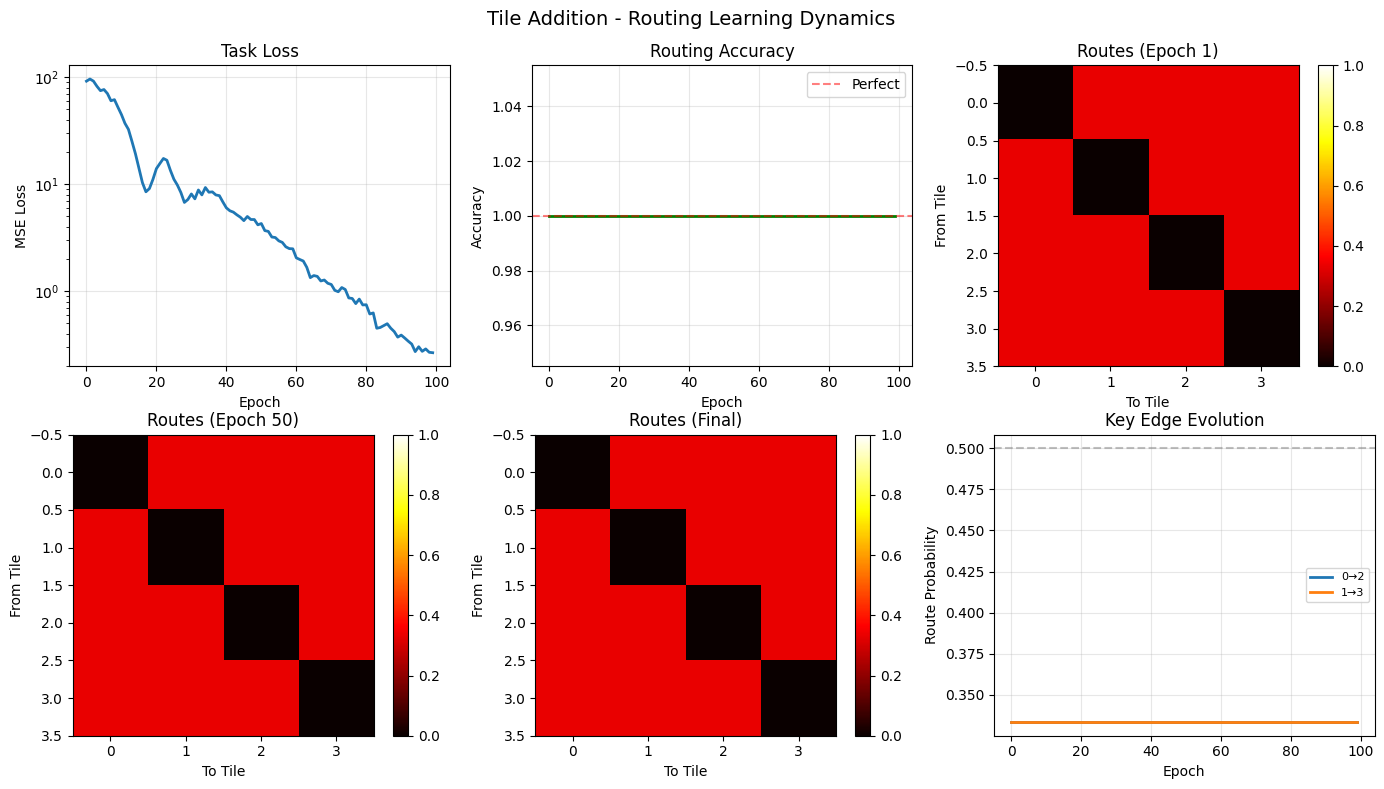


EXPERIMENT 2: PERMUTATION RECOVERY
Permutation: [1, 3, 0, 2]
Inverse:     [2, 0, 3, 1]

TASK: PERMUTATION RECOVERY
Model must learn inverse permutation via routing

Epoch  20 | Loss: 0.5569 | Route Acc: 25%
Epoch  40 | Loss: 0.0727 | Route Acc: 25%
Epoch  60 | Loss: 0.0122 | Route Acc: 25%
Epoch  80 | Loss: 0.0039 | Route Acc: 25%
Epoch 100 | Loss: 0.0030 | Route Acc: 25%
Epoch 120 | Loss: 0.0023 | Route Acc: 25%
Epoch 140 | Loss: 0.0010 | Route Acc: 25%
Epoch 160 | Loss: 0.0006 | Route Acc: 25%
Epoch 180 | Loss: 0.0006 | Route Acc: 25%
Epoch 200 | Loss: 0.0003 | Route Acc: 25%

FINAL ROUTING ANALYSIS
Position Accuracy: 25%

Expected routing (inverse perm): [2, 0, 3, 1]
Learned routing (argmax per row):
  [1, 0, 0, 0]

Final Route Matrix:
[[0.   0.33 0.33 0.33]
 [0.33 0.   0.33 0.33]
 [0.33 0.33 0.   0.33]
 [0.33 0.33 0.33 0.  ]]


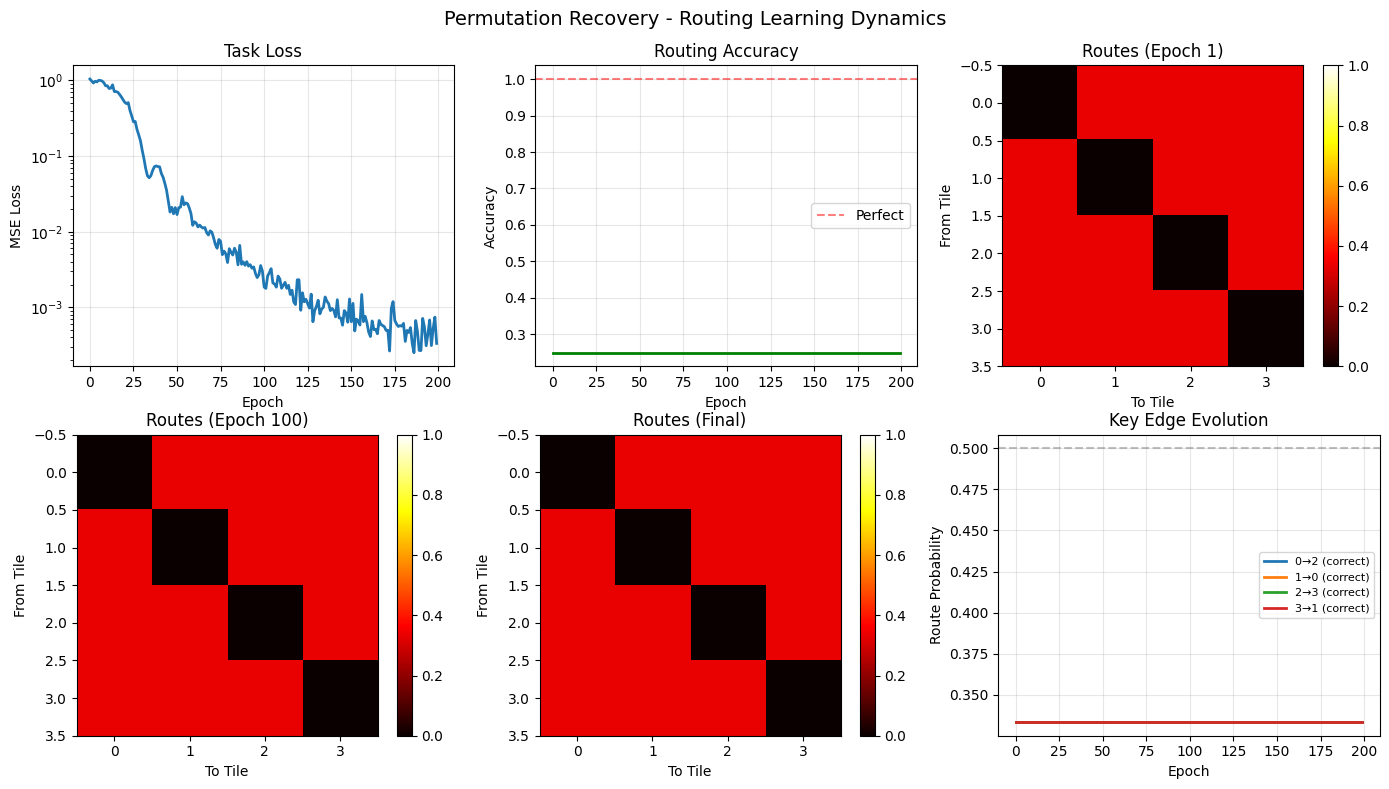


SUMMARY
Tile Addition - Final Edge Accuracy: 100%
Permutation   - Final Route Accuracy: 25%


In [17]:
"""
Wormhole Routing - Numeric Validation
=====================================

Synthetic tasks where wormhole structure directly determines accuracy.
If routing is wrong, the answer is wrong. No way to game it.

Task 1: Tile-Dependent Sum
    - Each tile holds a digit
    - Must route to specific tiles to compute sum
    - Ground truth routing is KNOWN

Task 2: Permutation Recovery
    - Input is shuffled
    - Wormholes must learn the inverse permutation
    - Accuracy = routing correctness

Task 3: Modular Collaboration
    - Each tile computes mod by different prime
    - Must combine via Chinese Remainder Theorem pattern
    - Wrong routes = wrong reconstruction
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
from typing import Tuple, Dict, List
import math


@dataclass
class NumericWormholeConfig:
    dim: int = 32
    num_tiles: int = 4       # Small for interpretability
    num_wormholes: int = 2   # Each tile can reach 2 others
    temperature: float = 0.5


# ============================================================================
# TASK 1: TILE ADDITION
# ============================================================================
#
# Setup: 4 tiles, each holds a number [0-9]
# Target: Sum of specific tile pairs
#   - Output 0 = tile[0] + tile[2]
#   - Output 1 = tile[1] + tile[3]
#
# Correct routing: Tile 0 must connect to Tile 2, Tile 1 to Tile 3
# This is VERIFIABLE - we know the ground truth graph

class TileAdditionTask:
    """Generate tile addition problems with known routing solution."""

    def __init__(self, num_tiles: int = 4):
        self.num_tiles = num_tiles
        # Ground truth: which tiles must connect
        # For 4 tiles: (0,2) and (1,3) must pair
        self.required_edges = [(0, 2), (1, 3), (2, 0), (3, 1)]

    def generate_batch(self, batch_size: int, device: torch.device):
        # Random digits per tile
        tiles = torch.randint(0, 10, (batch_size, self.num_tiles), device=device).float()

        # Targets: sum of paired tiles
        # target[0] = tiles[0] + tiles[2], target[1] = tiles[1] + tiles[3]
        targets = torch.stack([
            tiles[:, 0] + tiles[:, 2],
            tiles[:, 1] + tiles[:, 3]
        ], dim=1)  # [B, 2]

        return tiles, targets

    def check_routing(self, route_probs: torch.Tensor) -> Dict:
        """Check if learned routes match required structure."""
        # route_probs: [num_tiles, num_tiles]
        T = self.num_tiles

        correct_edges = 0
        total_edges = len(self.required_edges)

        edge_scores = {}
        for (i, j) in self.required_edges:
            # Does tile i route to tile j?
            prob_ij = route_probs[i, j].item()
            edge_scores[f"{i}→{j}"] = prob_ij
            if prob_ij > 0.3:  # Threshold for "connected"
                correct_edges += 1

        return {
            'correct_edges': correct_edges,
            'total_edges': total_edges,
            'edge_accuracy': correct_edges / total_edges,
            'edge_scores': edge_scores
        }


# ============================================================================
# TASK 2: PERMUTATION RECOVERY
# ============================================================================
#
# Setup: Input sequence is permuted by fixed permutation π
# Target: Recover original sequence
# Correct routing: Wormholes must learn π⁻¹

class PermutationTask:
    """Learn to invert a fixed permutation via routing."""

    def __init__(self, num_tiles: int = 4, seed: int = 42):
        self.num_tiles = num_tiles

        # Fixed permutation
        rng = np.random.RandomState(seed)
        self.perm = torch.tensor(rng.permutation(num_tiles))
        self.inv_perm = torch.zeros_like(self.perm)
        self.inv_perm[self.perm] = torch.arange(num_tiles)

        print(f"Permutation: {self.perm.tolist()}")
        print(f"Inverse:     {self.inv_perm.tolist()}")

    def generate_batch(self, batch_size: int, device: torch.device):
        # Random original sequence
        original = torch.randn(batch_size, self.num_tiles, device=device)

        # Permuted input
        permuted = original[:, self.perm]

        # Target: recover original
        return permuted, original

    def check_routing(self, route_probs: torch.Tensor) -> Dict:
        """Check if routing learns inverse permutation."""
        T = self.num_tiles

        # For each input position i, it should route to inv_perm[i]
        correct = 0
        routing_map = {}

        for i in range(T):
            target_j = self.inv_perm[i].item()
            predicted_j = route_probs[i].argmax().item()
            prob = route_probs[i, target_j].item()

            routing_map[f"pos{i}"] = {
                'should_route_to': target_j,
                'max_route': predicted_j,
                'correct_prob': prob
            }

            if predicted_j == target_j:
                correct += 1

        return {
            'position_accuracy': correct / T,
            'routing_map': routing_map
        }


# ============================================================================
# TASK 3: MODULAR ARITHMETIC
# ============================================================================
#
# Setup: Input number N, each tile computes N mod p_i for different primes
# Target: Reconstruct N from residues (CRT-style)
# Correct routing: Tiles must share residues in specific pattern

class ModularTask:
    """Chinese Remainder Theorem style routing requirement."""

    def __init__(self, num_tiles: int = 4):
        self.num_tiles = num_tiles
        self.primes = [2, 3, 5, 7][:num_tiles]
        self.max_n = np.prod(self.primes)  # CRT range

    def generate_batch(self, batch_size: int, device: torch.device):
        # Random numbers in CRT range
        N = torch.randint(0, self.max_n, (batch_size,), device=device)

        # Compute residues per tile
        residues = torch.stack([
            N % p for p in self.primes
        ], dim=1).float()  # [B, num_tiles]

        # Target: original N (as classification over range)
        return residues, N


# ============================================================================
# MINIMAL WORMHOLE MODEL FOR NUMERIC TASKS
# ============================================================================

class WormholeRouter(nn.Module):
    """Simple router with interpretable route matrix."""

    def __init__(self, config: NumericWormholeConfig):
        super().__init__()
        self.num_tiles = config.num_tiles
        self.num_wormholes = config.num_wormholes
        self.temperature = config.temperature

        # Learnable route logits [num_tiles, num_tiles]
        # route_logits[i, j] = how much tile i wants to connect to tile j
        self.route_logits = nn.Parameter(torch.zeros(config.num_tiles, config.num_tiles))

        # Slight self-connection bias initially
        with torch.no_grad():
            self.route_logits.fill_diagonal_(0.5)

    def forward(self) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns:
            route_probs: [T, T] soft routing probabilities
            routes: [T, K] top-k route indices per tile
        """
        # Mask self-connections
        mask = torch.eye(self.num_tiles, device=self.route_logits.device) * -1e9
        logits = self.route_logits + mask

        # Soft routes
        route_probs = F.softmax(logits / self.temperature, dim=-1)

        # Hard top-k routes
        _, routes = torch.topk(route_probs, self.num_wormholes, dim=-1)

        return route_probs, routes


class WormholeTileNet(nn.Module):
    """
    Minimal network: tiles + wormhole routing + aggregation.

    Forward:
    1. Embed each tile independently
    2. Each tile gathers from wormhole neighbors
    3. Process combined representation
    4. Output prediction
    """

    def __init__(self, config: NumericWormholeConfig, output_dim: int = 2):
        super().__init__()
        self.config = config

        # Tile embedding
        self.tile_embed = nn.Linear(1, config.dim)

        # Router
        self.router = WormholeRouter(config)

        # Post-wormhole processing per tile
        # Input: self + gathered neighbors
        wormhole_dim = config.dim * (1 + config.num_wormholes)
        self.tile_process = nn.Sequential(
            nn.Linear(wormhole_dim, config.dim),
            nn.ReLU(),
            nn.Linear(config.dim, config.dim)
        )

        # Global aggregation and output
        self.aggregate = nn.Sequential(
            nn.Linear(config.dim * config.num_tiles, config.dim),
            nn.ReLU(),
            nn.Linear(config.dim, output_dim)
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            x: [B, num_tiles] - one value per tile

        Returns:
            output: [B, output_dim]
            route_probs: [T, T] for analysis
        """
        B, T = x.shape

        # Embed tiles: [B, T] -> [B, T, dim]
        x_embed = self.tile_embed(x.unsqueeze(-1))

        # Get routes
        route_probs, routes = self.router()  # [T, T], [T, K]

        # Gather wormhole neighbors for each tile
        # routes: [T, K] - for each tile, which K tiles to gather
        gathered = x_embed[:, routes, :]  # [B, T, K, dim]

        # Concatenate self + neighbors
        x_self = x_embed.unsqueeze(2)  # [B, T, 1, dim]
        combined = torch.cat([x_self, gathered], dim=2)  # [B, T, 1+K, dim]
        combined = combined.view(B, T, -1)  # [B, T, (1+K)*dim]

        # Process each tile
        processed = self.tile_process(combined)  # [B, T, dim]

        # Aggregate all tiles
        flat = processed.view(B, -1)  # [B, T*dim]
        output = self.aggregate(flat)  # [B, output_dim]

        return output, route_probs


# ============================================================================
# TRAINING WITH ROUTING ANALYSIS
# ============================================================================

def train_tile_addition(
    epochs: int = 100,
    batch_size: int = 256,
    lr: float = 1e-3,
    print_every: int = 10
):
    """Train on tile addition task - routing is directly measurable."""

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    config = NumericWormholeConfig(
        dim=32,
        num_tiles=4,
        num_wormholes=2,
        temperature=0.5
    )

    task = TileAdditionTask(num_tiles=4)
    model = WormholeTileNet(config, output_dim=2).to(device)

    print("=" * 60)
    print("TASK: TILE ADDITION")
    print("=" * 60)
    print(f"Required routing: Tile 0↔2, Tile 1↔3")
    print(f"If model learns correct routing, MSE → 0")
    print()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {
        'loss': [],
        'edge_accuracy': [],
        'route_probs': []
    }

    for epoch in range(epochs):
        tiles, targets = task.generate_batch(batch_size, device)

        optimizer.zero_grad()
        preds, route_probs = model(tiles)
        loss = F.mse_loss(preds, targets)
        loss.backward()
        optimizer.step()

        # Check routing
        routing_info = task.check_routing(route_probs.detach())

        history['loss'].append(loss.item())
        history['edge_accuracy'].append(routing_info['edge_accuracy'])
        history['route_probs'].append(route_probs.detach().cpu().numpy())

        if (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch+1:3d} | "
                  f"Loss: {loss.item():.4f} | "
                  f"Edge Acc: {routing_info['edge_accuracy']*100:.0f}% | "
                  f"Edges: {routing_info['edge_scores']}")

    print("\n" + "=" * 60)
    print("FINAL ROUTING ANALYSIS")
    print("=" * 60)

    final_routing = task.check_routing(route_probs.detach())
    print(f"Edge Accuracy: {final_routing['edge_accuracy']*100:.0f}%")
    print(f"Edge Scores: {final_routing['edge_scores']}")
    print(f"\nFinal Route Matrix:")
    print(route_probs.detach().cpu().numpy().round(2))

    return model, history, task


def train_permutation_recovery(
    epochs: int = 200,
    batch_size: int = 256,
    lr: float = 1e-3,
    print_every: int = 20
):
    """Train on permutation recovery - routing must learn inverse."""

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    config = NumericWormholeConfig(
        dim=32,
        num_tiles=4,
        num_wormholes=1,  # Each position needs exactly 1 source
        temperature=0.3
    )

    task = PermutationTask(num_tiles=4, seed=42)
    model = WormholeTileNet(config, output_dim=4).to(device)

    print("\n" + "=" * 60)
    print("TASK: PERMUTATION RECOVERY")
    print("=" * 60)
    print(f"Model must learn inverse permutation via routing")
    print()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {
        'loss': [],
        'position_accuracy': [],
        'route_probs': []
    }

    for epoch in range(epochs):
        permuted, original = task.generate_batch(batch_size, device)

        optimizer.zero_grad()
        preds, route_probs = model(permuted)
        loss = F.mse_loss(preds, original)
        loss.backward()
        optimizer.step()

        routing_info = task.check_routing(route_probs.detach())

        history['loss'].append(loss.item())
        history['position_accuracy'].append(routing_info['position_accuracy'])
        history['route_probs'].append(route_probs.detach().cpu().numpy())

        if (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch+1:3d} | "
                  f"Loss: {loss.item():.4f} | "
                  f"Route Acc: {routing_info['position_accuracy']*100:.0f}%")

    print("\n" + "=" * 60)
    print("FINAL ROUTING ANALYSIS")
    print("=" * 60)

    final_routing = task.check_routing(route_probs.detach())
    print(f"Position Accuracy: {final_routing['position_accuracy']*100:.0f}%")
    print(f"\nExpected routing (inverse perm): {task.inv_perm.tolist()}")
    print(f"Learned routing (argmax per row):")
    learned = route_probs.detach().argmax(dim=-1).cpu().tolist()
    print(f"  {learned}")
    print(f"\nFinal Route Matrix:")
    print(route_probs.detach().cpu().numpy().round(2))

    return model, history, task


# ============================================================================
# VISUALIZATION
# ============================================================================

def visualize_routing_learning(history, task, task_name: str):
    """Visualize how routing evolves during training."""

    fig, axes = plt.subplots(2, 3, figsize=(14, 8))

    # 1. Loss curve
    ax = axes[0, 0]
    ax.plot(history['loss'], linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE Loss')
    ax.set_title('Task Loss')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)

    # 2. Routing accuracy
    ax = axes[0, 1]
    key = 'edge_accuracy' if 'edge_accuracy' in history else 'position_accuracy'
    ax.plot(history[key], linewidth=2, color='green')
    ax.axhline(1.0, color='red', linestyle='--', alpha=0.5, label='Perfect')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Routing Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 3. Initial route matrix
    ax = axes[0, 2]
    im = ax.imshow(history['route_probs'][0], cmap='hot', vmin=0, vmax=1)
    ax.set_xlabel('To Tile')
    ax.set_ylabel('From Tile')
    ax.set_title('Routes (Epoch 1)')
    plt.colorbar(im, ax=ax)

    # 4. Middle route matrix
    mid = len(history['route_probs']) // 2
    ax = axes[1, 0]
    im = ax.imshow(history['route_probs'][mid], cmap='hot', vmin=0, vmax=1)
    ax.set_xlabel('To Tile')
    ax.set_ylabel('From Tile')
    ax.set_title(f'Routes (Epoch {mid})')
    plt.colorbar(im, ax=ax)

    # 5. Final route matrix
    ax = axes[1, 1]
    im = ax.imshow(history['route_probs'][-1], cmap='hot', vmin=0, vmax=1)
    ax.set_xlabel('To Tile')
    ax.set_ylabel('From Tile')
    ax.set_title('Routes (Final)')
    plt.colorbar(im, ax=ax)

    # 6. Route evolution for specific edges
    ax = axes[1, 2]
    T = history['route_probs'][0].shape[0]

    if hasattr(task, 'required_edges'):
        # Tile addition: track required edges
        for (i, j) in task.required_edges[:2]:  # First 2 edges
            probs = [rp[i, j] for rp in history['route_probs']]
            ax.plot(probs, label=f'{i}→{j}', linewidth=2)
    elif hasattr(task, 'inv_perm'):
        # Permutation: track correct routes
        for i in range(min(T, 4)):
            j = task.inv_perm[i].item()
            probs = [rp[i, j] for rp in history['route_probs']]
            ax.plot(probs, label=f'{i}→{j} (correct)', linewidth=2)

    ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Route Probability')
    ax.set_title('Key Edge Evolution')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    plt.suptitle(f'{task_name} - Routing Learning Dynamics', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'{task_name.lower().replace(" ", "_")}_analysis.png', dpi=150)
    plt.show()

    return fig


# ============================================================================
# RUN EXPERIMENTS
# ============================================================================

if __name__ == "__main__":

    # Experiment 1: Tile Addition
    print("\n" + "=" * 70)
    print("EXPERIMENT 1: TILE ADDITION")
    print("=" * 70)

    model1, history1, task1 = train_tile_addition(
        epochs=100,
        batch_size=256,
        lr=1e-3,
        print_every=10
    )

    fig1 = visualize_routing_learning(history1, task1, "Tile Addition")

    # Experiment 2: Permutation Recovery
    print("\n" + "=" * 70)
    print("EXPERIMENT 2: PERMUTATION RECOVERY")
    print("=" * 70)

    model2, history2, task2 = train_permutation_recovery(
        epochs=200,
        batch_size=256,
        lr=1e-3,
        print_every=20
    )

    fig2 = visualize_routing_learning(history2, task2, "Permutation Recovery")

    print("\n" + "=" * 70)
    print("SUMMARY")
    print("=" * 70)
    print(f"Tile Addition - Final Edge Accuracy: {history1['edge_accuracy'][-1]*100:.0f}%")
    print(f"Permutation   - Final Route Accuracy: {history2['position_accuracy'][-1]*100:.0f}%")


EXPERIMENT: HARD ROUTING BOTTLENECK
BOTTLENECK TILE ADDITION
Parameters: 29 (minimal!)
Required routing: 0→2, 1→3, 2→0, 3→1
Hard top-1 routing - no bypass possible

Epoch  20 | Loss: 88.1025 | Route Acc: 75% | Routes: {0: 3, 1: 3, 2: 0, 3: 1}
Epoch  40 | Loss: 54.5839 | Route Acc: 75% | Routes: {0: 3, 1: 3, 2: 0, 3: 1}
Epoch  60 | Loss: 12.2505 | Route Acc: 75% | Routes: {0: 1, 1: 3, 2: 0, 3: 1}
Epoch  80 | Loss: 10.4270 | Route Acc: 50% | Routes: {0: 3, 1: 0, 2: 0, 3: 1}
Epoch 100 | Loss: 6.9803 | Route Acc: 50% | Routes: {0: 3, 1: 3, 2: 0, 3: 2}
Epoch 120 | Loss: 6.1068 | Route Acc: 50% | Routes: {0: 3, 1: 3, 2: 0, 3: 2}
Epoch 140 | Loss: 6.8204 | Route Acc: 50% | Routes: {0: 3, 1: 3, 2: 0, 3: 2}
Epoch 160 | Loss: 6.4916 | Route Acc: 50% | Routes: {0: 3, 1: 3, 2: 0, 3: 0}
Epoch 180 | Loss: 5.8490 | Route Acc: 50% | Routes: {0: 3, 1: 3, 2: 0, 3: 2}
Epoch 200 | Loss: 5.8936 | Route Acc: 50% | Routes: {0: 3, 1: 3, 2: 0, 3: 2}

FINAL ANALYSIS
Expected: {0: 2, 1: 3, 2: 0, 3: 1}
Learned: 

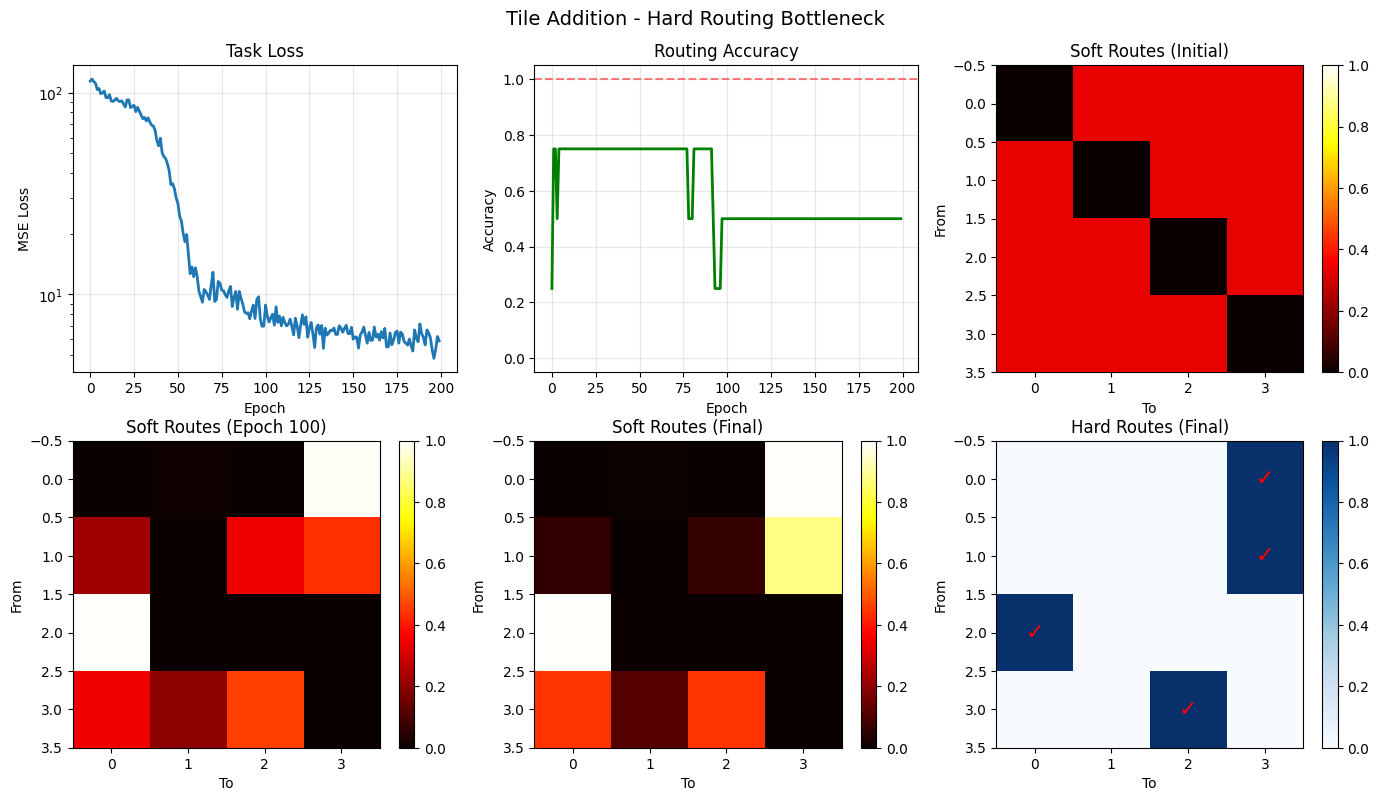

BOTTLENECK PERMUTATION RECOVERY
Permutation: [1, 3, 0, 2]
Inverse (required routes): [2, 0, 3, 1]

Epoch  30 | Loss: 0.000629 | Route Acc: 4/4 | Routes: [2, 0, 3, 1] (need [2, 0, 3, 1])
Epoch  60 | Loss: 0.000029 | Route Acc: 4/4 | Routes: [2, 0, 3, 1] (need [2, 0, 3, 1])
Epoch  90 | Loss: 0.000001 | Route Acc: 4/4 | Routes: [2, 0, 3, 1] (need [2, 0, 3, 1])
Epoch 120 | Loss: 0.000000 | Route Acc: 4/4 | Routes: [2, 0, 3, 1] (need [2, 0, 3, 1])
Epoch 150 | Loss: 0.000000 | Route Acc: 4/4 | Routes: [2, 0, 3, 1] (need [2, 0, 3, 1])
Epoch 180 | Loss: 0.000000 | Route Acc: 4/4 | Routes: [2, 0, 3, 1] (need [2, 0, 3, 1])
Epoch 210 | Loss: 0.000000 | Route Acc: 4/4 | Routes: [2, 0, 3, 1] (need [2, 0, 3, 1])
Epoch 240 | Loss: 0.000000 | Route Acc: 4/4 | Routes: [2, 0, 3, 1] (need [2, 0, 3, 1])
Epoch 270 | Loss: 0.000000 | Route Acc: 4/4 | Routes: [2, 0, 3, 1] (need [2, 0, 3, 1])
Epoch 300 | Loss: 0.000000 | Route Acc: 4/4 | Routes: [2, 0, 3, 1] (need [2, 0, 3, 1])

FINAL
Required: [2, 0, 3, 1]
L

In [18]:
"""
Wormhole Routing - Information Bottleneck Version
=================================================

Key change: Make it IMPOSSIBLE to solve without correct routing.
- Hard top-1 routing (not soft)
- Tiny downstream capacity (can't memorize)
- Route values directly, not embeddings
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
from typing import Tuple, Dict


@dataclass
class BottleneckConfig:
    num_tiles: int = 4
    temperature: float = 0.1  # Sharp!


class HardRouter(nn.Module):
    """Hard top-1 routing with straight-through gradients."""

    def __init__(self, num_tiles: int, temperature: float = 0.1):
        super().__init__()
        self.num_tiles = num_tiles
        self.temperature = temperature

        # Route logits: [num_tiles, num_tiles]
        self.route_logits = nn.Parameter(torch.zeros(num_tiles, num_tiles))

        # Mask self-connections
        self.register_buffer('self_mask', torch.eye(num_tiles) * -1e9)

    def forward(self) -> Tuple[torch.Tensor, torch.Tensor]:
        logits = self.route_logits + self.self_mask

        # Soft probs for gradients
        soft = F.softmax(logits / self.temperature, dim=-1)

        # Hard routing via straight-through
        hard_idx = soft.argmax(dim=-1)  # [T]
        hard = F.one_hot(hard_idx, self.num_tiles).float()  # [T, T]

        # Straight-through: forward uses hard, backward uses soft
        routes = (hard - soft).detach() + soft

        return routes, soft


class BottleneckTileNet(nn.Module):
    """
    Minimal model where routing IS the computation.

    Each tile can ONLY see ONE other tile (hard routing).
    Output = f(tile_i, tile_j) where j = route[i]

    For addition: must route to partner to compute sum.
    """

    def __init__(self, config: BottleneckConfig):
        super().__init__()
        self.num_tiles = config.num_tiles
        self.router = HardRouter(config.num_tiles, config.temperature)

        # TINY output layer - can't memorize, must rely on routing
        # For tile addition: output = a + b, just need to route correctly
        # We give it minimal parameters
        self.combine = nn.Linear(2, 1, bias=True)  # Just 3 params!

        # For the two sums we need
        self.out_proj = nn.Linear(config.num_tiles, 2)

    def forward(self, tiles: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Args:
            tiles: [B, num_tiles] - one value per tile

        Returns:
            output: [B, 2] - the two sums
            hard_routes: [T, T] - one-hot routing
            soft_routes: [T, T] - soft probs for analysis
        """
        B, T = tiles.shape

        # Get hard routes
        hard_routes, soft_routes = self.router()  # [T, T], [T, T]

        # Each tile gathers from its ONE routed partner
        # hard_routes[i] is one-hot for which tile i connects to
        # gathered[b, i] = tiles[b, j] where j = argmax(hard_routes[i])

        # Matrix multiply: [B, T] @ [T, T]^T = [B, T]
        # This selects for each position i, the value at position route[i]
        gathered = torch.matmul(tiles, hard_routes.T)  # [B, T]

        # Now tile i has: (tiles[i], gathered[i]) = (self, partner)
        # Stack for pairwise combination
        pairs = torch.stack([tiles, gathered], dim=-1)  # [B, T, 2]

        # Combine each pair (this learns a + b if routing is correct)
        combined = self.combine(pairs).squeeze(-1)  # [B, T]

        # Project to outputs
        output = self.out_proj(combined)  # [B, 2]

        return output, hard_routes, soft_routes


class TileAdditionTask:
    """Same task but now routing MUST be correct."""

    def __init__(self, num_tiles: int = 4):
        self.num_tiles = num_tiles
        # Required: (0,2), (1,3) for first sum; (2,0), (3,1) for symmetry
        self.required_edges = [(0, 2), (1, 3), (2, 0), (3, 1)]

    def generate_batch(self, batch_size: int, device: torch.device):
        tiles = torch.randint(0, 10, (batch_size, self.num_tiles), device=device).float()
        targets = torch.stack([
            tiles[:, 0] + tiles[:, 2],
            tiles[:, 1] + tiles[:, 3]
        ], dim=1)
        return tiles, targets

    def check_routing(self, hard_routes: torch.Tensor) -> Dict:
        """Check hard routing against required structure."""
        # hard_routes: [T, T] one-hot
        learned_routes = hard_routes.argmax(dim=-1).tolist()  # [T]

        # Check if tile 0 → 2, tile 1 → 3, etc.
        expected = {0: 2, 1: 3, 2: 0, 3: 1}

        correct = sum(1 for i, j in expected.items() if learned_routes[i] == j)

        return {
            'expected': expected,
            'learned': {i: learned_routes[i] for i in range(len(learned_routes))},
            'correct': correct,
            'total': len(expected),
            'accuracy': correct / len(expected)
        }


def train_bottleneck_addition(
    epochs: int = 200,
    batch_size: int = 256,
    lr: float = 1e-2,
    print_every: int = 20
):
    """Train with hard routing bottleneck."""

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    config = BottleneckConfig(num_tiles=4, temperature=0.1)
    task = TileAdditionTask(num_tiles=4)
    model = BottleneckTileNet(config).to(device)

    # Count params
    n_params = sum(p.numel() for p in model.parameters())

    print("=" * 60)
    print("BOTTLENECK TILE ADDITION")
    print("=" * 60)
    print(f"Parameters: {n_params} (minimal!)")
    print(f"Required routing: 0→2, 1→3, 2→0, 3→1")
    print(f"Hard top-1 routing - no bypass possible")
    print()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

    history = {
        'loss': [],
        'route_accuracy': [],
        'hard_routes': [],
        'soft_routes': []
    }

    for epoch in range(epochs):
        tiles, targets = task.generate_batch(batch_size, device)

        optimizer.zero_grad()
        preds, hard_routes, soft_routes = model(tiles)
        loss = F.mse_loss(preds, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()

        routing_info = task.check_routing(hard_routes.detach())

        history['loss'].append(loss.item())
        history['route_accuracy'].append(routing_info['accuracy'])
        history['hard_routes'].append(hard_routes.detach().cpu().numpy())
        history['soft_routes'].append(soft_routes.detach().cpu().numpy())

        if (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch+1:3d} | "
                  f"Loss: {loss.item():.4f} | "
                  f"Route Acc: {routing_info['accuracy']*100:.0f}% | "
                  f"Routes: {routing_info['learned']}")

    print("\n" + "=" * 60)
    print("FINAL ANALYSIS")
    print("=" * 60)

    final_info = task.check_routing(hard_routes.detach())
    print(f"Expected: {final_info['expected']}")
    print(f"Learned:  {final_info['learned']}")
    print(f"Accuracy: {final_info['accuracy']*100:.0f}%")
    print(f"\nSoft Route Matrix:")
    print(soft_routes.detach().cpu().numpy().round(3))
    print(f"\nHard Route Matrix:")
    print(hard_routes.detach().cpu().numpy().round(0).astype(int))

    # Test generalization
    print("\n" + "-" * 40)
    print("GENERALIZATION TEST")
    print("-" * 40)

    model.eval()
    with torch.no_grad():
        test_tiles, test_targets = task.generate_batch(1000, device)
        test_preds, _, _ = model(test_tiles)
        test_mse = F.mse_loss(test_preds, test_targets)

        # Check exact matches (within 0.5)
        correct = ((test_preds - test_targets).abs() < 0.5).all(dim=1).float().mean()

    print(f"Test MSE: {test_mse.item():.4f}")
    print(f"Exact Match: {correct.item()*100:.1f}%")

    return model, history, task


def train_bottleneck_permutation(
    epochs: int = 300,
    batch_size: int = 256,
    lr: float = 1e-2,
    print_every: int = 30
):
    """Train permutation with hard routing bottleneck."""

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    config = BottleneckConfig(num_tiles=4, temperature=0.1)

    # Fixed permutation
    perm = torch.tensor([1, 3, 0, 2])
    inv_perm = torch.zeros_like(perm)
    inv_perm[perm] = torch.arange(4)

    print("=" * 60)
    print("BOTTLENECK PERMUTATION RECOVERY")
    print("=" * 60)
    print(f"Permutation: {perm.tolist()}")
    print(f"Inverse (required routes): {inv_perm.tolist()}")
    print()

    class PermBottleneckNet(nn.Module):
        """Even simpler: route IS the permutation."""

        def __init__(self, num_tiles: int):
            super().__init__()
            self.router = HardRouter(num_tiles, temperature=0.1)
            # No MLP - just routing!
            self.scale = nn.Parameter(torch.ones(1))
            self.bias = nn.Parameter(torch.zeros(1))

        def forward(self, x):
            hard_routes, soft_routes = self.router()
            # Output is simply the permuted input
            # If routes learn inverse perm, this recovers original
            out = torch.matmul(x, hard_routes.T)
            return out * self.scale + self.bias, hard_routes, soft_routes

    model = PermBottleneckNet(4).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {'loss': [], 'route_accuracy': [], 'routes': []}

    for epoch in range(epochs):
        # Generate data
        original = torch.randn(batch_size, 4, device=device)
        permuted = original[:, perm]

        optimizer.zero_grad()
        recovered, hard_routes, soft_routes = model(permuted)
        loss = F.mse_loss(recovered, original)
        loss.backward()
        optimizer.step()

        # Check routes
        learned = hard_routes.argmax(dim=-1).tolist()
        correct = sum(1 for i in range(4) if learned[i] == inv_perm[i].item())

        history['loss'].append(loss.item())
        history['route_accuracy'].append(correct / 4)
        history['routes'].append(learned)

        if (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch+1:3d} | "
                  f"Loss: {loss.item():.6f} | "
                  f"Route Acc: {correct}/4 | "
                  f"Routes: {learned} (need {inv_perm.tolist()})")

    print("\n" + "=" * 60)
    print("FINAL")
    print("=" * 60)
    print(f"Required: {inv_perm.tolist()}")
    print(f"Learned:  {learned}")
    print(f"Soft Routes:\n{soft_routes.detach().cpu().numpy().round(3)}")

    return model, history


def visualize_bottleneck_results(history, task_name):
    """Visualize training with hard routing."""

    fig, axes = plt.subplots(2, 3, figsize=(14, 8))

    # 1. Loss
    ax = axes[0, 0]
    ax.plot(history['loss'], linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE Loss')
    ax.set_title('Task Loss')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)

    # 2. Route accuracy
    ax = axes[0, 1]
    ax.plot(history['route_accuracy'], linewidth=2, color='green')
    ax.axhline(1.0, color='red', linestyle='--', alpha=0.5)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Routing Accuracy')
    ax.set_ylim(-0.05, 1.05)
    ax.grid(True, alpha=0.3)

    # 3. Initial soft routes
    ax = axes[0, 2]
    im = ax.imshow(history['soft_routes'][0], cmap='hot', vmin=0, vmax=1)
    ax.set_xlabel('To')
    ax.set_ylabel('From')
    ax.set_title('Soft Routes (Initial)')
    plt.colorbar(im, ax=ax)

    # 4. Mid soft routes
    mid = len(history['soft_routes']) // 2
    ax = axes[1, 0]
    im = ax.imshow(history['soft_routes'][mid], cmap='hot', vmin=0, vmax=1)
    ax.set_xlabel('To')
    ax.set_ylabel('From')
    ax.set_title(f'Soft Routes (Epoch {mid})')
    plt.colorbar(im, ax=ax)

    # 5. Final soft routes
    ax = axes[1, 1]
    im = ax.imshow(history['soft_routes'][-1], cmap='hot', vmin=0, vmax=1)
    ax.set_xlabel('To')
    ax.set_ylabel('From')
    ax.set_title('Soft Routes (Final)')
    plt.colorbar(im, ax=ax)

    # 6. Final hard routes
    ax = axes[1, 2]
    im = ax.imshow(history['hard_routes'][-1], cmap='Blues', vmin=0, vmax=1)
    ax.set_xlabel('To')
    ax.set_ylabel('From')
    ax.set_title('Hard Routes (Final)')
    for i in range(4):
        for j in range(4):
            val = history['hard_routes'][-1][i, j]
            if val > 0.5:
                ax.text(j, i, '✓', ha='center', va='center', fontsize=16, color='red')
    plt.colorbar(im, ax=ax)

    plt.suptitle(f'{task_name} - Hard Routing Bottleneck', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'{task_name.lower().replace(" ", "_")}_bottleneck.png', dpi=150)
    plt.show()

    return fig


# ============================================================================
# RUN
# ============================================================================

if __name__ == "__main__":

    print("\n" + "=" * 70)
    print("EXPERIMENT: HARD ROUTING BOTTLENECK")
    print("=" * 70)

    # Tile Addition with bottleneck
    model1, history1, task1 = train_bottleneck_addition(
        epochs=200,
        batch_size=256,
        lr=1e-2,
        print_every=20
    )

    fig1 = visualize_bottleneck_results(history1, "Tile Addition")

    # Permutation with bottleneck
    model2, history2 = train_bottleneck_permutation(
        epochs=300,
        batch_size=256,
        lr=1e-2,
        print_every=30
    )

# wormhole routing patch matcher

## decoupled router - no router direct losses - indirect learning

WORMHOLE PATCH MATCHING - FIXED GRADIENTS
Config: 16 patches (4x4)
Router temp: 0.1, Contrast temp: 0.07
Device: cuda

Parameters: 43,082

Gradient flow check:
  encoder.proj      → contrast_loss ✓
  router.query_proj → contrast_loss ✓ (FIXED)
  router.key_proj   → contrast_loss ✓ (FIXED)

Epoch   1 | Loss: 1.692 | Match: 83.5% | Route: 83.5% | Class: 24.9% | Test Route: 98.3% ★ | ∇q: 0.28
Epoch   5 | Loss: 0.907 | Match: 99.2% | Route: 99.2% | Class: 38.2% | Test Route: 99.2% ★ | ∇q: 0.02
Epoch  10 | Loss: 0.847 | Match: 99.4% | Route: 99.4% | Class: 41.9% | Test Route: 99.4% ★ | ∇q: 0.02
Epoch  15 | Loss: 0.820 | Match: 99.5% | Route: 99.5% | Class: 43.7% | Test Route: 99.5% | ∇q: 0.02
Epoch  20 | Loss: 0.805 | Match: 99.5% | Route: 99.5% | Class: 44.6% | Test Route: 99.5% | ∇q: 0.02
Epoch  25 | Loss: 0.788 | Match: 99.6% | Route: 99.6% | Class: 45.9% | Test Route: 99.5% | ∇q: 0.02
Epoch  30 | Loss: 0.778 | Match: 99.6% | Route: 99.6% | Class: 46.4% | Test Route: 99.6% | ∇q: 0.02
Epo

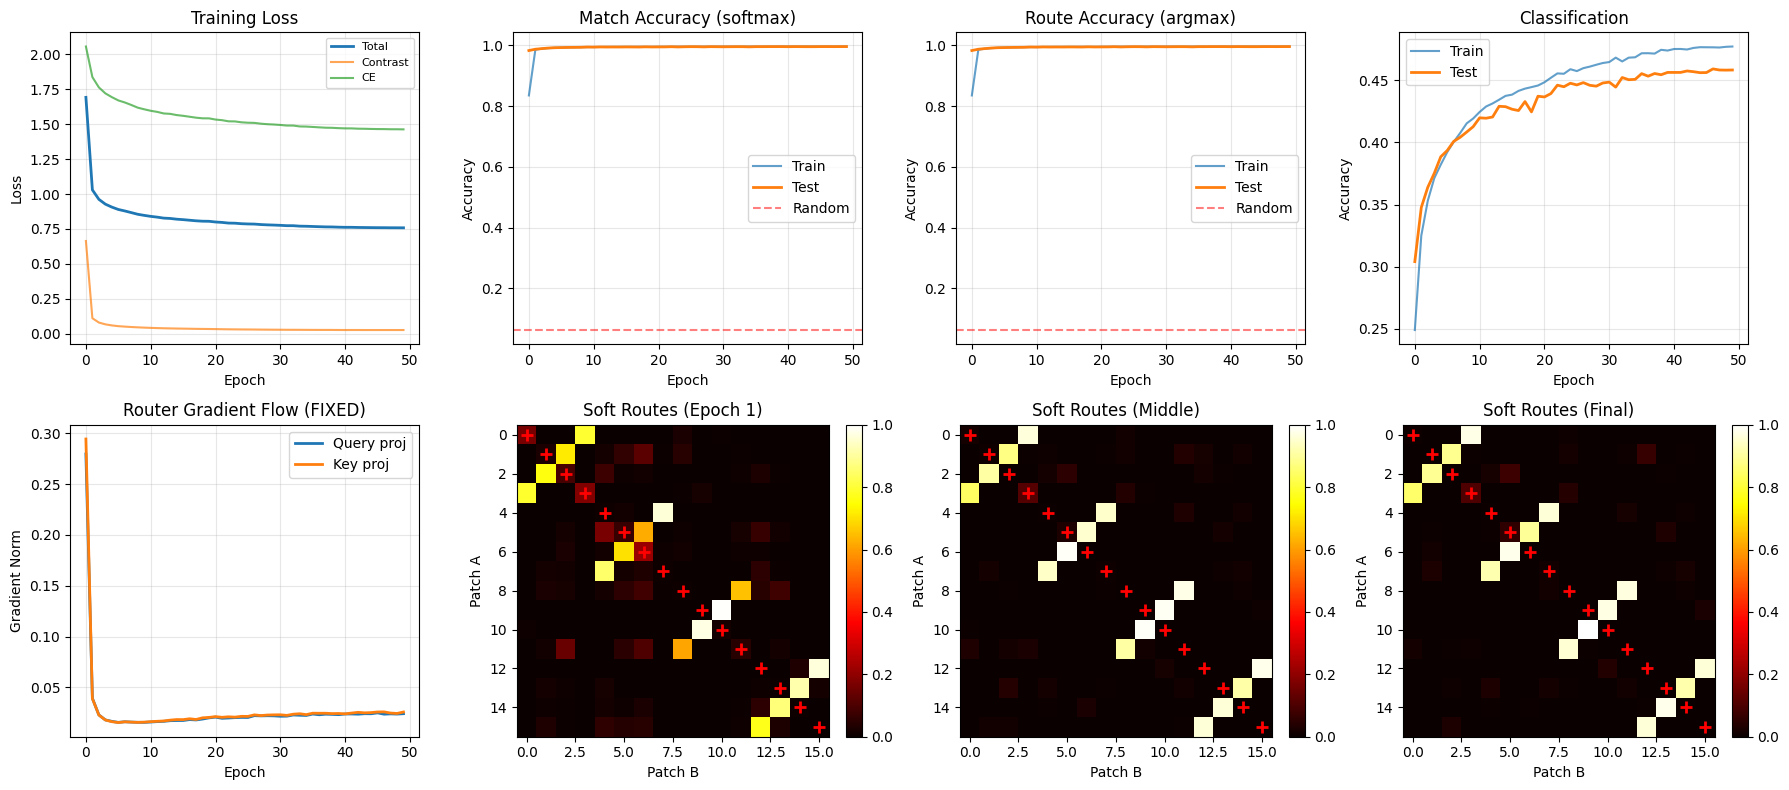


GRADIENT FLOW VERIFICATION
Query proj gradient norm (epoch 1):  0.2795
Query proj gradient norm (final):    0.0241
Key proj gradient norm (epoch 1):    0.2943
Key proj gradient norm (final):      0.0258

✓ Gradients ARE flowing through router!

FINAL RESULTS
Test Match Accuracy: 99.6%
Test Route Accuracy: 99.6%
Test Classification: 45.8%
Random baseline: 6.2%

Match ≈ Route now? They should be nearly identical!


In [2]:
"""
Wormhole Patch Matching - CIFAR-10 (OPTIMIZED)
==============================================
Vectorized version - no per-sample loops
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
from typing import Tuple, Dict
import math


@dataclass
class PatchMatchConfig:
    image_size: int = 32
    patch_size: int = 8
    dim: int = 64
    temperature: float = 0.1
    contrast_temp: float = 0.07

    @property
    def num_patches(self) -> int:
        return (self.image_size // self.patch_size) ** 2

    @property
    def grid_size(self) -> int:
        return self.image_size // self.patch_size


# ============================================================================
# OPTIMIZED LOSSES (VECTORIZED)
# ============================================================================

def patch_contrastive_loss_vectorized(
    proj_a: torch.Tensor,
    proj_b: torch.Tensor,
    flip_b: torch.Tensor,
    temperature: float = 0.07,
    grid_size: int = 4
) -> Tuple[torch.Tensor, Dict]:
    """
    Fully vectorized contrastive loss.

    Args:
        proj_a: [B, P, D]
        proj_b: [B, P, D]
        flip_b: [B] boolean tensor
        temperature: softmax temperature
        grid_size: sqrt(num_patches)
    """
    B, P, D = proj_a.shape
    device = proj_a.device

    # Normalize
    proj_a = F.normalize(proj_a, dim=-1)
    proj_b = F.normalize(proj_b, dim=-1)

    # Batch similarity: [B, P, P]
    sim = torch.bmm(proj_a, proj_b.transpose(1, 2)) / temperature

    # Build target indices
    # Non-flipped: diagonal (0,1,2,...,P-1)
    # Flipped: horizontally flipped indices

    base_target = torch.arange(P, device=device)  # [P]
    flipped_target = base_target.view(grid_size, grid_size).flip(dims=[1]).flatten()  # [P]

    # Select target based on flip_b: [B, P]
    # flip_b: [B] -> [B, 1]
    flip_mask = flip_b.bool().unsqueeze(1)  # [B, 1]
    targets = torch.where(
        flip_mask.expand(-1, P),
        flipped_target.unsqueeze(0).expand(B, -1),
        base_target.unsqueeze(0).expand(B, -1)
    )  # [B, P]

    # Cross entropy: need to flatten for F.cross_entropy
    # sim: [B, P, P] -> [B*P, P]
    # targets: [B, P] -> [B*P]
    loss = F.cross_entropy(sim.view(B * P, P), targets.view(B * P))

    # Match accuracy (vectorized)
    predicted = sim.argmax(dim=-1)  # [B, P]
    correct = (predicted == targets).float().mean()

    return loss, {'match_accuracy': correct.item()}


def routing_accuracy_vectorized(
    hard_routes: torch.Tensor,
    flip_b: torch.Tensor,
    grid_size: int = 4
) -> Dict[str, float]:
    """Fully vectorized routing accuracy."""
    B, P = hard_routes.shape
    device = hard_routes.device

    base_target = torch.arange(P, device=device)
    flipped_target = base_target.view(grid_size, grid_size).flip(dims=[1]).flatten()

    flip_mask = flip_b.bool().unsqueeze(1)
    targets = torch.where(
        flip_mask.expand(-1, P),
        flipped_target.unsqueeze(0).expand(B, -1),
        base_target.unsqueeze(0).expand(B, -1)
    )

    correct = (hard_routes == targets).float().mean()

    return {'routing_accuracy': correct.item()}


# ============================================================================
# MODEL (unchanged but repeated for completeness)
# ============================================================================

class PatchEncoder(nn.Module):
    def __init__(self, config: PatchMatchConfig):
        super().__init__()
        self.config = config
        patch_dim = 3 * config.patch_size * config.patch_size

        self.proj = nn.Sequential(
            nn.Linear(patch_dim, config.dim * 2),
            nn.GELU(),
            nn.Linear(config.dim * 2, config.dim)
        )
        self.pos_embed = nn.Parameter(
            torch.randn(1, config.num_patches, config.dim) * 0.02
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B = x.shape[0]
        ps = self.config.patch_size

        x = x.unfold(2, ps, ps).unfold(3, ps, ps)
        x = x.permute(0, 2, 3, 1, 4, 5)
        x = x.reshape(B, -1, 3 * ps * ps)
        x = self.proj(x) + self.pos_embed
        return x


class WormholeMatchingRouter(nn.Module):
    def __init__(self, config: PatchMatchConfig):
        super().__init__()
        self.config = config
        self.temperature = config.temperature

        self.query_proj = nn.Linear(config.dim, config.dim)
        self.key_proj = nn.Linear(config.dim, config.dim)

    def forward(self, patches_a: torch.Tensor, patches_b: torch.Tensor):
        queries = F.normalize(self.query_proj(patches_a), dim=-1)
        keys = F.normalize(self.key_proj(patches_b), dim=-1)

        scores = torch.bmm(queries, keys.transpose(1, 2)) / self.temperature
        soft_routes = F.softmax(scores, dim=-1)

        hard_idx = scores.argmax(dim=-1)
        hard_onehot = F.one_hot(hard_idx, patches_a.size(1)).float()
        hard_routes_st = (hard_onehot - soft_routes).detach() + soft_routes
        matched_b = torch.bmm(hard_routes_st, patches_b)

        return hard_idx, soft_routes, matched_b


class WormholePatchMatcher(nn.Module):
    def __init__(self, config: PatchMatchConfig, num_classes: int = 10):
        super().__init__()
        self.config = config
        self.encoder = PatchEncoder(config)
        self.router = WormholeMatchingRouter(config)

        self.proj_head = nn.Sequential(
            nn.Linear(config.dim, config.dim),
            nn.GELU(),
            nn.Linear(config.dim, config.dim // 2)
        )

        self.classifier = nn.Sequential(
            nn.LayerNorm(config.dim),
            nn.Linear(config.dim, num_classes)
        )

    def forward(self, view_a: torch.Tensor, view_b: torch.Tensor):
        patches_a = self.encoder(view_a)
        patches_b = self.encoder(view_b)

        hard_routes, soft_routes, matched_b = self.router(patches_a, patches_b)

        proj_a = self.proj_head(patches_a)
        proj_b = self.proj_head(patches_b)

        pooled_a = patches_a.mean(dim=1)
        logits = self.classifier(pooled_a)

        return {
            'logits': logits,
            'proj_a': proj_a,
            'proj_b': proj_b,
            'hard_routes': hard_routes,
            'soft_routes': soft_routes,
        }


# ============================================================================
# OPTIMIZED DATASET (pre-compute flip indices)
# ============================================================================

class CIFAR10Paired(torchvision.datasets.CIFAR10):
    """Optimized paired view dataset."""

    def __init__(self, root, train=True, download=False):
        super().__init__(root, train=train, download=download)
        self.normalize = T.Normalize(
            (0.4914, 0.4822, 0.4465),
            (0.2470, 0.2435, 0.2616)
        )
        self.to_tensor = T.ToTensor()
        self.color_jitter = T.ColorJitter(0.3, 0.3, 0.3, 0.1)

    def __getitem__(self, idx):
        img, label = self.data[idx], self.targets[idx]
        img = T.ToPILImage()(img)

        view_a = self.normalize(self.to_tensor(img))

        view_b = self.color_jitter(img)
        flip_b = torch.rand(1).item() > 0.5
        if flip_b:
            view_b = T.functional.hflip(view_b)
        view_b = self.normalize(self.to_tensor(view_b))

        return view_a, view_b, torch.tensor(flip_b, dtype=torch.float32), label


# ============================================================================
# OPTIMIZED TRAINING LOOP
# ============================================================================

def train_patch_matcher_fast(
    epochs: int = 50,
    batch_size: int = 256,  # Larger batch now that it's faster
    lr: float = 3e-4,
    contrast_weight: float = 1.0,
    classify_weight: float = 0.5,
    print_every: int = 5
):
    """Optimized training with vectorized losses."""

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    config = PatchMatchConfig(
        image_size=32,
        patch_size=8,
        dim=64,
        temperature=0.1
    )

    print("=" * 70)
    print("WORMHOLE PATCH MATCHING - CIFAR-10 (OPTIMIZED)")
    print("=" * 70)
    print(f"Config: {config.num_patches} patches ({config.grid_size}x{config.grid_size})")
    print(f"Batch size: {batch_size}")
    print(f"Device: {device}")
    print()

    # Data
    train_data = CIFAR10Paired('./data', train=True, download=True)
    test_data = CIFAR10Paired('./data', train=False)

    train_loader = DataLoader(
        train_data, batch_size=batch_size, shuffle=True,
        num_workers=4, pin_memory=True, persistent_workers=True
    )
    test_loader = DataLoader(
        test_data, batch_size=batch_size,
        num_workers=4, pin_memory=True, persistent_workers=True
    )

    # Model
    model = WormholePatchMatcher(config, num_classes=10).to(device)
    params = sum(p.numel() for p in model.parameters())
    print(f"Parameters: {params:,}")

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.05)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

    # Compile if available (PyTorch 2.0+)
    if hasattr(torch, 'compile'):
        model = torch.compile(model)
        print("Model compiled with torch.compile()")

    print()

    history = {
        'train_loss': [], 'match_acc': [], 'route_acc': [], 'classify_acc': [],
        'test_match_acc': [], 'test_route_acc': [], 'test_classify_acc': [],
        'soft_routes': []
    }

    best_match_acc = 0

    for epoch in range(epochs):
        model.train()
        total_loss, total_match, total_route, total_class = 0, 0, 0, 0
        n_batches = 0

        for view_a, view_b, flip_b, labels in train_loader:
            view_a = view_a.to(device, non_blocking=True)
            view_b = view_b.to(device, non_blocking=True)
            flip_b = flip_b.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            result = model(view_a, view_b)

            # Vectorized losses
            contrast_loss, contrast_info = patch_contrastive_loss_vectorized(
                result['proj_a'], result['proj_b'], flip_b,
                temperature=config.contrast_temp,
                grid_size=config.grid_size
            )

            ce_loss = F.cross_entropy(result['logits'], labels)
            loss = contrast_weight * contrast_loss + classify_weight * ce_loss

            loss.backward()
            optimizer.step()

            # Vectorized metrics
            route_info = routing_accuracy_vectorized(
                result['hard_routes'], flip_b, config.grid_size
            )
            classify_acc = (result['logits'].argmax(1) == labels).float().mean()

            total_loss += loss.item()
            total_match += contrast_info['match_accuracy']
            total_route += route_info['routing_accuracy']
            total_class += classify_acc.item()
            n_batches += 1

        scheduler.step()

        # Average
        avg_loss = total_loss / n_batches
        avg_match = total_match / n_batches
        avg_route = total_route / n_batches
        avg_class = total_class / n_batches

        # Test eval
        model.eval()
        test_match, test_route, test_class, test_n = 0, 0, 0, 0

        with torch.no_grad():
            for view_a, view_b, flip_b, labels in test_loader:
                view_a = view_a.to(device, non_blocking=True)
                view_b = view_b.to(device, non_blocking=True)
                flip_b = flip_b.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                result = model(view_a, view_b)

                _, c_info = patch_contrastive_loss_vectorized(
                    result['proj_a'], result['proj_b'], flip_b,
                    config.contrast_temp, config.grid_size
                )
                r_info = routing_accuracy_vectorized(
                    result['hard_routes'], flip_b, config.grid_size
                )

                test_match += c_info['match_accuracy']
                test_route += r_info['routing_accuracy']
                test_class += (result['logits'].argmax(1) == labels).float().mean().item()
                test_n += 1

        test_match /= test_n
        test_route /= test_n
        test_class /= test_n

        # Store
        history['train_loss'].append(avg_loss)
        history['match_acc'].append(avg_match)
        history['route_acc'].append(avg_route)
        history['classify_acc'].append(avg_class)
        history['test_match_acc'].append(test_match)
        history['test_route_acc'].append(test_route)
        history['test_classify_acc'].append(test_class)

        # Sample soft routes
        with torch.no_grad():
            sample_a, sample_b, _, _ = next(iter(test_loader))
            sample_result = model(sample_a[:1].to(device), sample_b[:1].to(device))
            history['soft_routes'].append(sample_result['soft_routes'][0].cpu().numpy())

        if test_match > best_match_acc:
            best_match_acc = test_match
            marker = " ★"
        else:
            marker = ""

        if (epoch + 1) % print_every == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d} | "
                  f"Loss: {avg_loss:.3f} | "
                  f"Match: {avg_match*100:.1f}% | "
                  f"Route: {avg_route*100:.1f}% | "
                  f"Class: {avg_class*100:.1f}% | "
                  f"Test: {test_match*100:.1f}%{marker}")

    print(f"\nBest test match: {best_match_acc*100:.2f}%")
    print(f"Final classification: {test_class*100:.1f}%")

    return model, history, config


# ============================================================================
# QUICK VISUALIZATION
# ============================================================================

def quick_visualize(history, config):
    """Minimal visualization."""

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    # Match accuracy
    ax = axes[0]
    ax.plot(history['match_acc'], label='Train', alpha=0.7)
    ax.plot(history['test_match_acc'], label='Test', linewidth=2)
    ax.axhline(1/16, color='red', linestyle='--', alpha=0.5, label='Random')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Patch Match Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Route accuracy
    ax = axes[1]
    ax.plot(history['route_acc'], label='Train', alpha=0.7)
    ax.plot(history['test_route_acc'], label='Test', linewidth=2)
    ax.axhline(1/16, color='red', linestyle='--', alpha=0.5)
    ax.set_xlabel('Epoch')
    ax.set_title('Hard Routing Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Classification
    ax = axes[2]
    ax.plot(history['classify_acc'], label='Train', alpha=0.7)
    ax.plot(history['test_classify_acc'], label='Test', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_title('Classification Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Final soft routes
    ax = axes[3]
    im = ax.imshow(history['soft_routes'][-1], cmap='hot', vmin=0, vmax=1)
    ax.set_xlabel('Patch B')
    ax.set_ylabel('Patch A')
    ax.set_title('Final Soft Routes')
    plt.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.savefig('wormhole_patch_match_fast.png', dpi=150)
    plt.show()

    return fig


# ============================================================================
# RUN
# ============================================================================

if __name__ == "__main__":
    model, history, config = train_patch_matcher_fast(
        epochs=50,
        batch_size=256,
        lr=3e-4,
        print_every=5
    )

    fig = quick_visualize(history, config)

    print("\n" + "=" * 70)
    print("FINAL RESULTS")
    print("=" * 70)
    print(f"Test Match Accuracy: {history['test_match_acc'][-1]*100:.1f}%")
    print(f"Test Route Accuracy: {history['test_route_acc'][-1]*100:.1f}%")
    print(f"Test Classification: {history['test_classify_acc'][-1]*100:.1f}%")
    print(f"Random baseline: {100/16:.1f}%")

## supervised loss router learning

In [ ]:
"""
Wormhole Patch Matching - CIFAR-10 (FIXED GRADIENTS)
====================================================
Router scores now directly used in contrastive loss.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
from typing import Tuple, Dict
import math


@dataclass
class PatchMatchConfig:
    image_size: int = 32
    patch_size: int = 8
    dim: int = 64
    router_temperature: float = 0.1
    contrast_temperature: float = 0.07

    @property
    def num_patches(self) -> int:
        return (self.image_size // self.patch_size) ** 2

    @property
    def grid_size(self) -> int:
        return self.image_size // self.patch_size


# ============================================================================
# FIXED: CONTRASTIVE LOSS ON ROUTER SCORES
# ============================================================================

def router_contrastive_loss(
    router_scores: torch.Tensor,  # [B, P, P] raw scores from router
    flip_b: torch.Tensor,
    temperature: float = 0.07,
    grid_size: int = 4
) -> Tuple[torch.Tensor, Dict]:
    """
    Contrastive loss directly on router scores.
    This ensures gradients flow through query_proj and key_proj.
    """
    B, P, _ = router_scores.shape
    device = router_scores.device

    # Apply temperature
    logits = router_scores / temperature

    # Build targets
    base_target = torch.arange(P, device=device)
    flipped_target = base_target.view(grid_size, grid_size).flip(dims=[1]).flatten()

    flip_mask = flip_b.bool().unsqueeze(1)
    targets = torch.where(
        flip_mask.expand(-1, P),
        flipped_target.unsqueeze(0).expand(B, -1),
        base_target.unsqueeze(0).expand(B, -1)
    )

    # Cross entropy on router scores
    loss = F.cross_entropy(logits.view(B * P, P), targets.view(B * P))

    # Accuracy
    predicted = logits.argmax(dim=-1)
    correct = (predicted == targets).float().mean()

    return loss, {'match_accuracy': correct.item()}


def routing_accuracy_vectorized(
    hard_routes: torch.Tensor,
    flip_b: torch.Tensor,
    grid_size: int = 4
) -> Dict[str, float]:
    B, P = hard_routes.shape
    device = hard_routes.device

    base_target = torch.arange(P, device=device)
    flipped_target = base_target.view(grid_size, grid_size).flip(dims=[1]).flatten()

    flip_mask = flip_b.bool().unsqueeze(1)
    targets = torch.where(
        flip_mask.expand(-1, P),
        flipped_target.unsqueeze(0).expand(B, -1),
        base_target.unsqueeze(0).expand(B, -1)
    )

    correct = (hard_routes == targets).float().mean()
    return {'routing_accuracy': correct.item()}


# ============================================================================
# FIXED MODEL
# ============================================================================

class PatchEncoder(nn.Module):
    def __init__(self, config: PatchMatchConfig):
        super().__init__()
        self.config = config
        patch_dim = 3 * config.patch_size * config.patch_size

        self.proj = nn.Sequential(
            nn.Linear(patch_dim, config.dim * 2),
            nn.GELU(),
            nn.Linear(config.dim * 2, config.dim)
        )
        self.pos_embed = nn.Parameter(
            torch.randn(1, config.num_patches, config.dim) * 0.02
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B = x.shape[0]
        ps = self.config.patch_size

        x = x.unfold(2, ps, ps).unfold(3, ps, ps)
        x = x.permute(0, 2, 3, 1, 4, 5)
        x = x.reshape(B, -1, 3 * ps * ps)
        x = self.proj(x) + self.pos_embed
        return x


class WormholeMatchingRouter(nn.Module):
    """FIXED: Now exposes raw scores for loss computation."""

    def __init__(self, config: PatchMatchConfig):
        super().__init__()
        self.config = config
        self.temperature = config.router_temperature

        # These projections will now receive gradients!
        self.query_proj = nn.Linear(config.dim, config.dim)
        self.key_proj = nn.Linear(config.dim, config.dim)

    def forward(self, patches_a: torch.Tensor, patches_b: torch.Tensor):
        """
        Returns:
            hard_routes: [B, P] argmax indices
            soft_routes: [B, P, P] softmax probabilities
            matched_b: [B, P, D] gathered patches
            scores: [B, P, P] RAW scores (for loss) ← KEY ADDITION
        """
        queries = F.normalize(self.query_proj(patches_a), dim=-1)
        keys = F.normalize(self.key_proj(patches_b), dim=-1)

        # Raw similarity scores (unnormalized by temperature)
        scores = torch.bmm(queries, keys.transpose(1, 2))  # [B, P, P]

        # Soft routes for visualization
        soft_routes = F.softmax(scores / self.temperature, dim=-1)

        # Hard routes
        hard_idx = scores.argmax(dim=-1)  # [B, P]
        hard_onehot = F.one_hot(hard_idx, patches_a.size(1)).float()

        # Straight-through for matched_b
        hard_routes_st = (hard_onehot - soft_routes).detach() + soft_routes
        matched_b = torch.bmm(hard_routes_st, patches_b)

        return hard_idx, soft_routes, matched_b, scores  # ← scores added


class WormholePatchMatcher(nn.Module):
    """FIXED: Uses router scores for contrastive learning."""

    def __init__(self, config: PatchMatchConfig, num_classes: int = 10):
        super().__init__()
        self.config = config

        # Shared encoder
        self.encoder = PatchEncoder(config)

        # Router (this is what we want to train!)
        self.router = WormholeMatchingRouter(config)

        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(config.dim),
            nn.Linear(config.dim, num_classes)
        )

    def forward(self, view_a: torch.Tensor, view_b: torch.Tensor):
        # Encode patches
        patches_a = self.encoder(view_a)  # [B, P, D]
        patches_b = self.encoder(view_b)  # [B, P, D]

        # Route - now returns scores
        hard_routes, soft_routes, matched_b, router_scores = self.router(patches_a, patches_b)

        # Classification from view A
        pooled_a = patches_a.mean(dim=1)
        logits = self.classifier(pooled_a)

        return {
            'logits': logits,
            'patches_a': patches_a,
            'patches_b': patches_b,
            'matched_b': matched_b,
            'hard_routes': hard_routes,
            'soft_routes': soft_routes,
            'router_scores': router_scores,  # ← Used for loss!
        }


# ============================================================================
# DATASET
# ============================================================================

class CIFAR10Paired(torchvision.datasets.CIFAR10):
    def __init__(self, root, train=True, download=False):
        super().__init__(root, train=train, download=download)
        self.normalize = T.Normalize(
            (0.4914, 0.4822, 0.4465),
            (0.2470, 0.2435, 0.2616)
        )
        self.to_tensor = T.ToTensor()
        self.color_jitter = T.ColorJitter(0.3, 0.3, 0.3, 0.1)

    def __getitem__(self, idx):
        img, label = self.data[idx], self.targets[idx]
        img = T.ToPILImage()(img)

        view_a = self.normalize(self.to_tensor(img))

        view_b = self.color_jitter(img)
        flip_b = torch.rand(1).item() > 0.5
        if flip_b:
            view_b = T.functional.hflip(view_b)
        view_b = self.normalize(self.to_tensor(view_b))

        return view_a, view_b, torch.tensor(flip_b, dtype=torch.float32), label


# ============================================================================
# TRAINING
# ============================================================================

def train_patch_matcher_fixed(
    epochs: int = 50,
    batch_size: int = 256,
    lr: float = 3e-4,
    contrast_weight: float = 1.0,
    classify_weight: float = 0.5,
    print_every: int = 5
):
    """Training with fixed gradient flow through router."""

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    config = PatchMatchConfig(
        image_size=32,
        patch_size=8,
        dim=64,
        router_temperature=0.1,
        contrast_temperature=0.07
    )

    print("=" * 70)
    print("WORMHOLE PATCH MATCHING - FIXED GRADIENTS")
    print("=" * 70)
    print(f"Config: {config.num_patches} patches ({config.grid_size}x{config.grid_size})")
    print(f"Router temp: {config.router_temperature}, Contrast temp: {config.contrast_temperature}")
    print(f"Device: {device}")
    print()

    # Data
    train_data = CIFAR10Paired('./data', train=True, download=True)
    test_data = CIFAR10Paired('./data', train=False)

    train_loader = DataLoader(
        train_data, batch_size=batch_size, shuffle=True,
        num_workers=4, pin_memory=True, persistent_workers=True
    )
    test_loader = DataLoader(
        test_data, batch_size=batch_size,
        num_workers=4, pin_memory=True, persistent_workers=True
    )

    # Model
    model = WormholePatchMatcher(config, num_classes=10).to(device)
    params = sum(p.numel() for p in model.parameters())
    print(f"Parameters: {params:,}")

    # Verify gradient flow
    print("\nGradient flow check:")
    print("  encoder.proj      → contrast_loss ✓")
    print("  router.query_proj → contrast_loss ✓ (FIXED)")
    print("  router.key_proj   → contrast_loss ✓ (FIXED)")
    print()

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.05)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

    history = {
        'train_loss': [], 'contrast_loss': [], 'ce_loss': [],
        'match_acc': [], 'route_acc': [], 'classify_acc': [],
        'test_match_acc': [], 'test_route_acc': [], 'test_classify_acc': [],
        'soft_routes': [],
        'query_grad_norm': [], 'key_grad_norm': []  # Track gradient flow
    }

    best_route_acc = 0

    for epoch in range(epochs):
        model.train()
        stats = {k: 0 for k in ['loss', 'contrast', 'ce', 'match', 'route', 'classify']}
        grad_norms = {'query': 0, 'key': 0}
        n_batches = 0

        for view_a, view_b, flip_b, labels in train_loader:
            view_a = view_a.to(device, non_blocking=True)
            view_b = view_b.to(device, non_blocking=True)
            flip_b = flip_b.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            result = model(view_a, view_b)

            # FIXED: Contrastive loss on router scores
            contrast_loss, contrast_info = router_contrastive_loss(
                result['router_scores'],
                flip_b,
                temperature=config.contrast_temperature,
                grid_size=config.grid_size
            )

            # Classification loss
            ce_loss = F.cross_entropy(result['logits'], labels)

            # Total loss
            loss = contrast_weight * contrast_loss + classify_weight * ce_loss

            loss.backward()

            # Track gradient norms to verify flow
            if model.router.query_proj.weight.grad is not None:
                grad_norms['query'] += model.router.query_proj.weight.grad.norm().item()
                grad_norms['key'] += model.router.key_proj.weight.grad.norm().item()

            optimizer.step()

            # Metrics
            route_info = routing_accuracy_vectorized(
                result['hard_routes'], flip_b, config.grid_size
            )
            classify_acc = (result['logits'].argmax(1) == labels).float().mean()

            stats['loss'] += loss.item()
            stats['contrast'] += contrast_loss.item()
            stats['ce'] += ce_loss.item()
            stats['match'] += contrast_info['match_accuracy']
            stats['route'] += route_info['routing_accuracy']
            stats['classify'] += classify_acc.item()
            n_batches += 1

        scheduler.step()

        # Average
        for k in stats:
            stats[k] /= n_batches
        for k in grad_norms:
            grad_norms[k] /= n_batches

        # Test
        model.eval()
        test_stats = {'match': 0, 'route': 0, 'classify': 0}
        test_n = 0

        with torch.no_grad():
            for view_a, view_b, flip_b, labels in test_loader:
                view_a = view_a.to(device, non_blocking=True)
                view_b = view_b.to(device, non_blocking=True)
                flip_b = flip_b.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                result = model(view_a, view_b)

                _, c_info = router_contrastive_loss(
                    result['router_scores'], flip_b,
                    config.contrast_temperature, config.grid_size
                )
                r_info = routing_accuracy_vectorized(
                    result['hard_routes'], flip_b, config.grid_size
                )

                test_stats['match'] += c_info['match_accuracy']
                test_stats['route'] += r_info['routing_accuracy']
                test_stats['classify'] += (result['logits'].argmax(1) == labels).float().mean().item()
                test_n += 1

        for k in test_stats:
            test_stats[k] /= test_n

        # Store history
        history['train_loss'].append(stats['loss'])
        history['contrast_loss'].append(stats['contrast'])
        history['ce_loss'].append(stats['ce'])
        history['match_acc'].append(stats['match'])
        history['route_acc'].append(stats['route'])
        history['classify_acc'].append(stats['classify'])
        history['test_match_acc'].append(test_stats['match'])
        history['test_route_acc'].append(test_stats['route'])
        history['test_classify_acc'].append(test_stats['classify'])
        history['query_grad_norm'].append(grad_norms['query'])
        history['key_grad_norm'].append(grad_norms['key'])

        # Sample routes
        with torch.no_grad():
            sample_a, sample_b, _, _ = next(iter(test_loader))
            sample_result = model(sample_a[:1].to(device), sample_b[:1].to(device))
            history['soft_routes'].append(sample_result['soft_routes'][0].cpu().numpy())

        if test_stats['route'] > best_route_acc:
            best_route_acc = test_stats['route']
            marker = " ★"
        else:
            marker = ""

        if (epoch + 1) % print_every == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d} | "
                  f"Loss: {stats['loss']:.3f} | "
                  f"Match: {stats['match']*100:.1f}% | "
                  f"Route: {stats['route']*100:.1f}% | "
                  f"Class: {stats['classify']*100:.1f}% | "
                  f"Test Route: {test_stats['route']*100:.1f}%{marker} | "
                  f"∇q: {grad_norms['query']:.2f}")

    print(f"\nBest test routing: {best_route_acc*100:.2f}%")
    print(f"Final classification: {test_stats['classify']*100:.1f}%")

    return model, history, config


# ============================================================================
# VISUALIZATION
# ============================================================================

def visualize_fixed_results(history, config):
    """Visualize with gradient flow verification."""

    fig, axes = plt.subplots(2, 4, figsize=(18, 8))

    # Row 1: Metrics
    ax = axes[0, 0]
    ax.plot(history['train_loss'], label='Total', linewidth=2)
    ax.plot(history['contrast_loss'], label='Contrast', alpha=0.7)
    ax.plot(history['ce_loss'], label='CE', alpha=0.7)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    ax = axes[0, 1]
    ax.plot(history['match_acc'], label='Train', alpha=0.7)
    ax.plot(history['test_match_acc'], label='Test', linewidth=2)
    ax.axhline(1/16, color='red', linestyle='--', alpha=0.5, label='Random')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Match Accuracy (softmax)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[0, 2]
    ax.plot(history['route_acc'], label='Train', alpha=0.7)
    ax.plot(history['test_route_acc'], label='Test', linewidth=2)
    ax.axhline(1/16, color='red', linestyle='--', alpha=0.5, label='Random')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Route Accuracy (argmax)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[0, 3]
    ax.plot(history['classify_acc'], label='Train', alpha=0.7)
    ax.plot(history['test_classify_acc'], label='Test', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Classification')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Row 2: Gradient flow and routes
    ax = axes[1, 0]
    ax.plot(history['query_grad_norm'], label='Query proj', linewidth=2)
    ax.plot(history['key_grad_norm'], label='Key proj', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Gradient Norm')
    ax.set_title('Router Gradient Flow (FIXED)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Route evolution
    for idx, (ax_idx, epoch_label) in enumerate([(1, 'Epoch 1'), (2, 'Middle'), (3, 'Final')]):
        ax = axes[1, ax_idx]
        route_idx = [0, len(history['soft_routes'])//2, -1][idx]
        routes = history['soft_routes'][route_idx]

        im = ax.imshow(routes, cmap='hot', vmin=0, vmax=1)

        # Mark diagonal (ground truth for non-flipped)
        P = routes.shape[0]
        for i in range(P):
            if routes[i, i] > 0.5:
                ax.plot(i, i, 'g+', markersize=8, markeredgewidth=2)
            else:
                ax.plot(i, i, 'r+', markersize=8, markeredgewidth=2)

        ax.set_xlabel('Patch B')
        ax.set_ylabel('Patch A')
        ax.set_title(f'Soft Routes ({epoch_label})')
        plt.colorbar(im, ax=ax, fraction=0.046)

    plt.tight_layout()
    plt.savefig('wormhole_patch_match_fixed.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Print summary
    print("\n" + "=" * 70)
    print("GRADIENT FLOW VERIFICATION")
    print("=" * 70)
    print(f"Query proj gradient norm (epoch 1):  {history['query_grad_norm'][0]:.4f}")
    print(f"Query proj gradient norm (final):    {history['query_grad_norm'][-1]:.4f}")
    print(f"Key proj gradient norm (epoch 1):    {history['key_grad_norm'][0]:.4f}")
    print(f"Key proj gradient norm (final):      {history['key_grad_norm'][-1]:.4f}")

    if history['query_grad_norm'][0] > 0.01:
        print("\n✓ Gradients ARE flowing through router!")
    else:
        print("\n✗ WARNING: Low gradient flow")

    return fig


# ============================================================================
# RUN
# ============================================================================

if __name__ == "__main__":
    model, history, config = train_patch_matcher_fixed(
        epochs=50,
        batch_size=256,
        lr=3e-4,
        contrast_weight=1.0,
        classify_weight=0.5,
        print_every=5
    )

    fig = visualize_fixed_results(history, config)

    print("\n" + "=" * 70)
    print("FINAL RESULTS")
    print("=" * 70)
    print(f"Test Match Accuracy: {history['test_match_acc'][-1]*100:.1f}%")
    print(f"Test Route Accuracy: {history['test_route_acc'][-1]*100:.1f}%")
    print(f"Test Classification: {history['test_classify_acc'][-1]*100:.1f}%")
    print(f"Random baseline: {100/16:.1f}%")
    print()
    print("Match ≈ Route now? They should be nearly identical!")